#Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# adjusting figure resolution
plt.rcParams['figure.dpi'] = 300

In [ ]:
pip install scikit-learn==1.2.2

In [ ]:
pip install scikit-survival==0.20.0

In [ ]:
pip install lifelines

In [ ]:
from sksurv.ensemble import RandomSurvivalForest

In [ ]:
from lifelines import KaplanMeierFitter

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
from sklearn.preprocessing import RobustScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

In [ ]:
# Read datasets needed (if using google drive
snuh_with_NaN_orig = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/X_and_Y_SNUH_with_NaNs.csv')
proact_with_NaN_orig = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/X_and_Y_with_NaNs.csv')
study_population = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/PRO-ACT_filtered.csv')
snuh_frs = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/snuh_alsfrs2.csv')
dx = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/snuh_dx2.csv')

<ipython-input-11-ab93c659c4e8>:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  study_population = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/PRO-ACT_filtered.csv')


In [ ]:
snuh_with_NaN_orig.drop(columns=['Unnamed: 0', 'slope_fvc', 'slope_creatinine', 'slope_weight'], inplace = True)
proact_with_NaN_orig.drop(columns=['Unnamed: 0', 'slope_fvc', 'slope_creatinine', 'slope_weight'], inplace = True)

In [ ]:
snuh_with_NaN_orig = snuh_with_NaN_orig.sort_values(by='SubjectID')
proact_with_NaN_orig = proact_with_NaN_orig.sort_values(by='SubjectID')

In [ ]:
snuh_with_NaN_orig_no_id = snuh_with_NaN_orig.drop(columns=['SubjectID'])
proact_with_NaN_orig_no_id = proact_with_NaN_orig.drop(columns=['SubjectID'])

preprocess PRO-ACT

In [ ]:
# Scaling with RobustScaler
categorical_and_y = proact_with_NaN_orig_no_id[['Gender', 'onset_site','time_LOA', 'status_LOA']]
X_continuous_NaN = proact_with_NaN_orig_no_id.drop(['Gender', 'onset_site','time_LOA', 'status_LOA'], axis = 1)
columns = X_continuous_NaN.columns
scaler = RobustScaler()
scaled = scaler.fit_transform(X_continuous_NaN)
X_continuous_scaled = pd.DataFrame(scaled, columns = columns)
X_y_scaled = pd.concat([X_continuous_scaled, categorical_and_y],axis=1)

# Imputation with IterativeImputer
y = X_y_scaled[['time_LOA', 'status_LOA']]
X_NaN = X_y_scaled.drop(['time_LOA', 'status_LOA'], axis = 1)
columns = X_NaN.columns
imputer = IterativeImputer(sample_posterior = True, random_state=11)
ar = imputer.fit_transform(X_NaN)
X_imputed = pd.DataFrame(ar, columns = columns)
X_y_scaled_imputed = pd.concat([X_imputed, y],axis=1)

# concat subject ID
X_y_scaled_imputed['SubjectID'] = proact_with_NaN_orig['SubjectID']
df_train_imputed = X_y_scaled_imputed.copy()

# Imputation with IterativeImputer for RSF (no need scaling process)
y = proact_with_NaN_orig_no_id[['time_LOA', 'status_LOA']]
X_NaN = proact_with_NaN_orig_no_id.drop(['time_LOA', 'status_LOA'], axis = 1)
columns = X_NaN.columns
imputer = IterativeImputer(sample_posterior = True, random_state=11)
ar = imputer.fit_transform(X_NaN)
X_imputed = pd.DataFrame(ar, columns = columns)
X_y_imputed = pd.concat([X_imputed, y],axis=1)
X_y_imputed['SubjectID'] = proact_with_NaN_orig['SubjectID']
df_train_imputed_rsf = X_y_imputed.copy()

preprocess SNUH

In [ ]:
# Scaling with RobustScaler - SNUH data

categorical_and_y = snuh_with_NaN_orig_no_id[['Gender', 'onset_site','time_LOA', 'status_LOA']]
X_continuous_NaN_snuh = snuh_with_NaN_orig_no_id.drop(['Gender', 'onset_site','time_LOA', 'status_LOA'], axis = 1)
X_continuous_NaN_snuh = X_continuous_NaN_snuh[['Age', 'diag_delta', 'onset_delta', 'diag_minus_onset',
       'mean_Q1_Speech', 'mean_Q2_Salivation', 'mean_Q3_Swallowing',
       'mean_Q4_Handwriting', 'mean_Q6_Dressing_and_Hygiene',
       'mean_Q7_Turning_in_Bed', 'mean_Q8_Walking',
       'mean_Q9_Climbing_Stairs', 'mean_ALSFRS_R_Total',
       'mean_R1_Dyspnea', 'mean_R2_Orthopnea',
       'mean_R3_Respiratory_Insufficiency', 'mean_Q5_Cutting',
       'mean_bulbar', 'mean_motor', 'mean_respiratory_R',
       'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing',
       'slope_Q4_Handwriting', 'slope_Q6_Dressing_and_Hygiene',
       'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking',
       'slope_Q9_Climbing_Stairs', 'slope_ALSFRS_R_Total',
       'slope_R1_Dyspnea', 'slope_R2_Orthopnea',
       'slope_R3_Respiratory_Insufficiency', 'slope_Q5_Cutting',
       'slope_bulbar', 'slope_motor', 'slope_respiratory_R', 'mean_fvc',
       'mean_creatinine', 'mean_weight']]
columns = X_continuous_NaN_snuh.columns
scaled = scaler.transform(X_continuous_NaN_snuh)
X_continuous_scaled = pd.DataFrame(scaled, columns = columns)
X_y_scaled_snuh = pd.concat([X_continuous_scaled, categorical_and_y],axis=1)

# Imputation with IterativeImputer
y = X_y_scaled_snuh[['time_LOA', 'status_LOA']]
X_NaN = X_y_scaled_snuh.drop(['time_LOA', 'status_LOA'], axis = 1)
columns = X_NaN.columns
imputer = IterativeImputer(sample_posterior = True, random_state=11)
ar = imputer.fit_transform(X_NaN)
X_imputed = pd.DataFrame(ar, columns = columns)
X_y_scaled_imputed_snuh = pd.concat([X_imputed, y],axis=1)

# concat subject ID
X_y_scaled_imputed_snuh['SubjectID'] = snuh_with_NaN_orig['SubjectID']
snuh_imputed = X_y_scaled_imputed_snuh.copy()

# Imputation with IterativeImputer for RSF (no need scaling process)
y = snuh_with_NaN_orig_no_id[['time_LOA', 'status_LOA']]
X_NaN = snuh_with_NaN_orig_no_id.drop(['time_LOA', 'status_LOA'], axis = 1)
columns = X_NaN.columns
imputer = IterativeImputer(sample_posterior = True, random_state=11)
ar = imputer.fit_transform(X_NaN)
X_imputed = pd.DataFrame(ar, columns = columns)
X_y_imputed = pd.concat([X_imputed, y],axis=1)
X_y_imputed['SubjectID'] = snuh_with_NaN_orig['SubjectID']
snuh_imputed_rsf = X_y_imputed.copy()

In [ ]:
#Feature selection results
aft_final_feature_list = ['Age', 'onset_site', 'mean_R3_Respiratory_Insufficiency', 'mean_weight', 'diag_delta', 'mean_Q5_Cutting', 'mean_creatinine', 'mean_Q2_Salivation', 'mean_fvc', 'mean_Q3_Swallowing', 'mean_Q7_Turning_in_Bed', 'onset_delta', 'mean_bulbar']

cph_final_feature_list = ['mean_bulbar', 'onset_delta', 'mean_Q3_Swallowing', 'mean_fvc', 'mean_Q7_Turning_in_Bed', 'mean_Q2_Salivation', 'mean_creatinine', 'mean_weight', 'mean_ALSFRS_R_Total', 'diag_delta', 'mean_Q5_Cutting', 'mean_R3_Respiratory_Insufficiency', 'onset_site', 'Age']

rsf_final_feature_list = ['mean_Q2_Salivation', 'Age', 'mean_fvc', 'mean_ALSFRS_R_Total', 'mean_Q3_Swallowing', 'onset_delta', 'mean_bulbar', 'mean_Q1_Speech']

## Import the final model

In [ ]:
# Random Survival Forests requires array-type data, thus additional preprocessing was needed
dic = {1:True, 0:False}

df_train_rsf = df_train_imputed_rsf[['status_LOA', 'time_LOA']]
df_train_rsf = df_train_rsf.replace({'status_LOA':dic})
arr_1 = list(tuple(x) for x in df_train_rsf.to_records(index=False))
dt = np.dtype('bool, float')
y_train_rsf = np.array(arr_1, dtype=dt)
y_train_rsf.dtype.names=['cens', 'time']
y_train_rsf

array([(False, 10.18), ( True,  6.44), (False,  2.06), ...,
       (False, 10.78), (False,  3.05), (False,  1.14)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
# Bring the final AFT model
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer=0.01, l1_ratio=1)
aft.fit(df_train_imputed[aft_final_feature_list+['time_LOA', 'status_LOA']], duration_col='time_LOA', event_col='status_LOA', ancillary=False)

<lifelines.WeibullAFTFitter: fitted with 3396 total observations, 2781 right-censored observations>

In [ ]:
# Bring the final COX model
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.01, l1_ratio=1)
cph.fit(df_train_imputed[cph_final_feature_list+['time_LOA', 'status_LOA']], 'time_LOA', event_col='status_LOA')

<lifelines.CoxPHFitter: fitted with 3396 total observations, 2781 right-censored observations>

In [ ]:
# Bring the final RSF model
# CAUTION! Runtime takes 1 min
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=8,  min_samples_leaf=14, max_features="auto",
                           n_jobs=-1, random_state=20)
rsf.fit(df_train_imputed_rsf[rsf_final_feature_list], y_train_rsf)

RandomSurvivalForest(max_features='auto', min_samples_leaf=14,
                     min_samples_split=8, n_jobs=-1, random_state=20)

#1-1. Visualization (group)

## AFT

### (1) Categorizing patient data

In [ ]:
aft_median = pd.concat([df_train_imputed['SubjectID'],aft.predict_percentile(df_train_imputed[aft_final_feature_list], ancillary=None, p=0.5)], axis=1)
aft_median

SubjectID          0
0         348.0  46.850880
1         533.0   6.000563
2         902.0  24.457372
3        1736.0  14.402762
4        3971.0  51.050308
...         ...        ...
3391   998491.0  23.594866
3392   999166.0  33.539169
3393   999522.0  37.701860
3394   999823.0  17.320350
3395   999990.0  17.337146

[3396 rows x 2 columns]

In [ ]:
print('There are ' + str(aft_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in aft_median')

There are 0 inf values in aft_median


In [ ]:
aft_median[0].describe()

count     3396.000000
mean        37.614365
std        265.774012
min          2.089363
25%         17.067250
50%         29.299110
75%         42.716370
max      15415.422181
Name: 0, dtype: float64

In [ ]:
aft_slow_list = list(aft_median[aft_median[0] > 	42.716370]['SubjectID'])
aft_intermediate_list = list(aft_median[(aft_median[0] > 17.067250) & (aft_median[0] <= 	42.716370)]['SubjectID'])
aft_rapid_list = list(aft_median[aft_median[0]  <= 17.067250]['SubjectID'])
X_aft_slow = df_train_imputed[df_train_imputed['SubjectID'].isin(aft_slow_list)]
X_aft_intermediate = df_train_imputed[df_train_imputed['SubjectID'].isin(aft_intermediate_list)]
X_aft_rapid = df_train_imputed[df_train_imputed['SubjectID'].isin(aft_rapid_list)]

In [ ]:
result_aft_slow = pd.DataFrame(aft.predict_survival_function(X_aft_slow[aft_final_feature_list].iloc[:,:]).mean(axis=1))
result_aft_intermediate = pd.DataFrame(aft.predict_survival_function(X_aft_intermediate[aft_final_feature_list].iloc[:,:]).mean(axis=1))
result_aft_rapid = pd.DataFrame(aft.predict_survival_function(X_aft_rapid[aft_final_feature_list].iloc[:,:]).mean(axis=1))

### (2) Plot

In [ ]:
plt.rcParams["font.size"]="14"

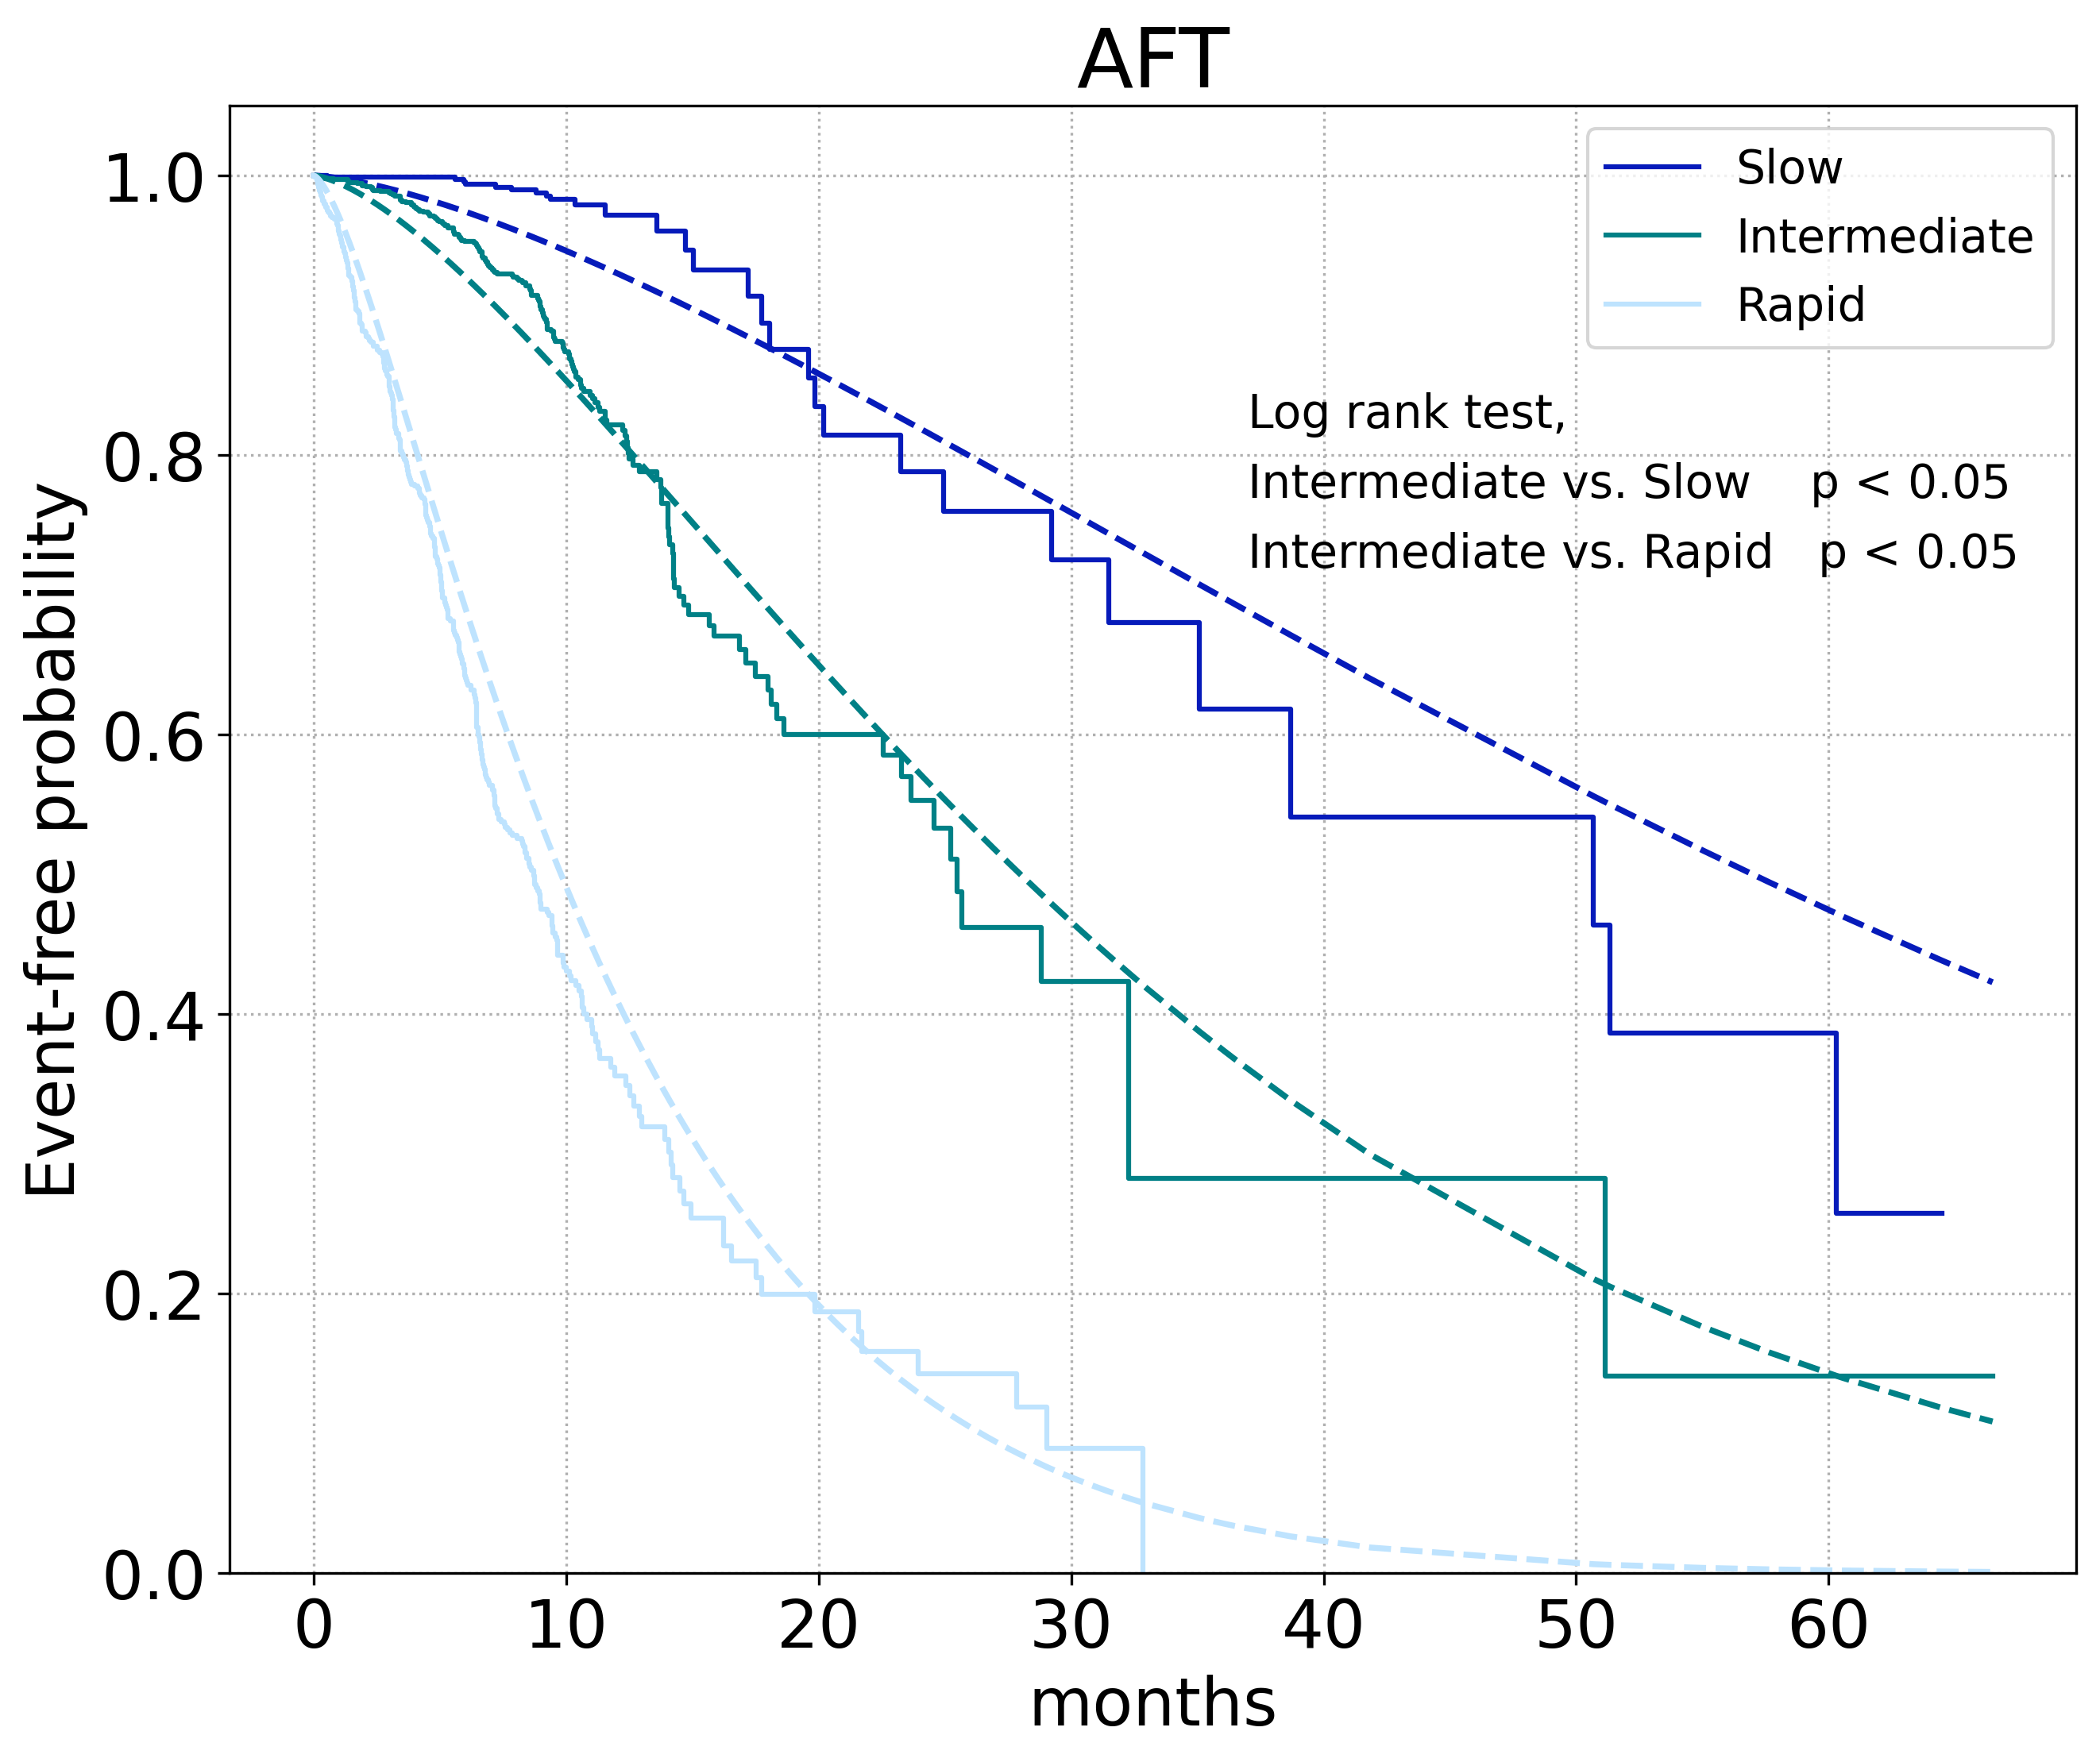

In [ ]:
from lifelines import KaplanMeierFitter
from scipy.stats import ranksums
from lifelines.statistics import logrank_test


kmf = KaplanMeierFitter()

plt.figure(figsize=(10,8))

OPT = kmf.fit(X_aft_slow["time_LOA"], X_aft_slow["status_LOA"], label='Slow', alpha=1)
ax_kmf = OPT.plot(color='#061BBA', linewidth=1.5)
plt.plot(result_aft_slow.index, result_aft_slow[0], marker='None', color='#061BBA', linestyle="--", linewidth=1.8)


OPT = kmf.fit(X_aft_intermediate["time_LOA"], X_aft_intermediate["status_LOA"], label='Intermediate', alpha=1)
ax_kmf = OPT.plot(color='#008086', linewidth=1.5)
plt.title("Intermediate")
plt.plot(result_aft_intermediate.index, result_aft_intermediate[0], marker='None', color='#008086', linestyle="--", linewidth=1.8)

OPT = kmf.fit(X_aft_rapid["time_LOA"], X_aft_rapid["status_LOA"], label='Rapid', alpha=1)
ax_kmf = OPT.plot(color='#BEE3FE', linewidth=1.5)
plt.plot(result_aft_rapid.index, result_aft_rapid[0], marker='None', color='#BEE3FE', linestyle="--", linewidth=1.8)
plt.ylim([0,1.05])

plt.xlabel('months', fontsize=20)
plt.ylabel('Event-free probability', fontsize=20)
plt.xticks(fontsize=20)
plt.grid(linestyle=':')
plt.yticks(fontsize=20)
plt.title('AFT', fontsize=25)

# Calculate log-rank test p-value
log_rank_result_si = logrank_test(X_aft_slow["time_LOA"], X_aft_intermediate["time_LOA"], X_aft_slow["status_LOA"], X_aft_intermediate["status_LOA"])
log_rank_result_ir = logrank_test(X_aft_intermediate["time_LOA"], X_aft_rapid["time_LOA"], X_aft_intermediate["status_LOA"], X_aft_rapid["status_LOA"])

# Format the p-values as "p < 0.05" if they are less than 0.05
formatted_p_value_si = f'p < 0.05' if log_rank_result_si.p_value < 0.05 else f'p = {log_rank_result_si.p_value:.4f}'
formatted_p_value_ir = f'p < 0.05' if log_rank_result_ir.p_value < 0.05 else f'p = {log_rank_result_ir.p_value:.4f}'

# Add the p-values as annotations to the plots
plt.annotate('Log rank test,', xy=(37, 0.82), color='k', fontsize=14)
plt.annotate(f'Intermediate vs. Slow    {formatted_p_value_si}', xy=(37,0.77), color='k', fontsize=14)
plt.annotate(f'Intermediate vs. Rapid   {formatted_p_value_ir}', xy=(37,0.72), color='k', fontsize=14)


plt.show()

## COX

### (1) Categorizing patient data

In [ ]:
cph_median = pd.concat([df_train_imputed['SubjectID'],cph.predict_percentile(df_train_imputed[cph_final_feature_list], p=0.5)], axis=1)
cph_median

SubjectID    0.5
0         348.0  50.69
1         533.0   6.21
2         902.0  24.95
3        1736.0  14.03
4        3971.0  51.15
...         ...    ...
3391   998491.0  25.47
3392   999166.0  32.84
3393   999522.0  35.07
3394   999823.0  16.23
3395   999990.0  17.12

[3396 rows x 2 columns]

In [ ]:
print('There are ' + str(cph_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in cph_median')

There are 195 inf values in cph_median


In [ ]:
cph_infinity = list(cph_median[cph_median[0.5]==np.inf]['SubjectID'])

In [ ]:
function = pd.concat([df_train_imputed['SubjectID'],aft.predict_survival_function(df_train_imputed[aft_final_feature_list]).transpose()], axis=1)
last_point= function.iloc[:, [0,-1]]
last_point[0.5] = (0.5*last_point.columns[1])/(1-last_point.iloc[:,1])
cph_median_inf = last_point[last_point['SubjectID'].isin(cph_infinity)][['SubjectID',0.5]]
cph_median_inf

<ipython-input-44-a6fb3d7ca8fe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_point[0.5] = (0.5*last_point.columns[1])/(1-last_point.iloc[:,1])


SubjectID         0.5
26       9641.0   78.431366
32      10995.0  120.710126
35      11813.0   83.279245
41      13109.0   79.506464
60      17390.0   92.006599
...         ...         ...
3292   969067.0  168.501919
3313   974136.0   82.995918
3360   990061.0   72.684912
3361   990402.0   94.409133
3369   992110.0   76.813665

[195 rows x 2 columns]

In [ ]:
cph_median = pd.concat([cph_median[cph_median[0.5]!=np.inf],cph_median_inf], axis=0)
cph_median

SubjectID         0.5
0         348.0   50.690000
1         533.0    6.210000
2         902.0   24.950000
3        1736.0   14.030000
4        3971.0   51.150000
...         ...         ...
3292   969067.0  168.501919
3313   974136.0   82.995918
3360   990061.0   72.684912
3361   990402.0   94.409133
3369   992110.0   76.813665

[3396 rows x 2 columns]

In [ ]:
print('There are ' + str(cph_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in cph_median after extension')

There are 0 inf values in cph_median after extension


In [ ]:
cph_median[0.5].describe()

count      3396.000000
mean         77.501458
std        2503.975654
min           2.030000
25%          16.230000
50%          32.280000
75%          50.690000
max      145914.989379
Name: 0.5, dtype: float64

In [ ]:
cph_slow_list = list(cph_median[cph_median[0.5] >= 	50.690000]['SubjectID'])
cph_intermediate_list = list(cph_median[(cph_median[0.5] >  16.230000) & (cph_median[0.5] < 	50.690000)]['SubjectID'])
cph_rapid_list = list(cph_median[cph_median[0.5]  <=  16.230000]['SubjectID'])
X_cph_slow = df_train_imputed[df_train_imputed['SubjectID'].isin(cph_slow_list)]
X_cph_intermediate = df_train_imputed[df_train_imputed['SubjectID'].isin(cph_intermediate_list)]
X_cph_rapid = df_train_imputed[df_train_imputed['SubjectID'].isin(cph_rapid_list)]

In [ ]:
print(len(cph_slow_list))
print(len(cph_intermediate_list))
print(len(cph_rapid_list))

869
1662
865


In [ ]:
result_cph_slow = pd.DataFrame(cph.predict_survival_function(X_cph_slow[cph_final_feature_list].iloc[:,:]).mean(axis=1))
result_cph_intermediate = pd.DataFrame(cph.predict_survival_function(X_cph_intermediate[cph_final_feature_list].iloc[:,:]).mean(axis=1))
result_cph_rapid = pd.DataFrame(cph.predict_survival_function(X_cph_rapid[cph_final_feature_list].iloc[:,:]).mean(axis=1))

### (2) Plot

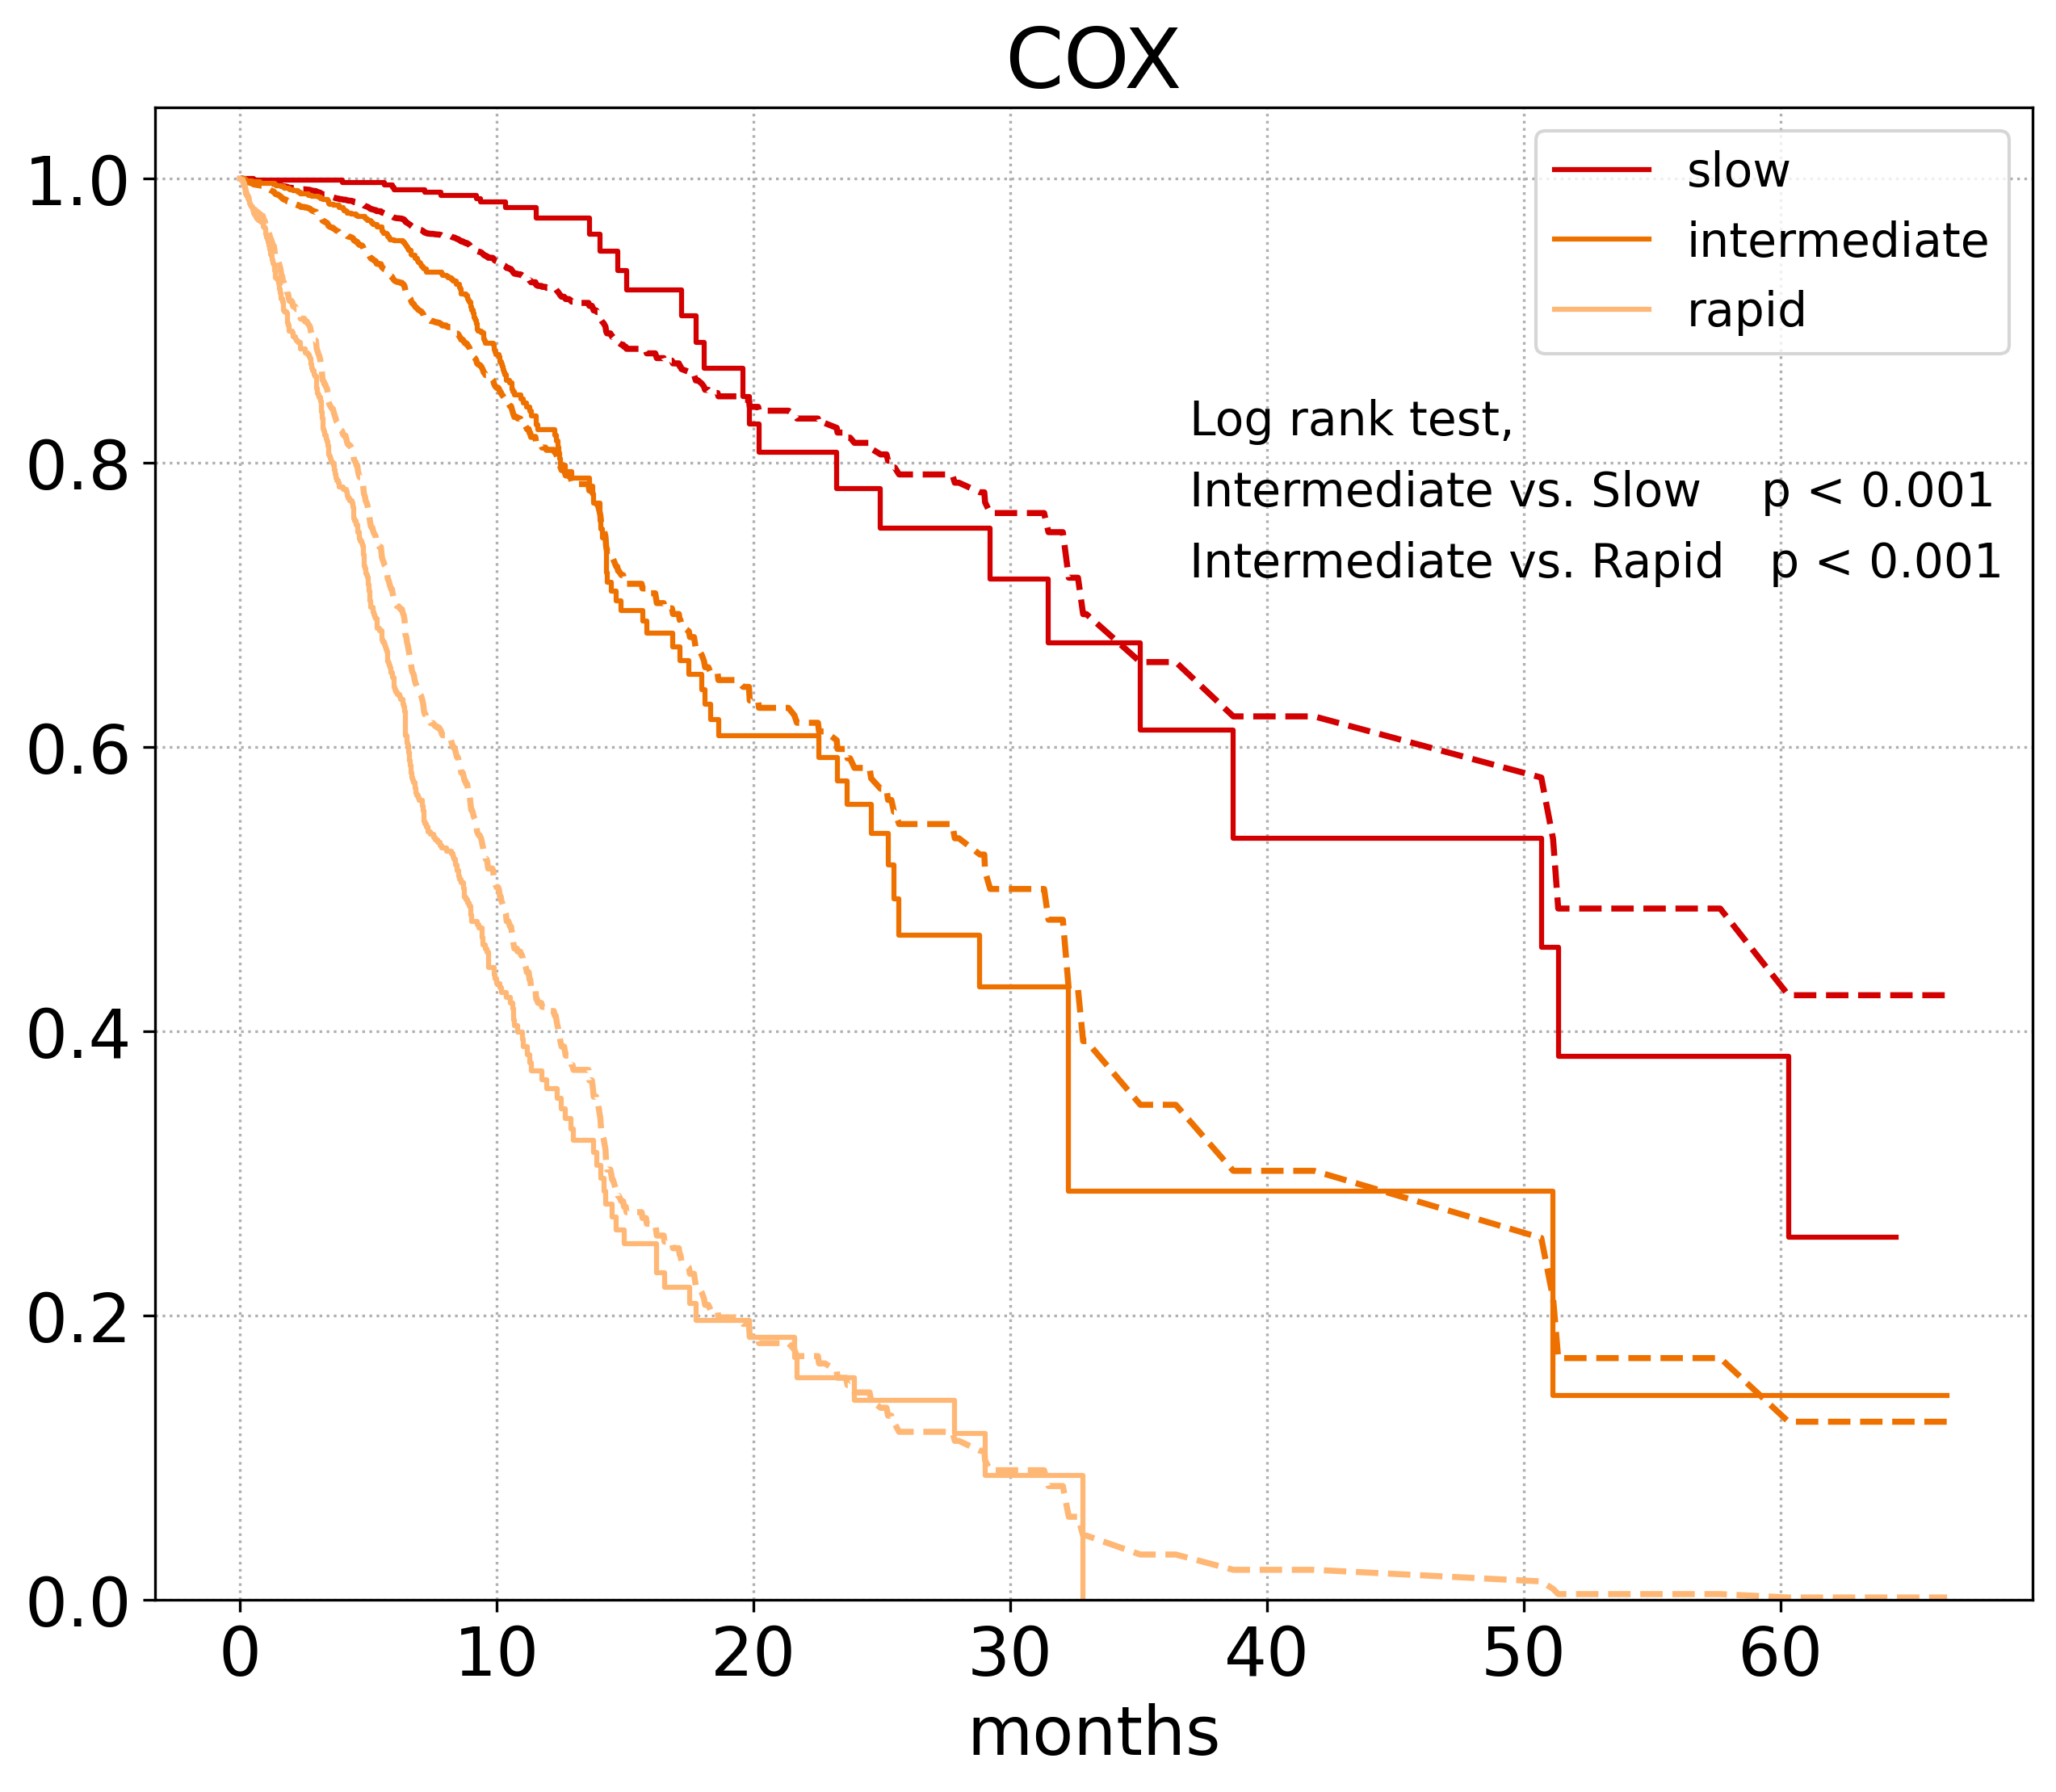

In [ ]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,8))

OPT = kmf.fit(X_cph_slow["time_LOA"], X_cph_slow["status_LOA"], label='slow', alpha=1)
ax_kmf = OPT.plot(color='#D20000', linewidth=1.5)
plt.plot(result_cph_slow.index, result_cph_slow[0], marker='None', color='#D20000', linestyle="--", linewidth=1.8)


OPT = kmf.fit(X_cph_intermediate["time_LOA"], X_cph_intermediate["status_LOA"], label='intermediate', alpha=1)
ax_kmf = OPT.plot(color='#EE7100', linewidth=1.5)
plt.title("Intermediate")
plt.plot(result_cph_intermediate.index, result_cph_intermediate[0], marker='None', color='#EE7100', linestyle="--", linewidth=1.8)

OPT = kmf.fit(X_cph_rapid["time_LOA"], X_cph_rapid["status_LOA"], label='rapid', alpha=1)
ax_kmf = OPT.plot(color='#FFB775', linewidth=1.5)
plt.plot(result_cph_rapid.index, result_cph_rapid[0], marker='None', color='#FFB775', linestyle="--", linewidth=1.8)

# Calculate log-rank test p-value
log_rank_result_si = logrank_test(X_cph_slow["time_LOA"], X_cph_intermediate["time_LOA"], X_cph_slow["status_LOA"], X_cph_intermediate["status_LOA"])
log_rank_result_ir = logrank_test(X_cph_intermediate["time_LOA"], X_cph_rapid["time_LOA"], X_cph_intermediate["status_LOA"], X_cph_rapid["status_LOA"])

# Format the p-values as "p < 0.001" if they are less than 0.001
formatted_p_value_si = f'p < 0.001' if log_rank_result_si.p_value < 0.001 else f'p = {log_rank_result_si.p_value:.4f}'
formatted_p_value_ir = f'p < 0.001' if log_rank_result_ir.p_value < 0.001 else f'p = {log_rank_result_ir.p_value:.4f}'

# Add the p-values as annotations to the plots
plt.annotate('Log rank test,', xy=(37, 0.82), color='k', fontsize=14)
plt.annotate(f'Intermediate vs. Slow    {formatted_p_value_si}', xy=(37,0.77), color='k', fontsize=14)
plt.annotate(f'Intermediate vs. Rapid   {formatted_p_value_ir}', xy=(37,0.72), color='k', fontsize=14)

plt.ylim([0,1.05])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('months', fontsize=20)
plt.grid(linestyle=':')
plt.title('COX', fontsize=25)

plt.show()

## RSF

### (1) Categorizing patient data

In [ ]:
def predict_rsf_percentile(data, percentile):
  result = rsf.predict_survival_function(data.to_numpy().reshape(1, -1), return_array = True)
  result = np.squeeze(result)
  time_result = pd.DataFrame({'time' : rsf.event_times_, 'p' : result })

  if time_result[time_result['p'] <= percentile].count()['time'] == 0:
    per = np.inf
  else:
    per = time_result[time_result['p'] <= percentile].iloc[0,0]

  return per

In [ ]:
# Extract 50% probability time
# CAUTION! Runtime takes 1 min
rsf_50_list = []
for i in range(df_train_imputed_rsf[rsf_final_feature_list].shape[0]):
  rsf_50_list.append(predict_rsf_percentile(df_train_imputed_rsf[rsf_final_feature_list].iloc[i,:], 0.5))

rsf_50_list

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/b

[50.69,
 6.44,
 inf,
 9.23,
 inf,
 10.81,
 14.29,
 23.66,
 13.77,
 38.69,
 9.56,
 9.43,
 inf,
 3.71,
 8.28,
 15.84,
 inf,
 32.28,
 38.69,
 12.25,
 inf,
 inf,
 inf,
 inf,
 7.16,
 inf,
 inf,
 inf,
 inf,
 14.03,
 inf,
 60.32,
 inf,
 inf,
 11.93,
 14.65,
 inf,
 inf,
 inf,
 14.65,
 inf,
 inf,
 inf,
 13.9,
 38.69,
 inf,
 8.51,
 14.06,
 14.03,
 9.23,
 21.69,
 6.699999999999999,
 11.04,
 16.86,
 10.61,
 10.18,
 inf,
 18.11,
 21.69,
 inf,
 inf,
 inf,
 38.69,
 32.28,
 inf,
 16.23,
 11.04,
 inf,
 inf,
 inf,
 11.93,
 16.23,
 inf,
 7.16,
 14.260000000000002,
 23.93,
 inf,
 inf,
 inf,
 10.61,
 inf,
 7.19,
 10.12,
 inf,
 16.53,
 inf,
 inf,
 inf,
 inf,
 12.45,
 18.34,
 32.28,
 16.86,
 inf,
 inf,
 inf,
 inf,
 inf,
 4.79,
 inf,
 inf,
 inf,
 inf,
 inf,
 3.21,
 25.24,
 inf,
 14.06,
 inf,
 51.15,
 6.44,
 7.16,
 inf,
 inf,
 inf,
 8.28,
 23.27,
 27.84,
 5.75,
 inf,
 inf,
 inf,
 25.47,
 inf,
 32.28,
 inf,
 6.5,
 inf,
 16.23,
 5.19,
 8.7,
 inf,
 10.28,
 inf,
 inf,
 11.76,
 24.95,
 inf,
 9.89,
 11.01,
 4.63,
 i

In [ ]:
subjectID = df_train_imputed_rsf['SubjectID'].copy()
subjectID.index = range(len(subjectID))
subjectID

0          348.0
1          533.0
2          902.0
3         1736.0
4         3971.0
          ...   
3391    998491.0
3392    999166.0
3393    999522.0
3394    999823.0
3395    999990.0
Name: SubjectID, Length: 3396, dtype: float64

In [ ]:
rsf_median = pd.concat([subjectID, pd.Series(rsf_50_list)], axis=1)
rsf_median

SubjectID      0
0         348.0  50.69
1         533.0   6.44
2         902.0    inf
3        1736.0   9.23
4        3971.0    inf
...         ...    ...
3391   998491.0  24.95
3392   999166.0    inf
3393   999522.0  51.35
3394   999823.0  11.53
3395   999990.0  14.06

[3396 rows x 2 columns]

In [ ]:
# Check how many subjects have infinity values on median prob time
print('There are ' + str(rsf_median.replace([np.inf,-np.inf
], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in rsf_median')
# There are 1490 inf values in rsf_median

There are 1490 inf values in rsf_median


In [ ]:
rsf_infinity = list(rsf_median[rsf_median[0]==np.inf]['SubjectID'])

In [ ]:
rsf_function1 = pd.DataFrame(np.squeeze(rsf.predict_survival_function(df_train_imputed_rsf[rsf_final_feature_list].iloc[:, :].to_numpy(), return_array = True)))
rsf_function1.columns = rsf.event_times_
rsf_function1

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(


0.02      0.12      0.16      0.19      0.22      0.25      0.29   \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.998276  0.996573  0.990702  0.990702  0.989562  0.987948  0.980345   
2     1.000000  0.999117  0.999117  0.999117  0.999117  0.999117  0.999117   
3     1.000000  1.000000  1.000000  0.999145  0.997710  0.995033  0.995033   
4     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
...        ...       ...       ...       ...       ...       ...       ...   
3391  1.000000  1.000000  0.999667  0.999667  0.999250  0.999250  0.999250   
3392  1.000000  1.000000  0.999000  0.999000  0.999000  0.999000  0.999000   
3393  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
3394  1.000000  0.998869  0.998869  0.998869  0.997397  0.994287  0.994287   
3395  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

         0.32      0.35      0.39   ...     29.22     31.49     32.28  \
0     1.000000  1.000000  1.000000  ...  0.554910  0.554910  0.553732   
1     0.980345  0.974118  0.974118  ...  0.196232  0.196232  0.196232   
2     0.999117  0.999117  0.999117  ...  0.684476  0.684476  0.646976   
3     0.995033  0.995033  0.993277  ...  0.221547  0.221547  0.221547   
4     1.000000  1.000000  1.000000  ...  0.729563  0.729563  0.729563   
...        ...       ...       ...  ...       ...       ...       ...   
3391  0.998917  0.998917  0.998917  ...  0.494767  0.494767  0.494767   
3392  0.999000  0.999000  0.999000  ...  0.557153  0.542653  0.527653   
3393  1.000000  1.000000  1.000000  ...  0.855572  0.855572  0.809899   
3394  0.994287  0.993156  0.990097  ...  0.288320  0.288320  0.288320   
3395  0.999630  0.999630  0.999630  ...  0.262210  0.262210  0.262210   

         32.84     35.07     38.69     50.69     51.15     51.35     60.32  
0     0.553732  0.510150  0.500150  0.476968  0.476968  0.439612  0.415729  
1     0.191668  0.191668  0.191668  0.191668  0.191668  0.191668  0.191668  
2     0.646976  0.643865  0.643865  0.643865  0.643865  0.643865  0.643865  
3     0.213392  0.213392  0.213392  0.213392  0.213392  0.213392  0.213392  
4     0.729563  0.703628  0.703628  0.685242  0.685242  0.654848  0.646651  
...        ...       ...       ...       ...       ...       ...       ...  
3391  0.494767  0.494767  0.494767  0.494767  0.494767  0.494767  0.494767  
3392  0.527653  0.527653  0.527653  0.527653  0.527653  0.527653  0.527653  
3393  0.809899  0.698639  0.698639  0.535822  0.535822  0.435840  0.414384  
3394  0.263581  0.263581  0.263581  0.263581  0.263581  0.263581  0.263581  
3395  0.262210  0.262210  0.262210  0.262210  0.262210  0.262210  0.262210  

[3396 rows x 328 columns]

In [ ]:
rsf_function2 = pd.concat([df_train_imputed_rsf['SubjectID'],rsf_function1], axis=1)
last_point_rsf= rsf_function2.iloc[:, [0,-1]]
last_point_rsf[0] = (0.5*last_point_rsf.columns[1])/(1-last_point_rsf.iloc[:,1])
rsf_median_inf = last_point_rsf[last_point_rsf['SubjectID'].isin(rsf_infinity)][['SubjectID',0]]
rsf_median_inf

<ipython-input-71-1573aa8fe90a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_point_rsf[0] = (0.5*last_point_rsf.columns[1])/(1-last_point_rsf.iloc[:,1])


SubjectID           0
2         902.0   84.687085
4        3971.0   85.354761
12       5918.0   74.038069
16       7750.0  168.670357
20       8227.0  130.769055
...         ...         ...
3383   995584.0   87.287590
3385   996351.0  115.396148
3386   996611.0   68.202835
3388   996808.0   90.010169
3392   999166.0   63.851378

[1490 rows x 2 columns]

In [ ]:
rsf_median = pd.concat([rsf_median[rsf_median[0]!=np.inf],rsf_median_inf], axis=0)
rsf_median

SubjectID           0
0         348.0   50.690000
1         533.0    6.440000
3        1736.0    9.230000
5        4096.0   10.810000
6        4752.0   14.290000
...         ...         ...
3383   995584.0   87.287590
3385   996351.0  115.396148
3386   996611.0   68.202835
3388   996808.0   90.010169
3392   999166.0   63.851378

[3396 rows x 2 columns]

In [ ]:
print('There are ' + str(rsf_median.replace([np.inf,-np.inf], np.nan).isnull().sum(axis = 0).iloc[1]) + ' inf values in rsf_median after extension')

There are 0 inf values in rsf_median after extension


In [ ]:
rsf_median.describe()

SubjectID            0
count    3396.000000  3396.000000
mean   500812.143110    52.330397
std    292343.373239    43.917027
min       348.000000     3.150000
25%    246706.250000    14.060000
50%    508982.000000    51.150000
75%    759176.750000    76.659658
max    999990.000000   358.445439

In [ ]:
# Categorize into 3 group based on interquartile range
rsf_slow_list = list(rsf_median[rsf_median[0] > 76.659658]['SubjectID'])
rsf_intermediate_list = list(rsf_median[(rsf_median[0] > 14.060000) & (rsf_median[0] <= 76.659658)]['SubjectID'])
rsf_rapid_list = list(rsf_median[rsf_median[0]  <= 14.060000]['SubjectID'])
X_rsf_slow = df_train_imputed_rsf[df_train_imputed_rsf['SubjectID'].isin(rsf_slow_list)]
X_rsf_intermediate = df_train_imputed_rsf[df_train_imputed_rsf['SubjectID'].isin(rsf_intermediate_list)]
X_rsf_rapid = df_train_imputed_rsf[df_train_imputed_rsf['SubjectID'].isin(rsf_rapid_list)]

In [ ]:
rsf_pred_slow = np.squeeze(rsf.predict_survival_function(X_rsf_slow[rsf_final_feature_list].iloc[:, :].to_numpy(), return_array = True))
rsf_pred_intermediate = np.squeeze(rsf.predict_survival_function(X_rsf_intermediate[rsf_final_feature_list].iloc[:, :].to_numpy(), return_array = True))
rsf_pred_rapid = np.squeeze(rsf.predict_survival_function(X_rsf_rapid[rsf_final_feature_list].iloc[:, :].to_numpy(), return_array = True))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(


In [ ]:
result_rsf_slow = np.transpose(pd.DataFrame(rsf_pred_slow)).set_index(rsf.event_times_)
result_rsf_intermediate = np.transpose(pd.DataFrame(rsf_pred_intermediate)).set_index(rsf.event_times_)
result_rsf_rapid = np.transpose(pd.DataFrame(rsf_pred_rapid)).set_index(rsf.event_times_)

result_rsf_slow = pd.DataFrame(result_rsf_slow.mean(axis=1))
result_rsf_intermediate = pd.DataFrame(result_rsf_intermediate.mean(axis=1))
result_rsf_rapid =  pd.DataFrame(result_rsf_rapid.mean(axis=1))

In [ ]:
# How many data are uncensored? - RSF, slow group
print(len(X_cph_slow.query('status_LOA==1')), 'out of', len(X_rsf_slow))

30 out of 849


### (2) Plot

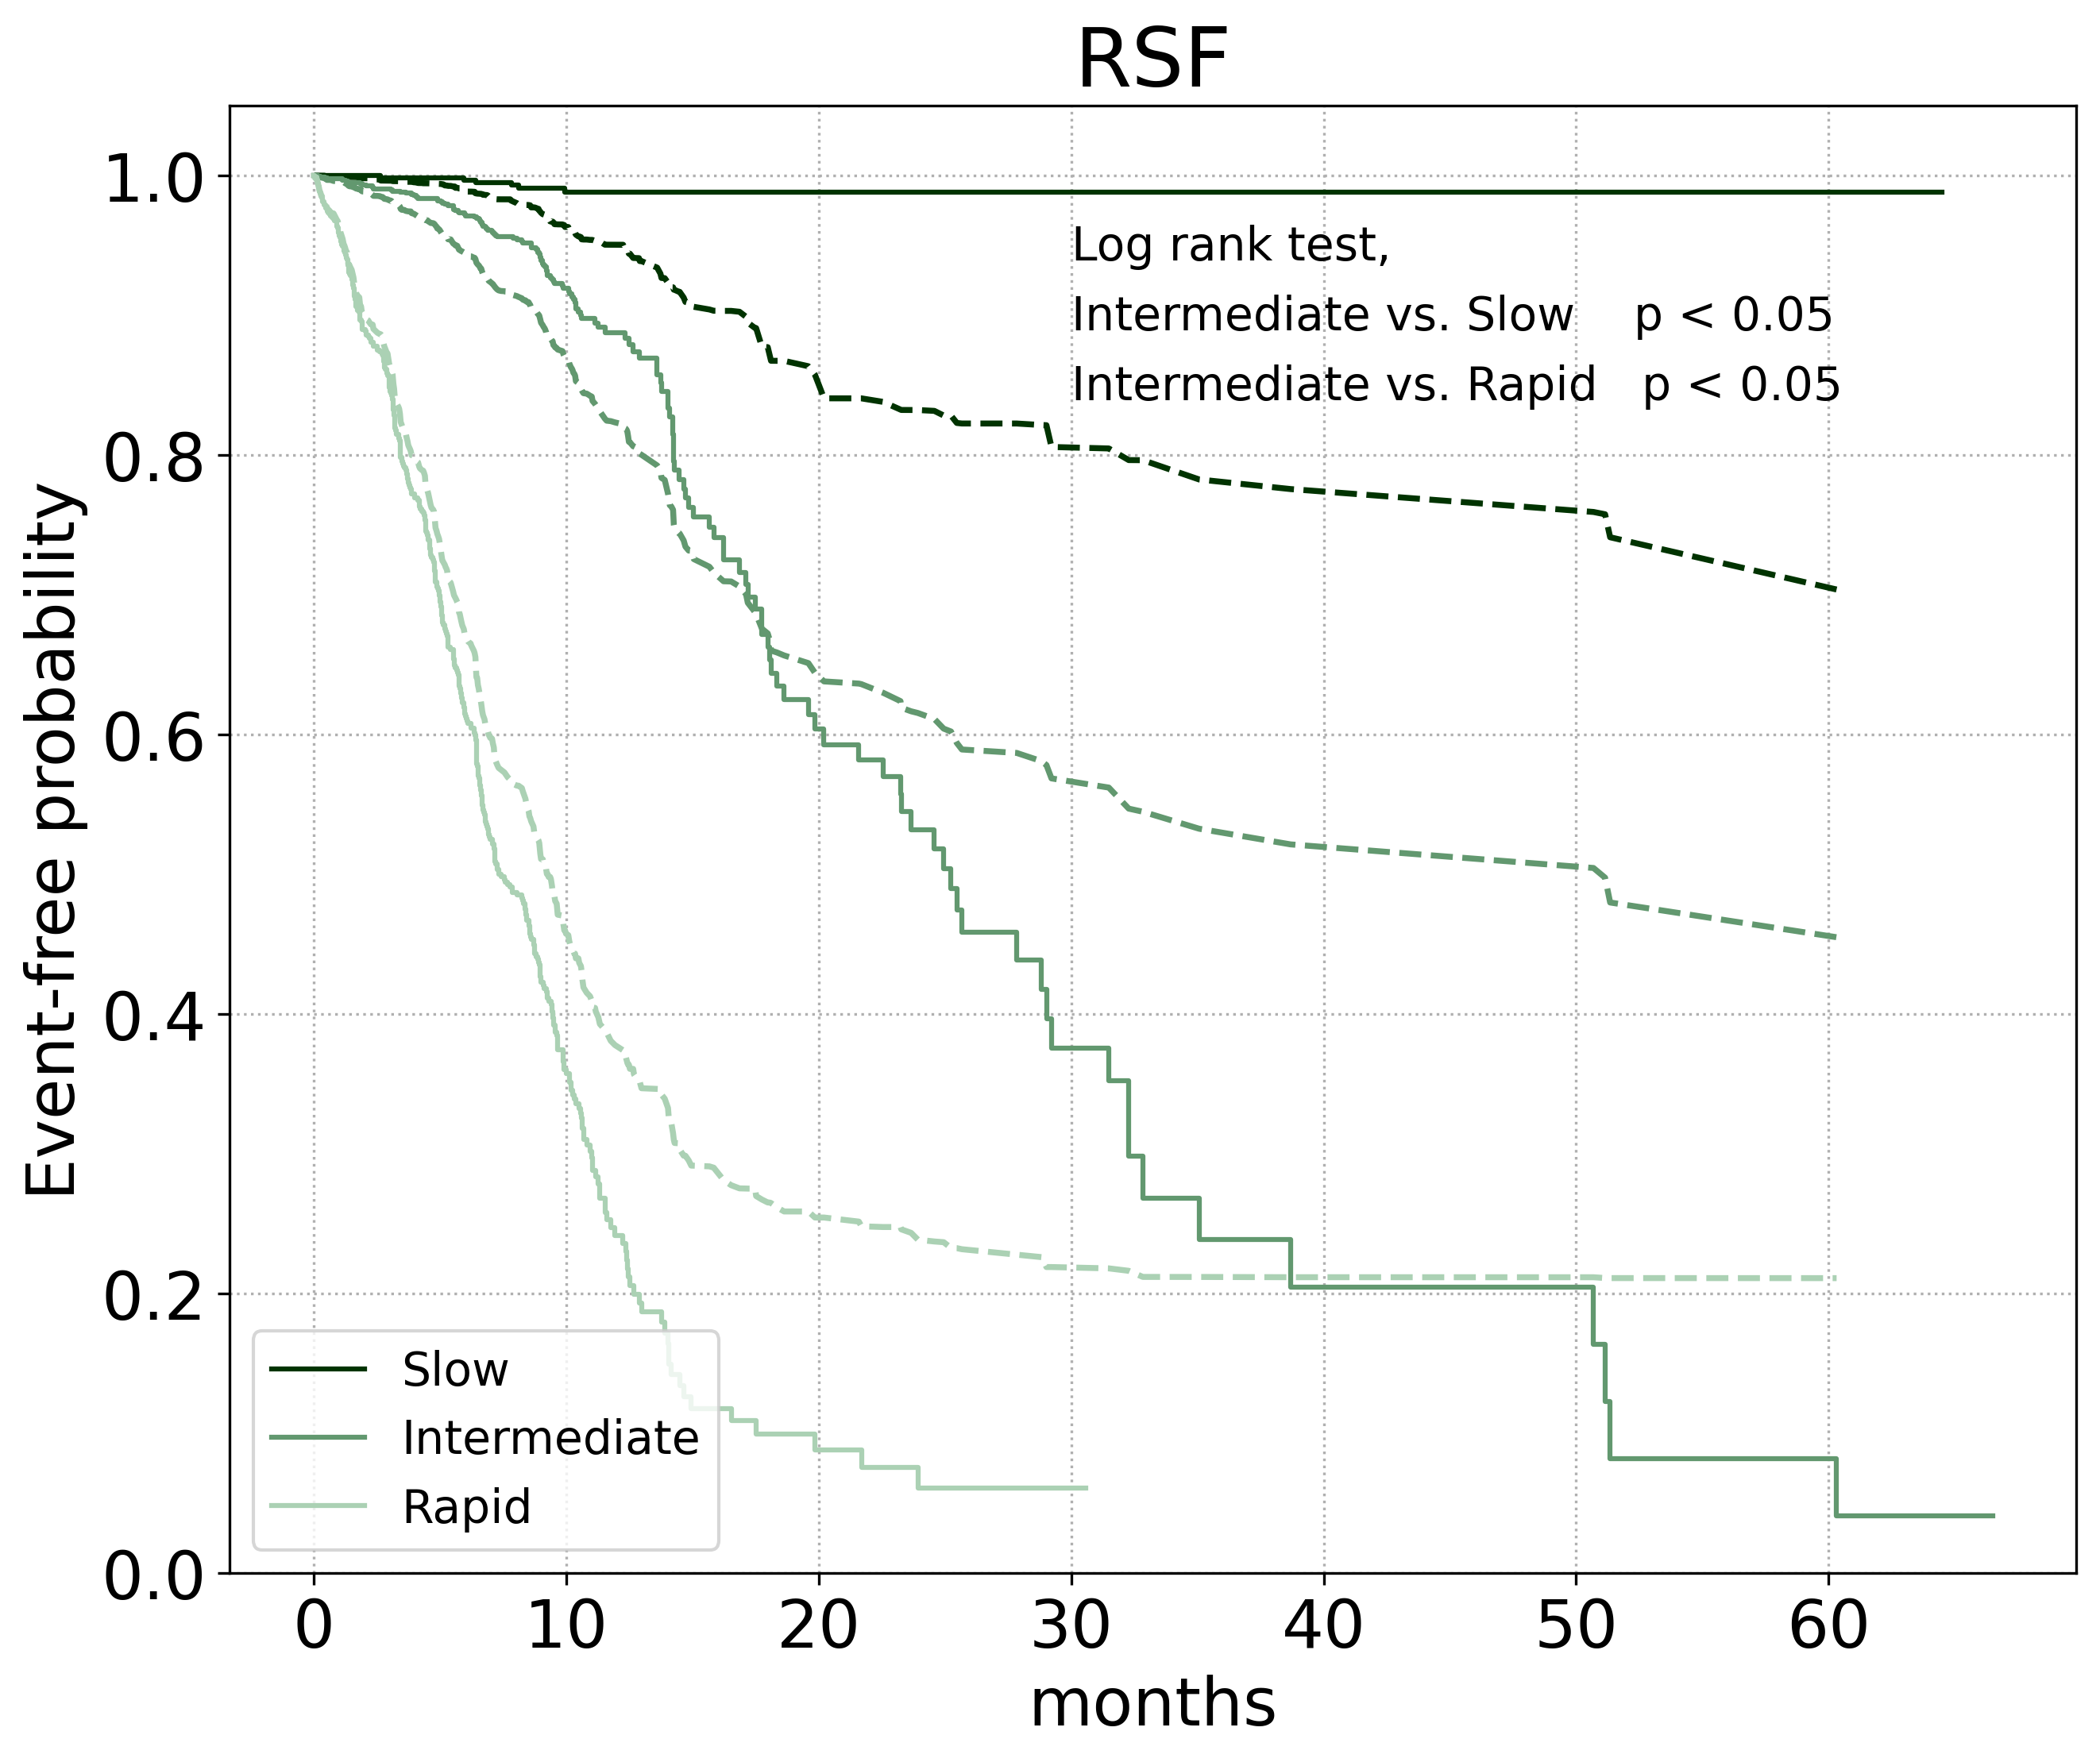

In [ ]:
# Compare KM curve and RSF-prediction curve in each group
# KM in solid lines, pred curve in dotted lines
plt.figure(figsize=(10,8))

OPT = kmf.fit(X_rsf_slow["time_LOA"], X_rsf_slow["status_LOA"], label='Slow', alpha=1)
ax_kmf = OPT.plot(color='#003300', linewidth=1.5)
plt.plot(result_rsf_slow.index, result_rsf_slow[0], marker='None', color='#003300', linestyle="--", linewidth=1.8)


OPT = kmf.fit(X_rsf_intermediate["time_LOA"], X_rsf_intermediate["status_LOA"], label='Intermediate', alpha=1)
ax_kmf = OPT.plot(color='#62986F', linewidth=1.5)
plt.title("Intermediate")
plt.plot(result_rsf_intermediate.index, result_rsf_intermediate[0], marker='None', color='#62986F', linestyle="--", linewidth=1.8)

OPT = kmf.fit(X_rsf_rapid["time_LOA"], X_rsf_rapid["status_LOA"], label='Rapid', alpha=1)
ax_kmf = OPT.plot(color='#ABD1B4', linewidth=1.5)
plt.plot(result_rsf_rapid.index, result_rsf_rapid[0], marker='None', color='#ABD1B4', linestyle="--", linewidth=1.8)

# Calculate log-rank test p-value
log_rank_result_si = logrank_test(X_rsf_slow["time_LOA"], X_rsf_intermediate["time_LOA"], X_rsf_slow["status_LOA"], X_rsf_intermediate["status_LOA"])
log_rank_result_ir = logrank_test(X_rsf_intermediate["time_LOA"], X_rsf_rapid["time_LOA"], X_rsf_intermediate["status_LOA"], X_rsf_rapid["status_LOA"])

# Format the p-values as "p < 0.05" if they are less than 0.05
formatted_p_value_si = f'p < 0.05' if log_rank_result_si.p_value < 0.05 else f'p = {log_rank_result_si.p_value:.4f}'
formatted_p_value_ir = f'p < 0.05' if log_rank_result_ir.p_value < 0.05 else f'p = {log_rank_result_ir.p_value:.4f}'

# Add the p-values as annotations to the plots
plt.annotate('Log rank test,', xy=(30, 0.94), color='k', fontsize=14)
plt.annotate(f'Intermediate vs. Slow    {formatted_p_value_si}', xy=(30,0.89), color='k', fontsize=14)
plt.annotate(f'Intermediate vs. Rapid   {formatted_p_value_ir}', xy=(30,0.84), color='k', fontsize=14)


plt.ylim([0,1.05])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.grid(linestyle=':')
plt.xlabel('months', fontsize=20)
plt.ylabel('Event-free probability', fontsize=20)
plt.title('RSF', fontsize=25)
plt.legend(loc='lower left')

plt.show()

### Slow group analysis

In [ ]:
print(len(X_aft_slow[X_aft_slow['status_LOA']==0]))
print(len(X_aft_slow))
print(len(X_cph_slow[X_cph_slow['status_LOA']==0]))
print(len(X_cph_slow))
print(len(X_rsf_slow[X_rsf_slow['status_LOA']==0]))
print(len(X_rsf_slow))

820
849
839
869
843
849


<ipython-input-177-8605ccbb21cd>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])


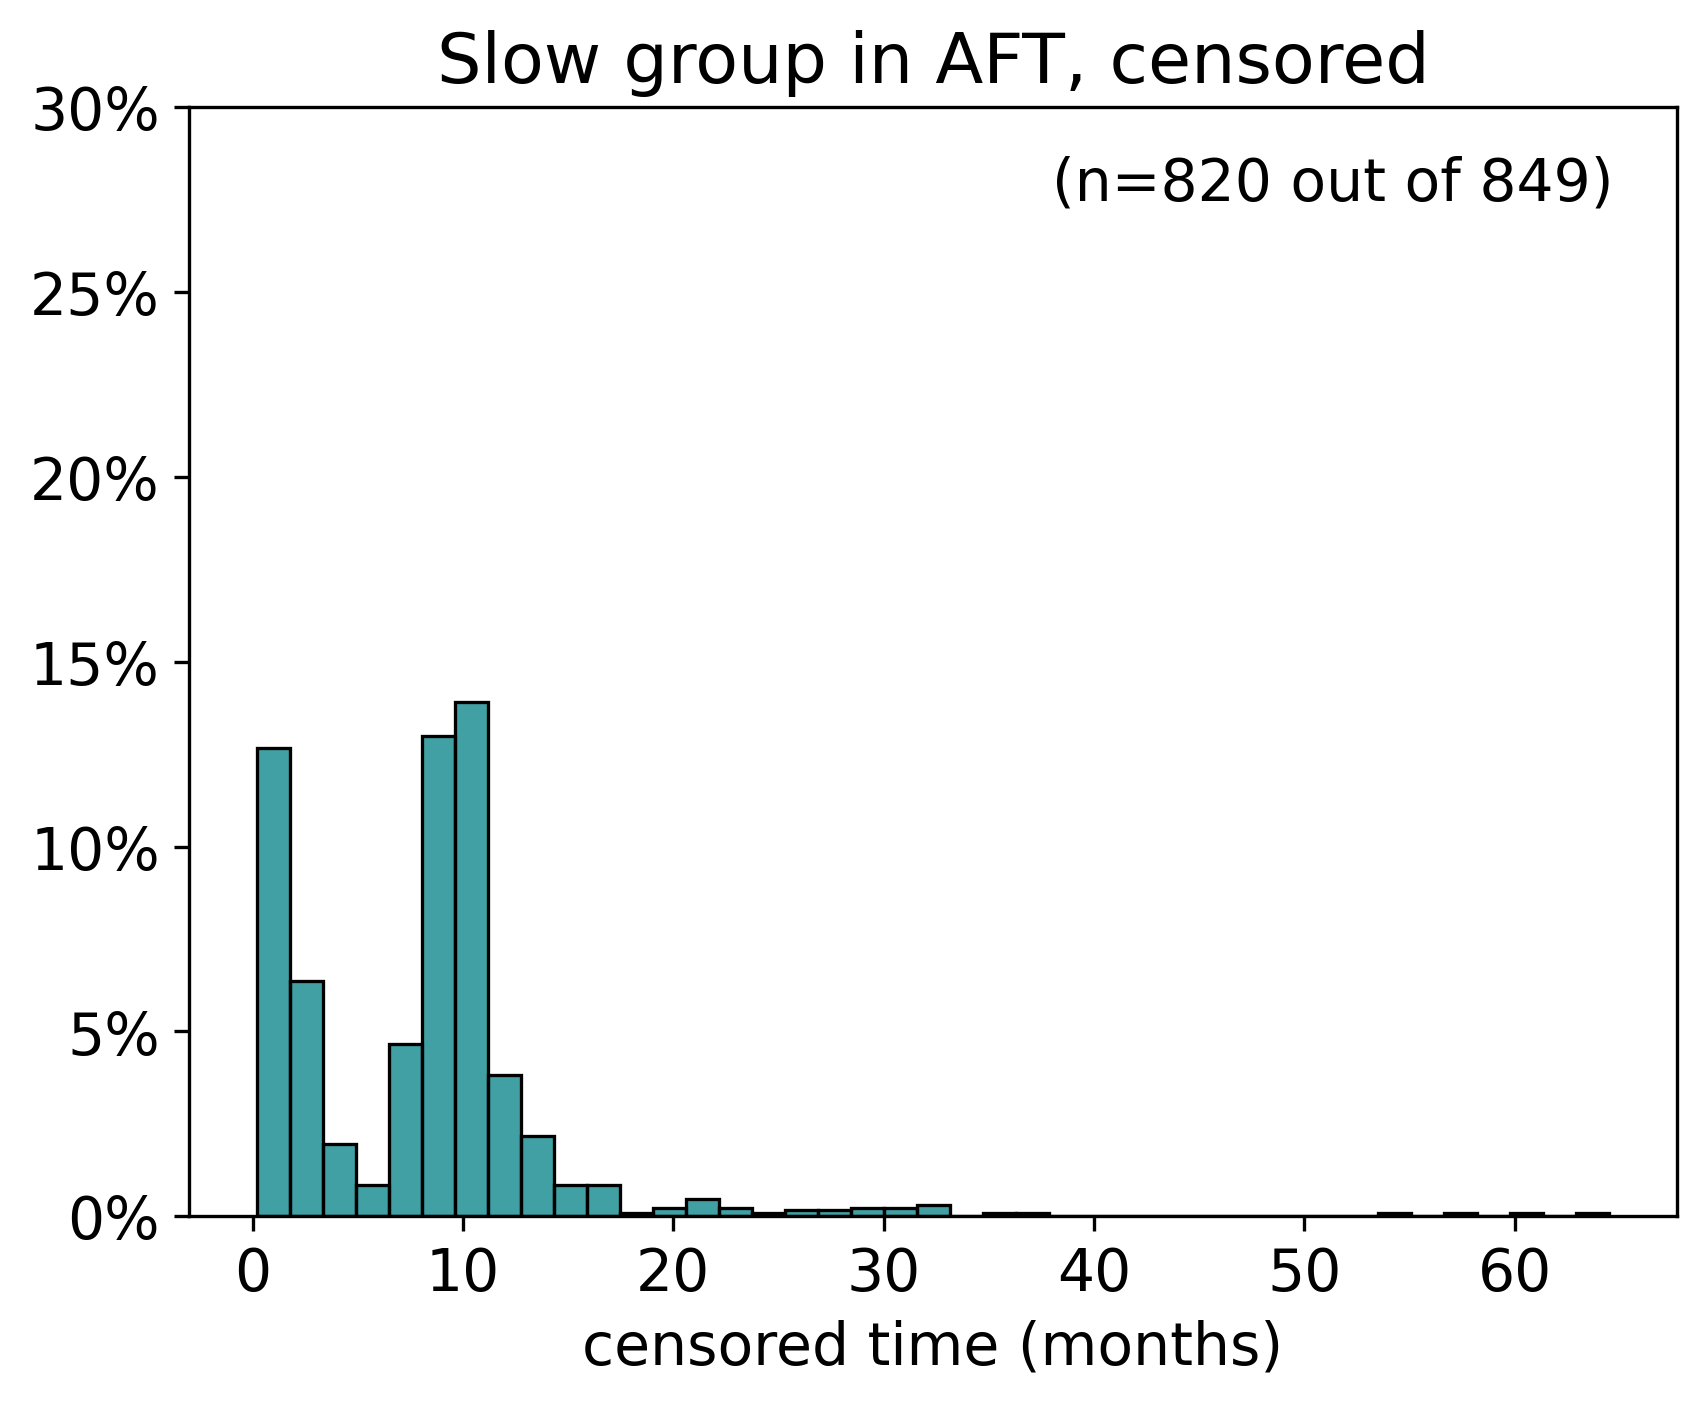

In [ ]:
ax=sns.histplot((X_aft_slow[X_aft_slow['status_LOA']==0]['time_LOA']), color='#008086',stat='density')
plt.xlabel('censored time (months)')
plt.title('Slow group in AFT, censored')
plt.ylabel('')
plt.ylim([0,0.3])
ax.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax.get_yticks()])
plt.annotate('(n=820 out of 849)', xy=(38,0.275), color='k', fontsize=14)

plt.show()

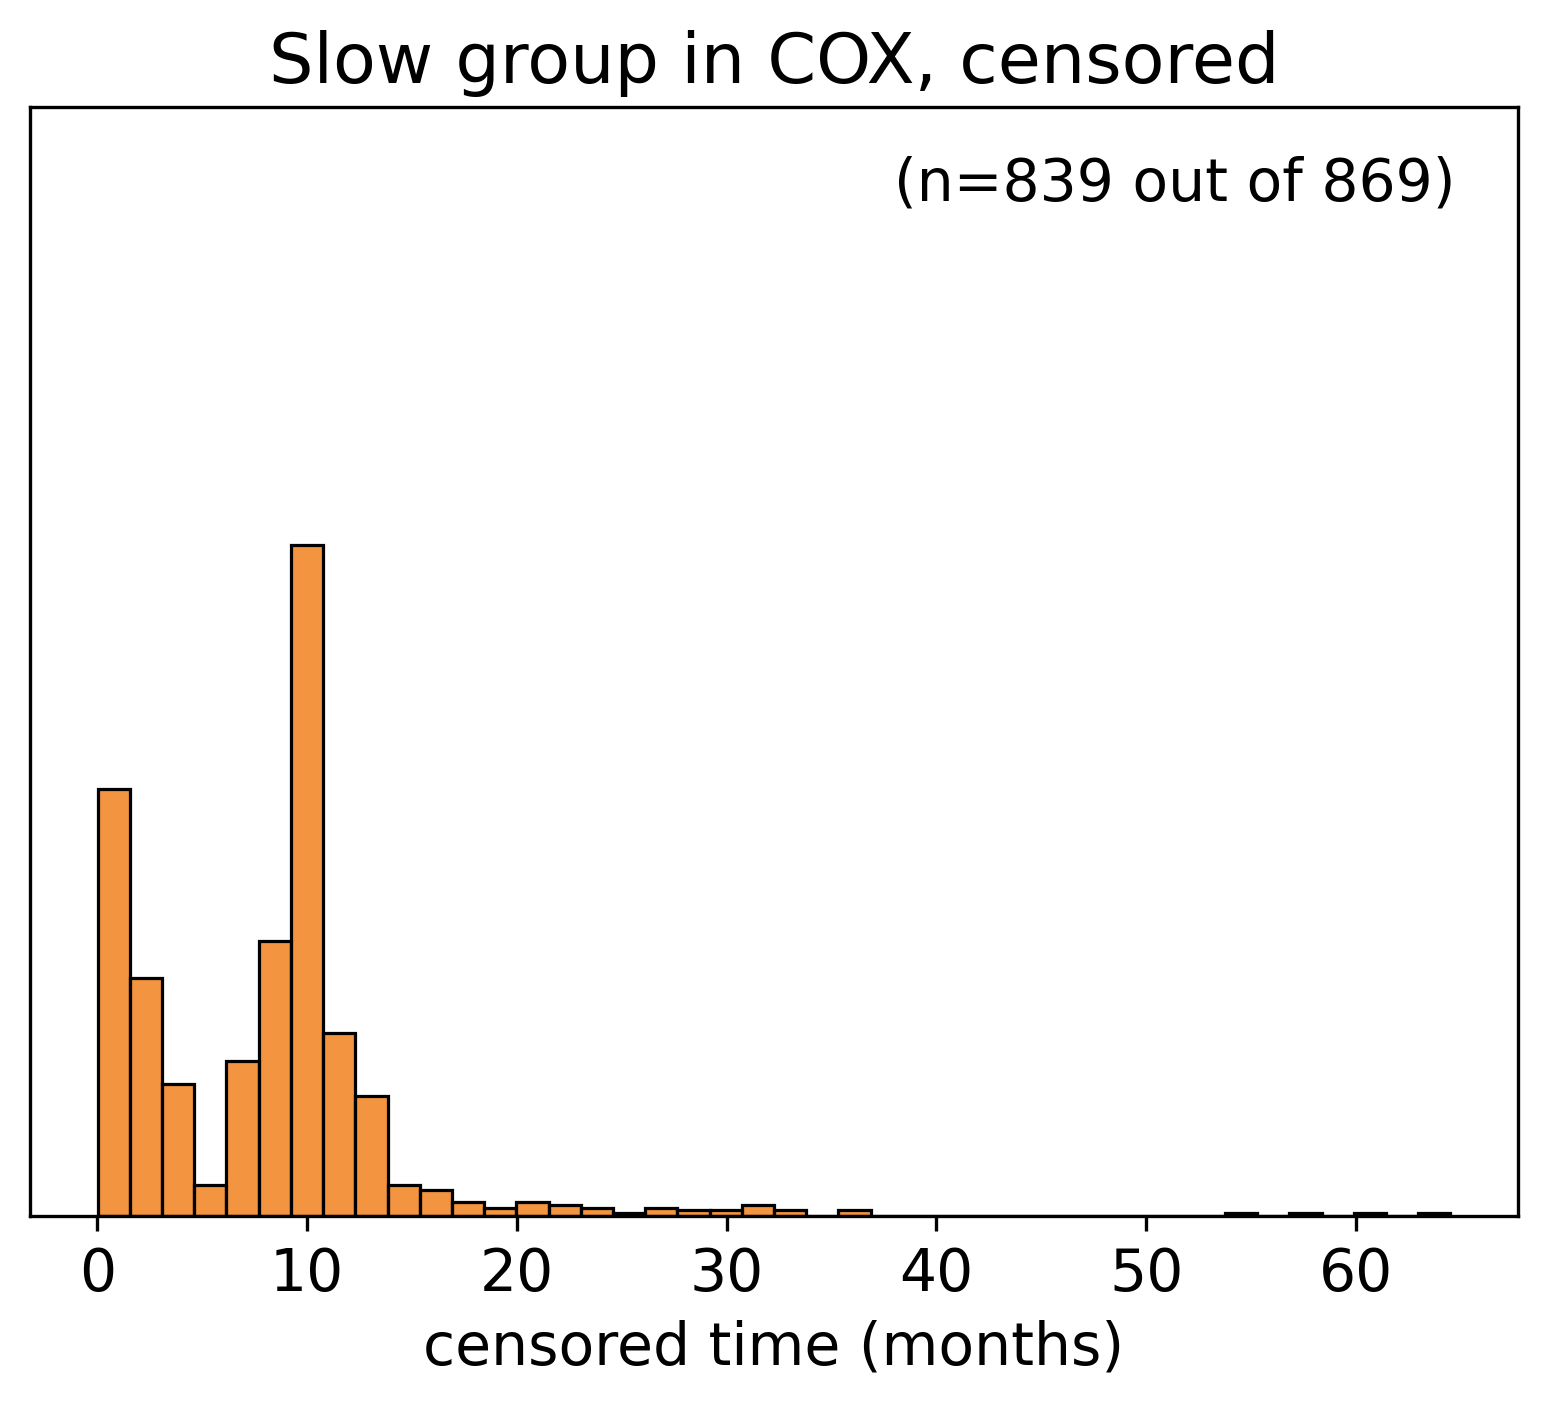

In [ ]:
ax2=sns.histplot(X_cph_slow[X_cph_slow['status_LOA']==0]['time_LOA'], color='#EE7100', stat='density')
plt.xlabel('censored time (months)')
plt.title('Slow group in COX, censored')
plt.ylabel('')
plt.ylim([0,0.3])
plt.yticks([])
ax2.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax2.get_yticks()])
plt.annotate('(n=839 out of 869)', xy=(38,0.275), color='k', fontsize=14)
plt.show()

Text(38, 0.275, '(n=843 out of 849)')

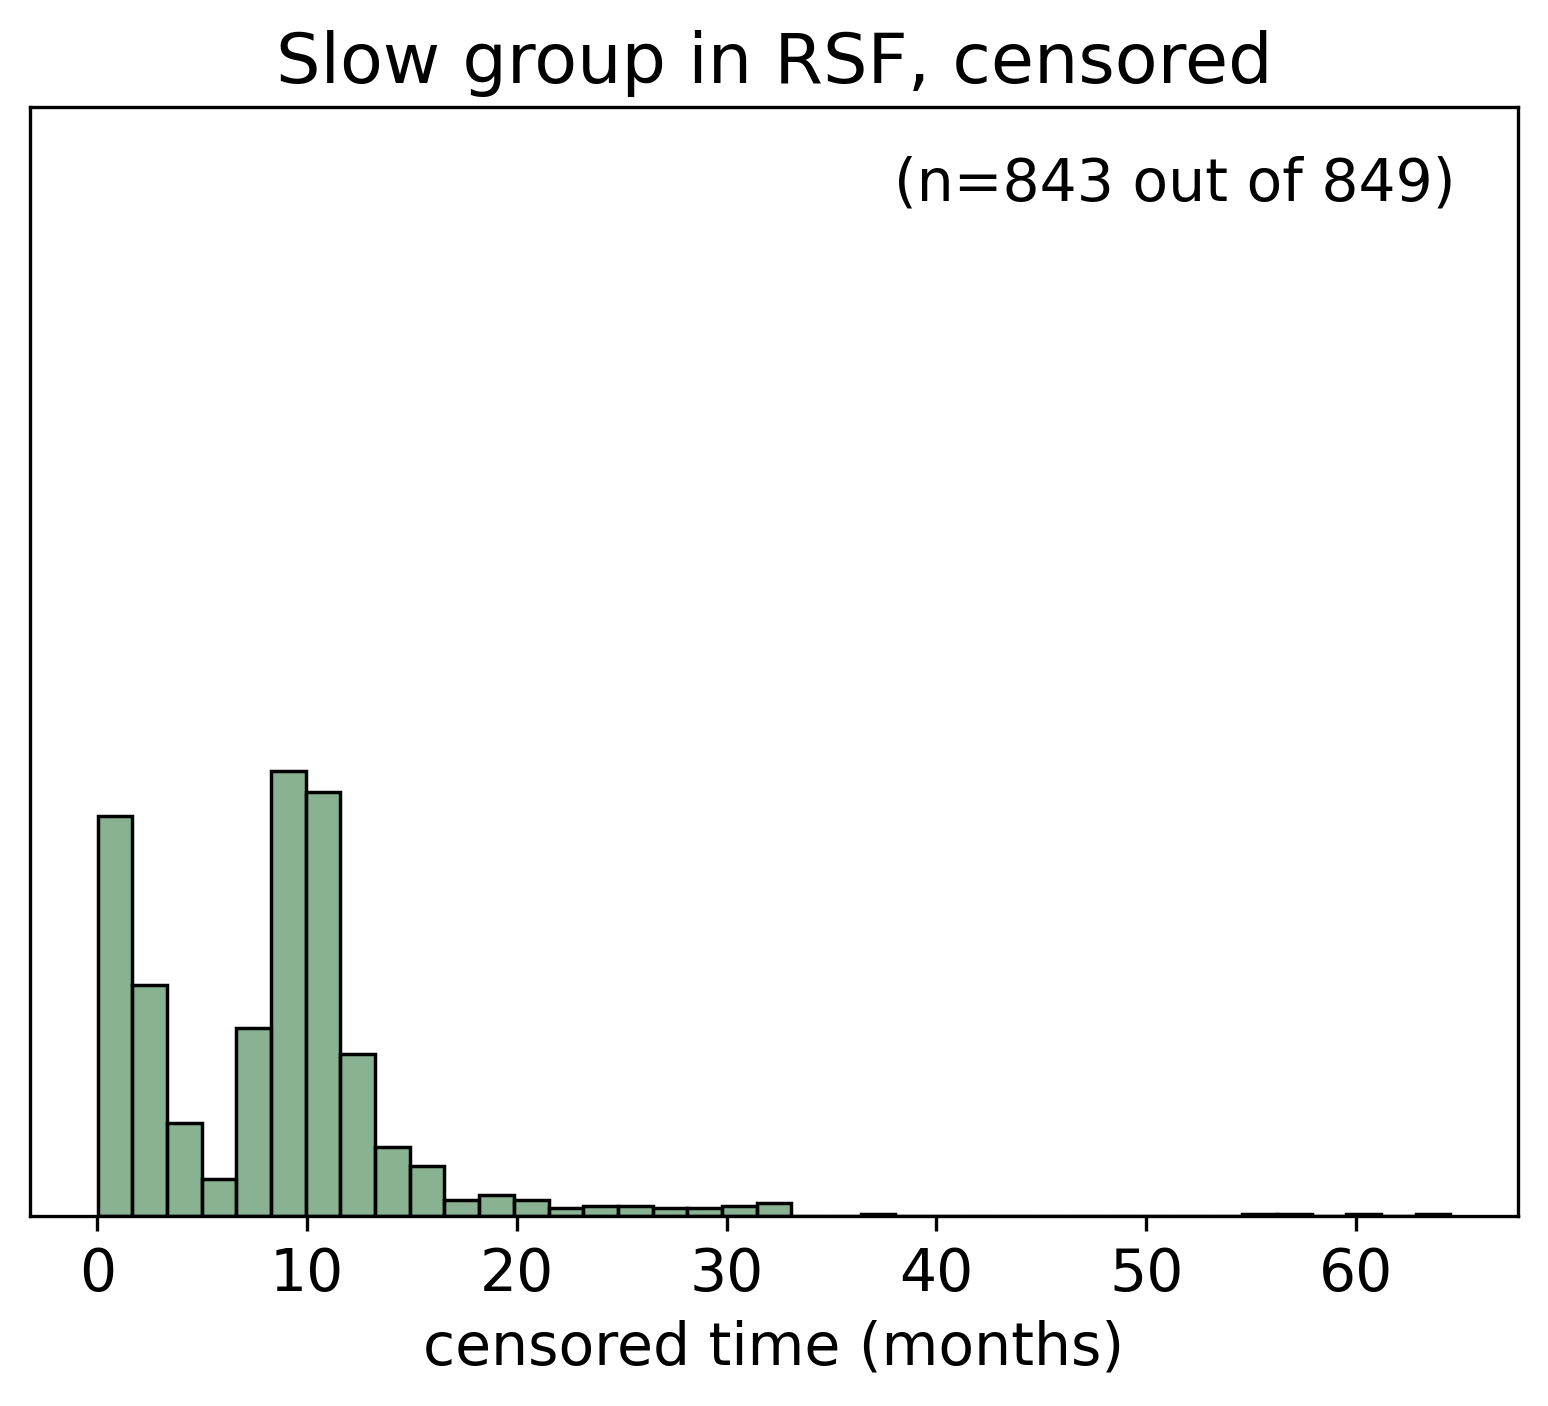

In [ ]:
ax3=sns.histplot(X_rsf_slow[X_rsf_slow['status_LOA']==0]['time_LOA'], color='#62986F', stat='density')
plt.xlabel('censored time (months)')
plt.title('Slow group in RSF, censored')
plt.ylabel('')
plt.ylim([0,0.3])
plt.yticks([])
ax3.set_yticklabels(['{:.0f}%'.format(y * 100) for y in ax3.get_yticks()])
plt.annotate('(n=843 out of 849)', xy=(38,0.275), color='k', fontsize=14)

In [ ]:
print(len(X_aft_slow[X_aft_slow['status_LOA']==1]))
print(len(X_aft_slow))
print(len(X_cph_slow[X_cph_slow['status_LOA']==1]))
print(len(X_cph_slow))
print(len(X_rsf_slow[X_rsf_slow['status_LOA']==1]))
print(len(X_rsf_slow))

29
849
30
869
6
849


<ipython-input-207-5e6e6f0cb250>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occurred_aft['model'] = 5
<ipython-input-207-5e6e6f0cb250>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occurred_cph['model'] = 4
<ipython-input-207-5e6e6f0cb250>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

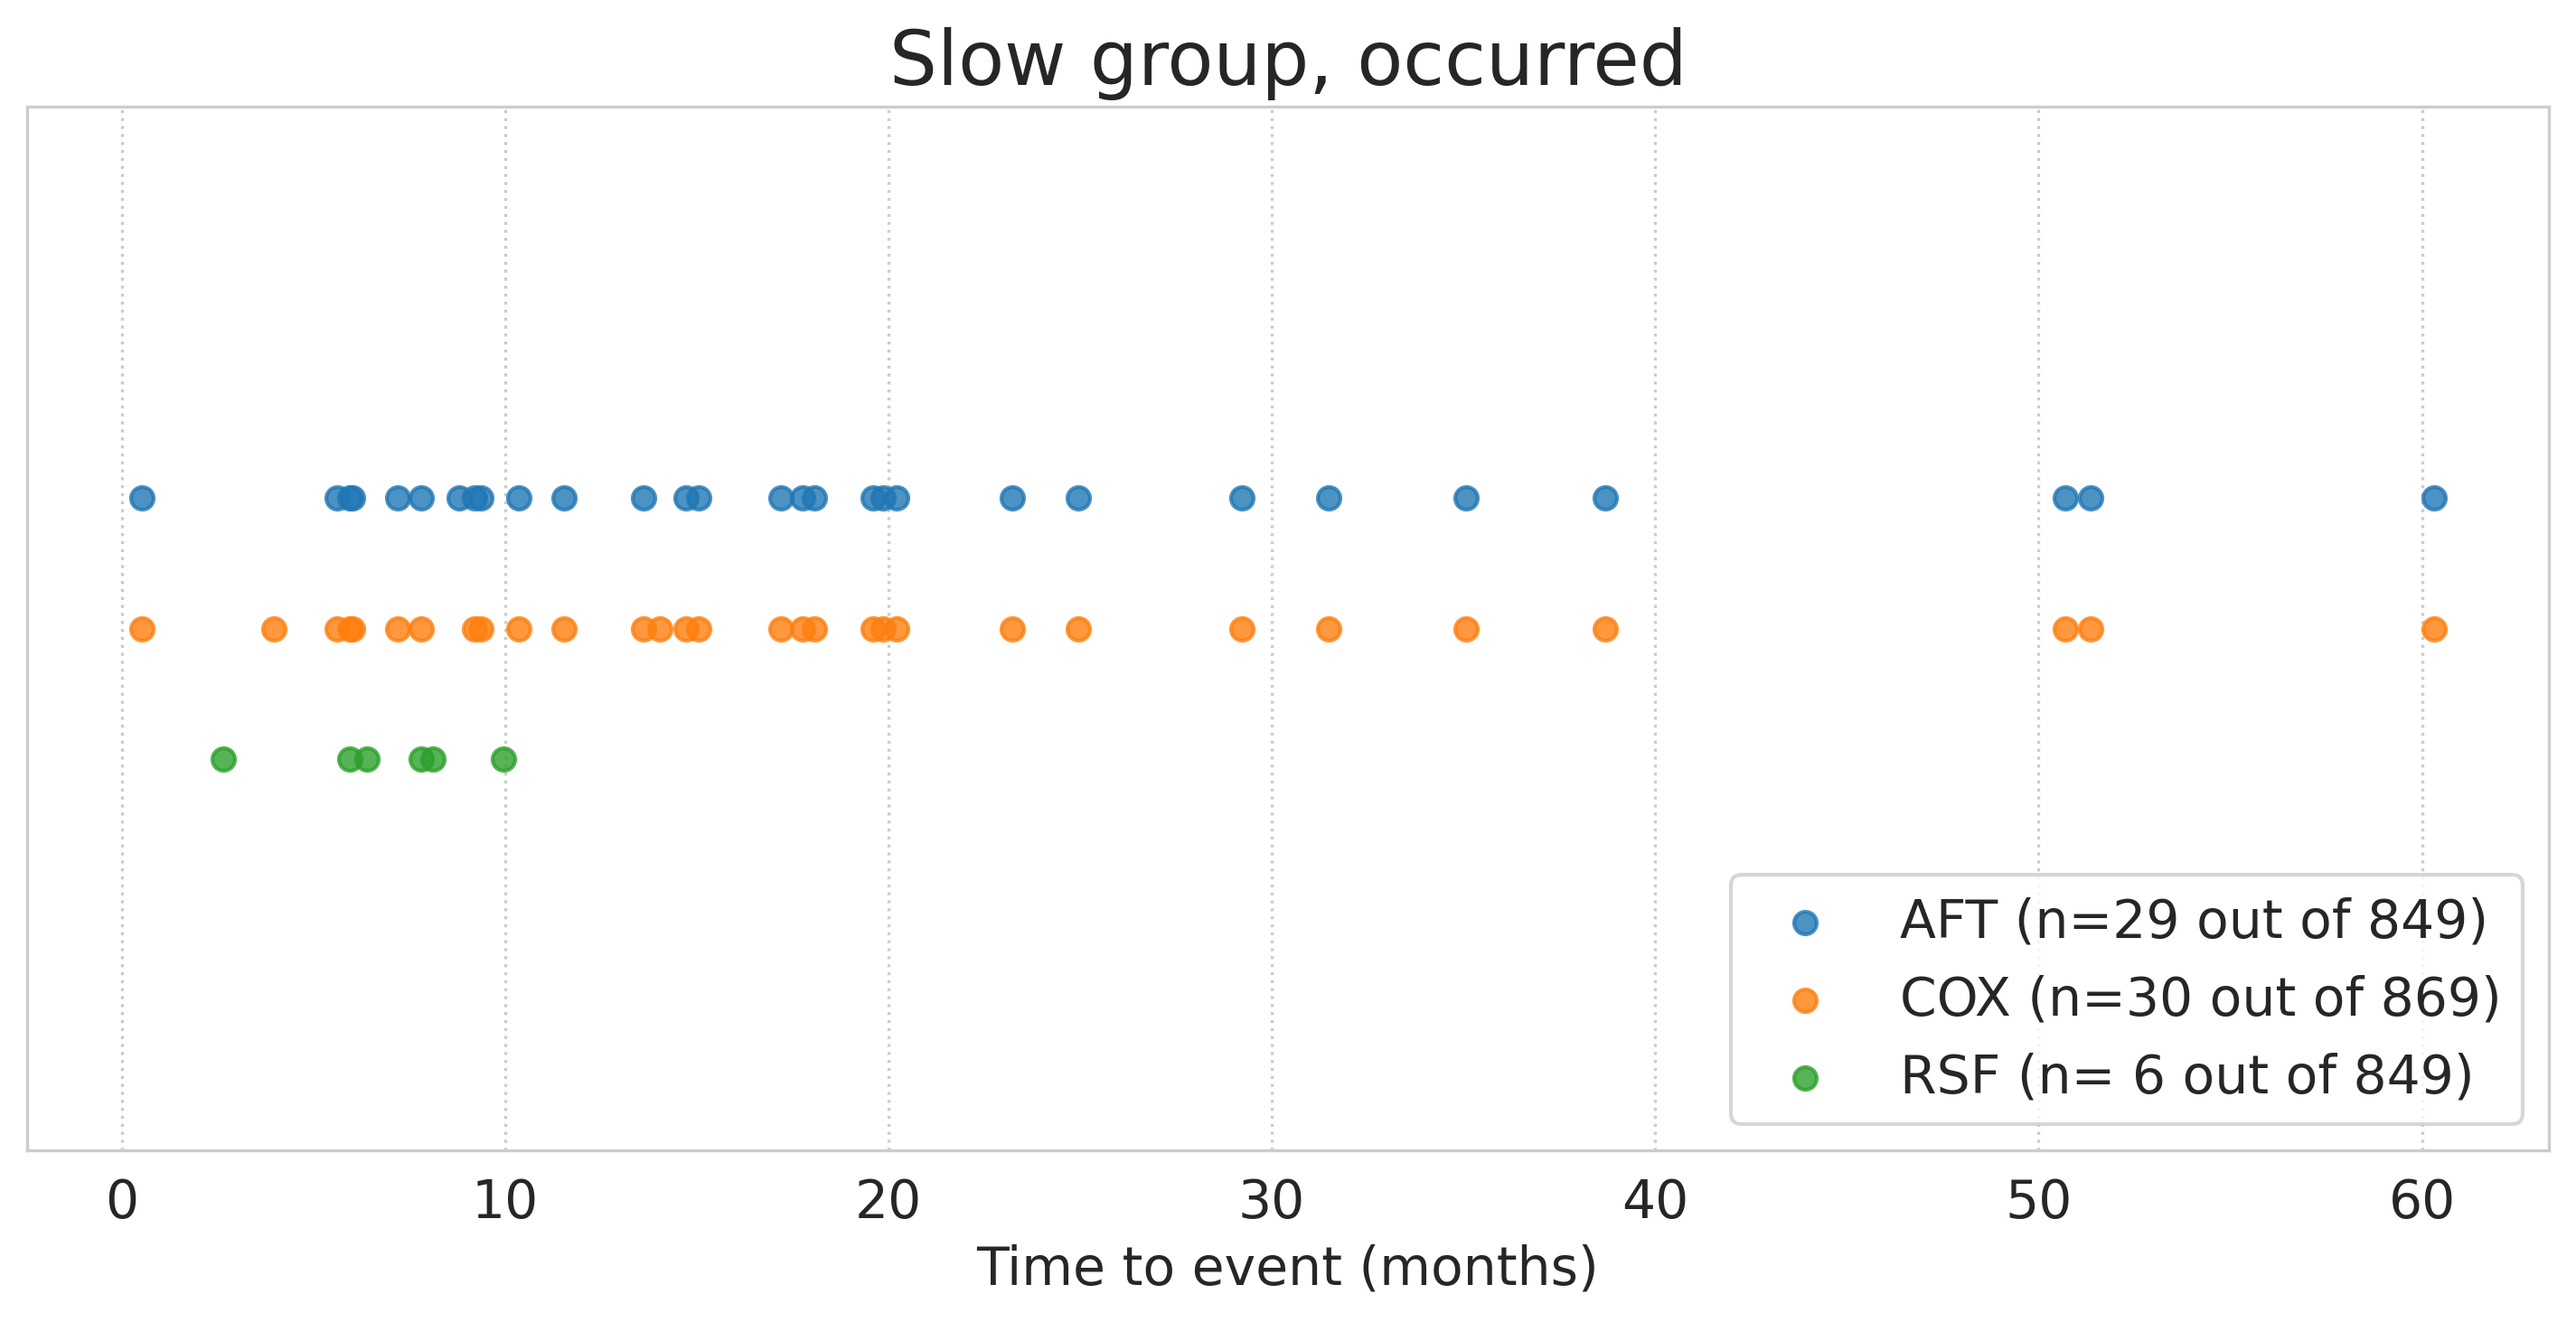

In [ ]:
plt.figure(figsize=(12,5))

occurred_aft = X_aft_slow[X_aft_slow['status_LOA']==1]
occurred_aft['model'] = 5
occurred_cph = X_cph_slow[X_cph_slow['status_LOA']==1]
occurred_cph['model'] = 4
occurred_rsf = X_rsf_slow[X_rsf_slow['status_LOA']==1]
occurred_rsf['model'] = 3

sns.regplot(x=occurred_aft['time_LOA'], y=occurred_aft['model'], fit_reg=False, label='AFT (n=29 out of 849)')
sns.regplot(x=occurred_cph['time_LOA'], y=occurred_cph['model'], fit_reg=False, label='COX (n=30 out of 869)')
sns.regplot(x=occurred_rsf['time_LOA'], y=occurred_rsf['model'], fit_reg=False, label='RSF (n= 6 out of 849)')

plt.grid('x')

plt.xlabel('Time to event (months)')
plt.ylabel('')
plt.yticks([])
plt.ylim([0,8])
plt.title('Slow group, occurred', fontsize=20)
plt.legend(loc='lower right')

# 1-2. Visualization (5 random individuals)

In [ ]:
indi_5 = df_train_imputed.sample(n=5, random_state=35) #Pick 5 random patient
indi_5_rsf = df_train_imputed_rsf.sample(n=5, random_state=35)

new_index = ['patient 1', 'patient 2', 'patient 3', 'patient 4', 'patient 5']
indi_5.index = new_index
indi_5_rsf.index = new_index

Text(0.5, 1.0, 'AFT')

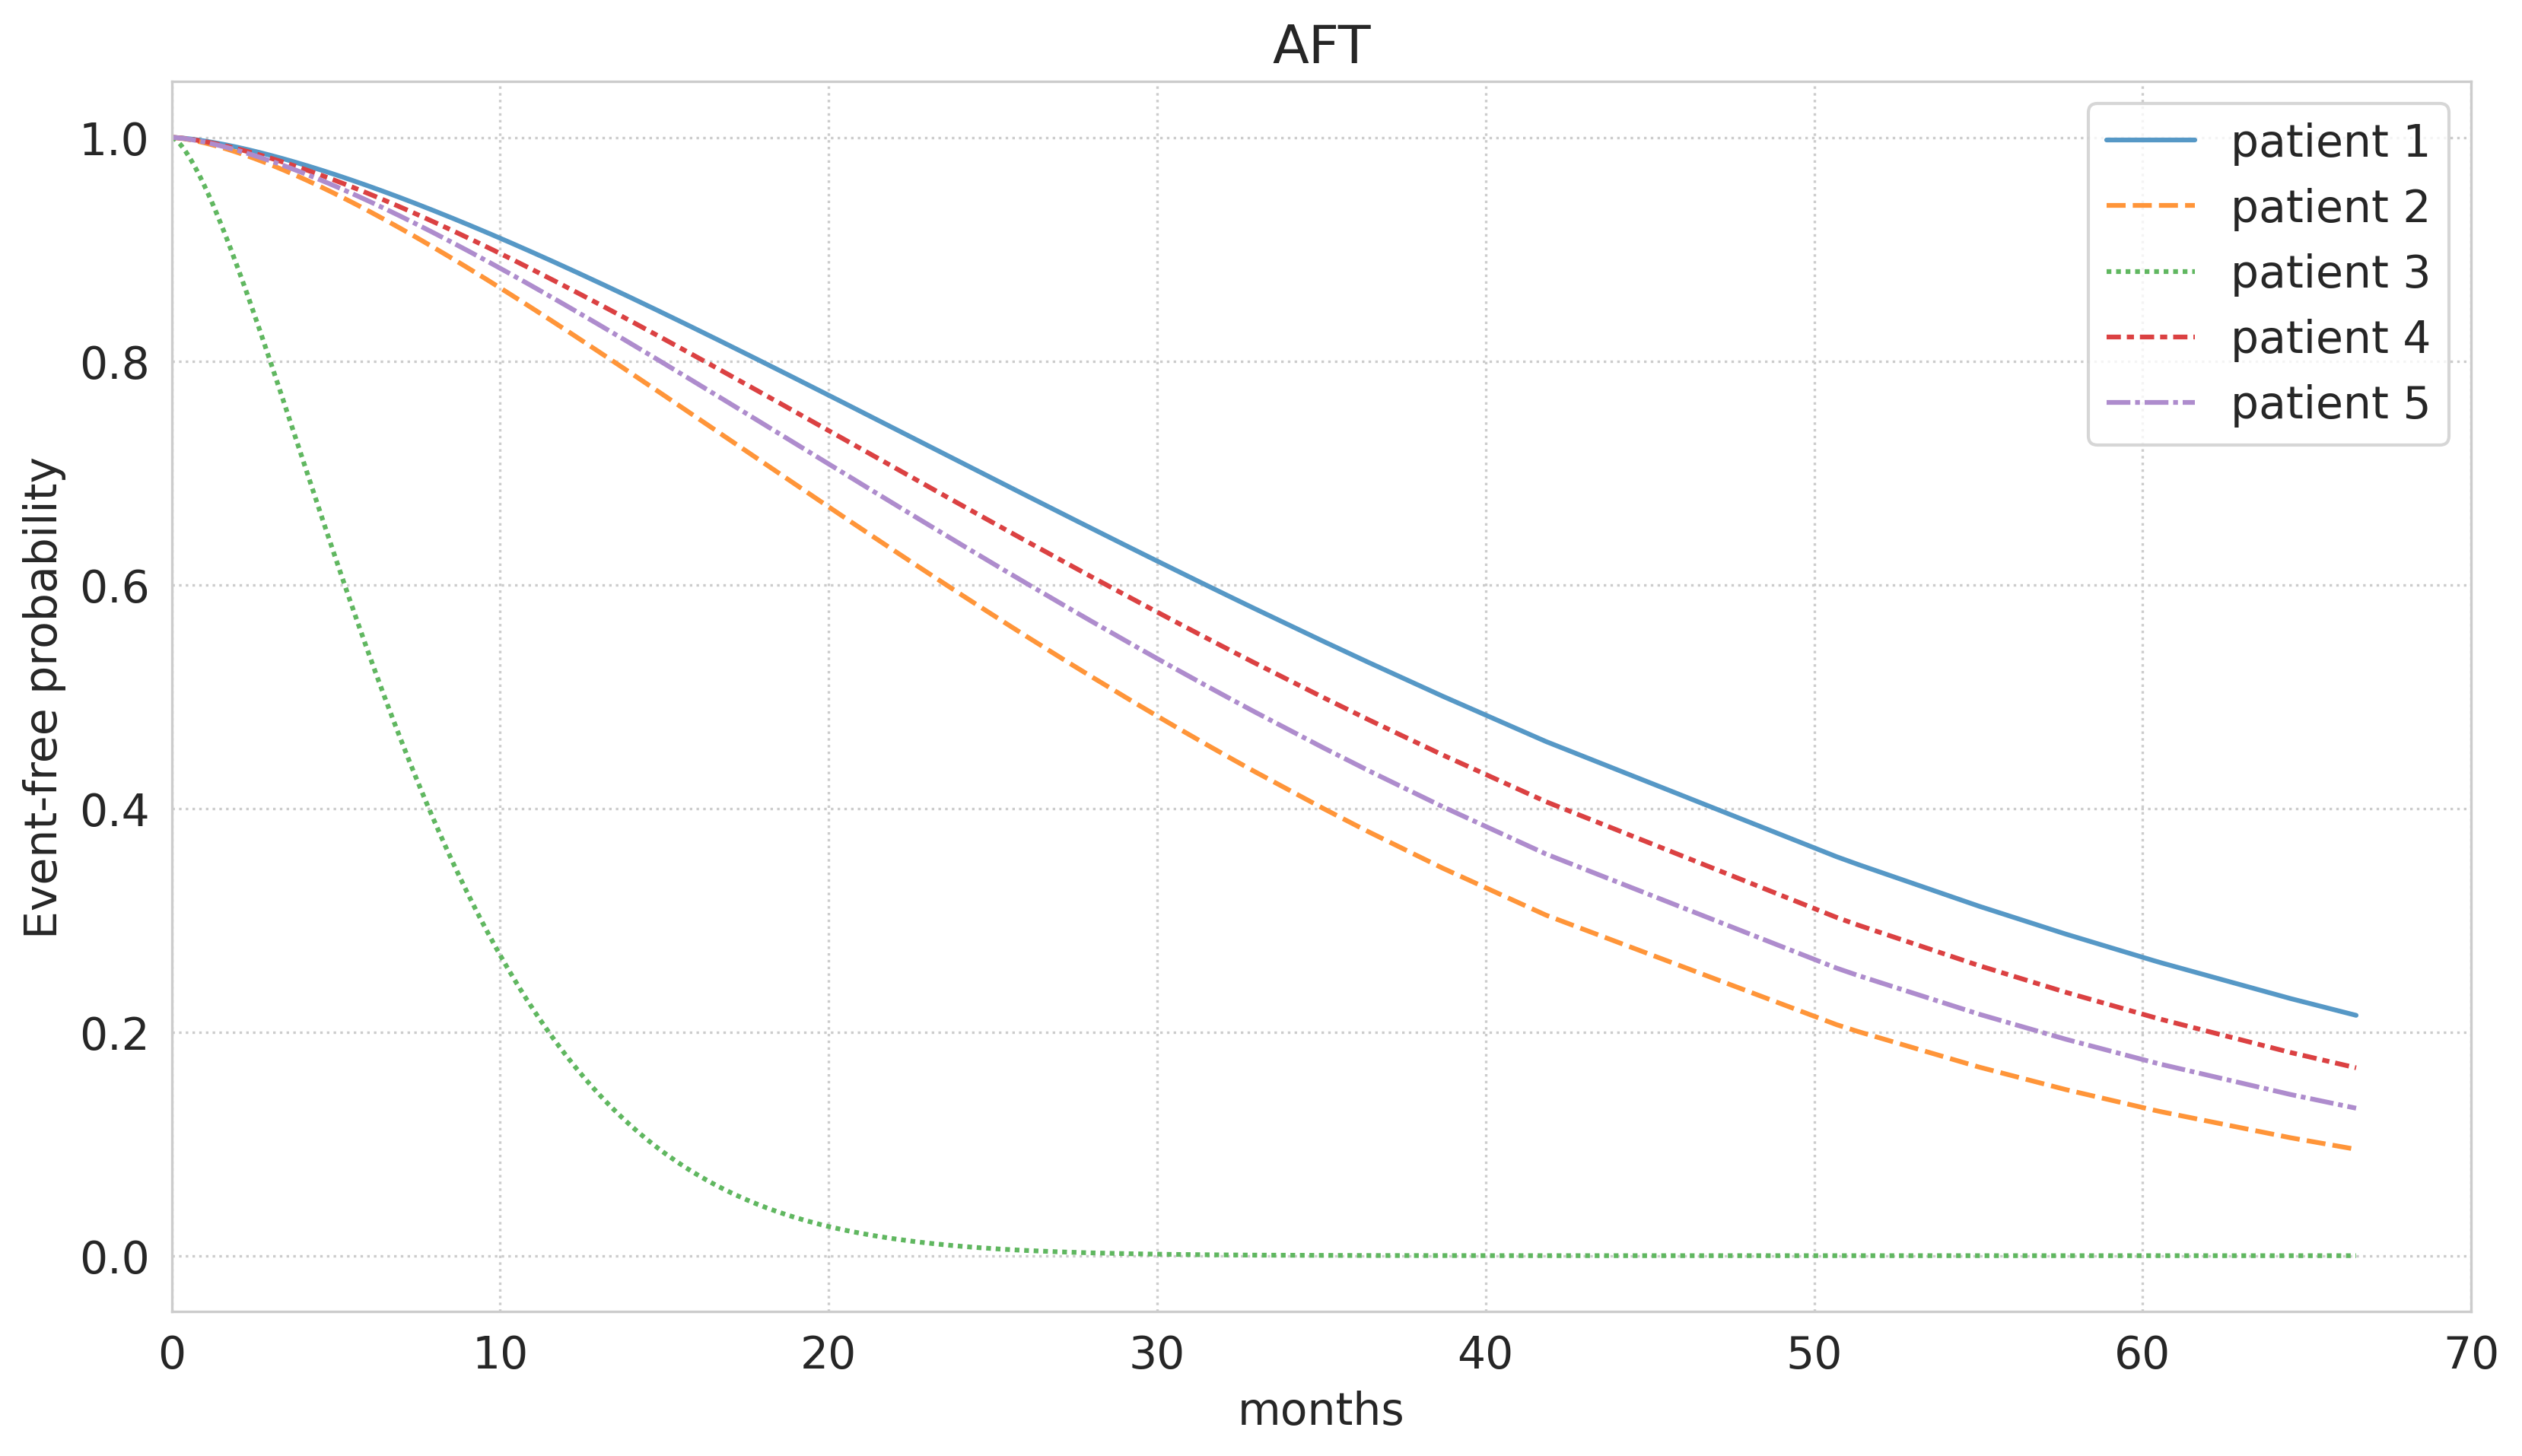

In [ ]:
palette = {'patient 1':'#5698C6', 'patient 2':'#FF9539',   'patient 3':'#60B760',   'patient 4':'#DB4142',  'patient 5': "#AE8CCD"}

fig, ax = plt.subplots(figsize=(13,7))
result_aft = aft.predict_survival_function(indi_5[aft_final_feature_list+['status_LOA', 'time_LOA']])
plt.xlim([0,70])
ax = sns.lineplot(data = result_aft, palette= palette)
ax.set(xlabel='months', ylabel='Event-free probability')
ax.set_title("AFT")

Text(0.5, 1.0, 'COX')

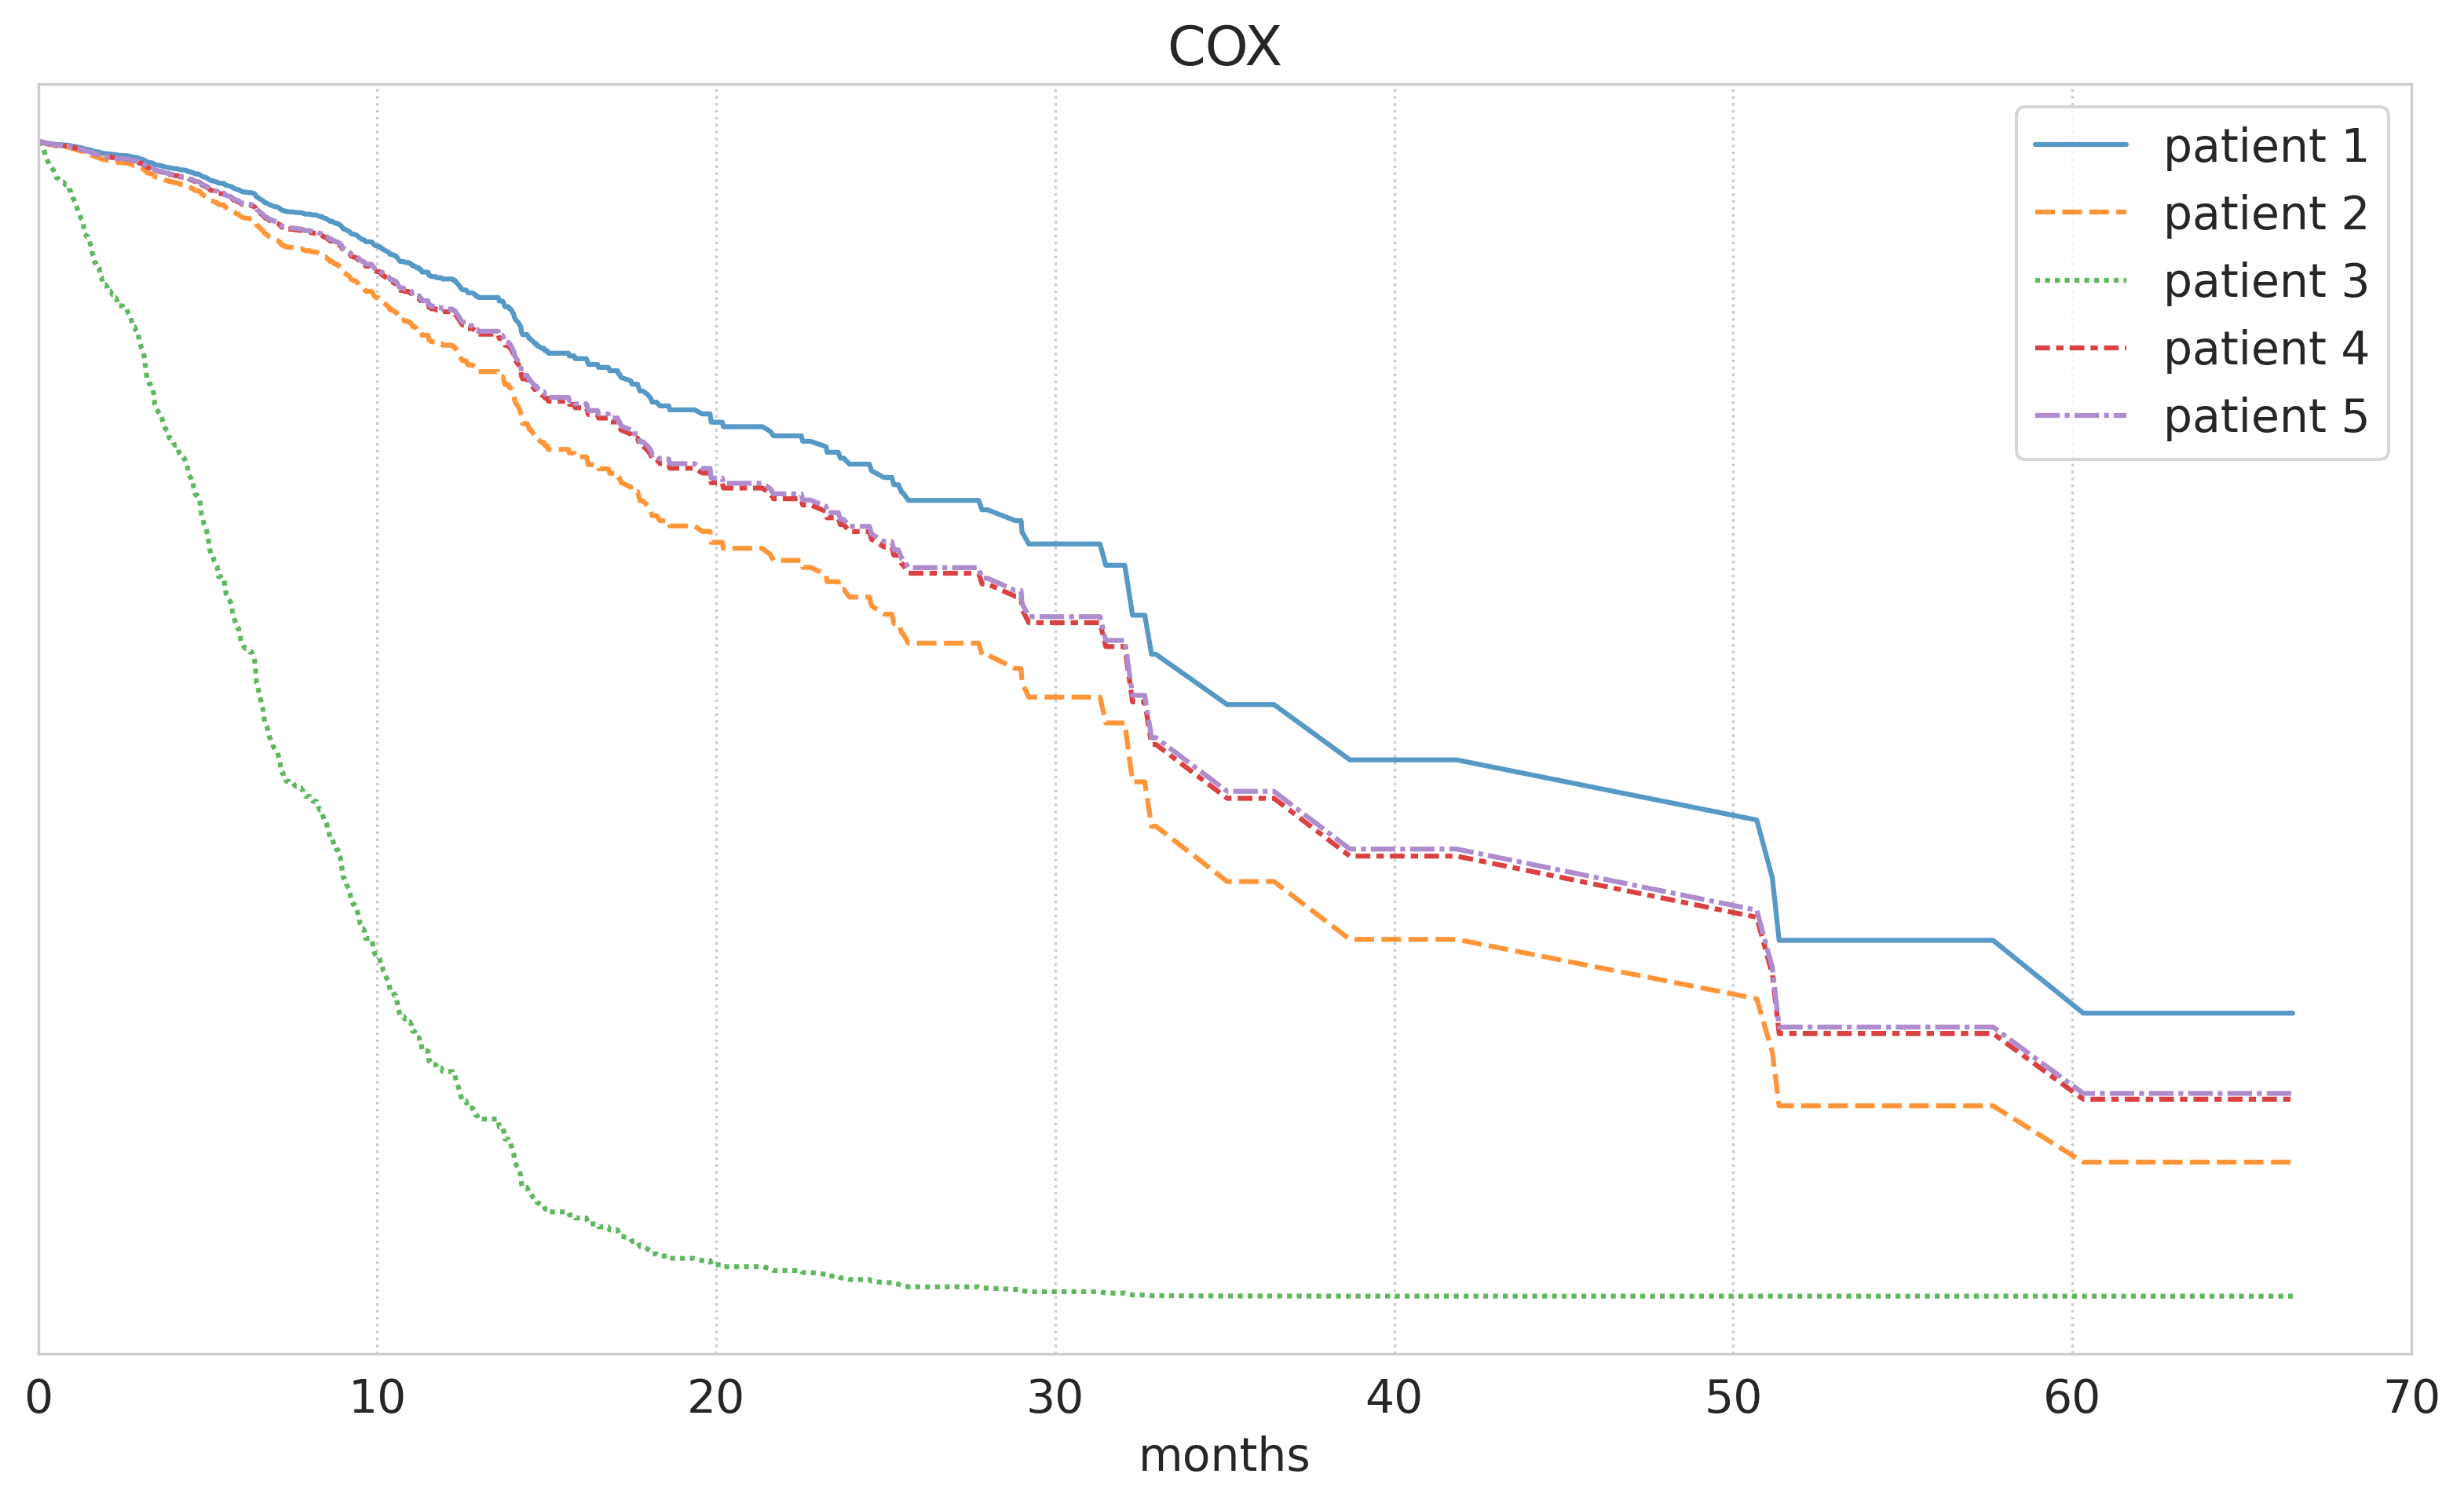

In [ ]:
fig, ax = plt.subplots(figsize=(13,7))
result_cph = cph.predict_survival_function(indi_5[cph_final_feature_list+['status_LOA', 'time_LOA']])
ax = sns.lineplot(data = result_cph, palette= palette)
ax.set(xlabel='months')
plt.xlim([0,70])
plt.yticks([])
ax.set_title("COX")

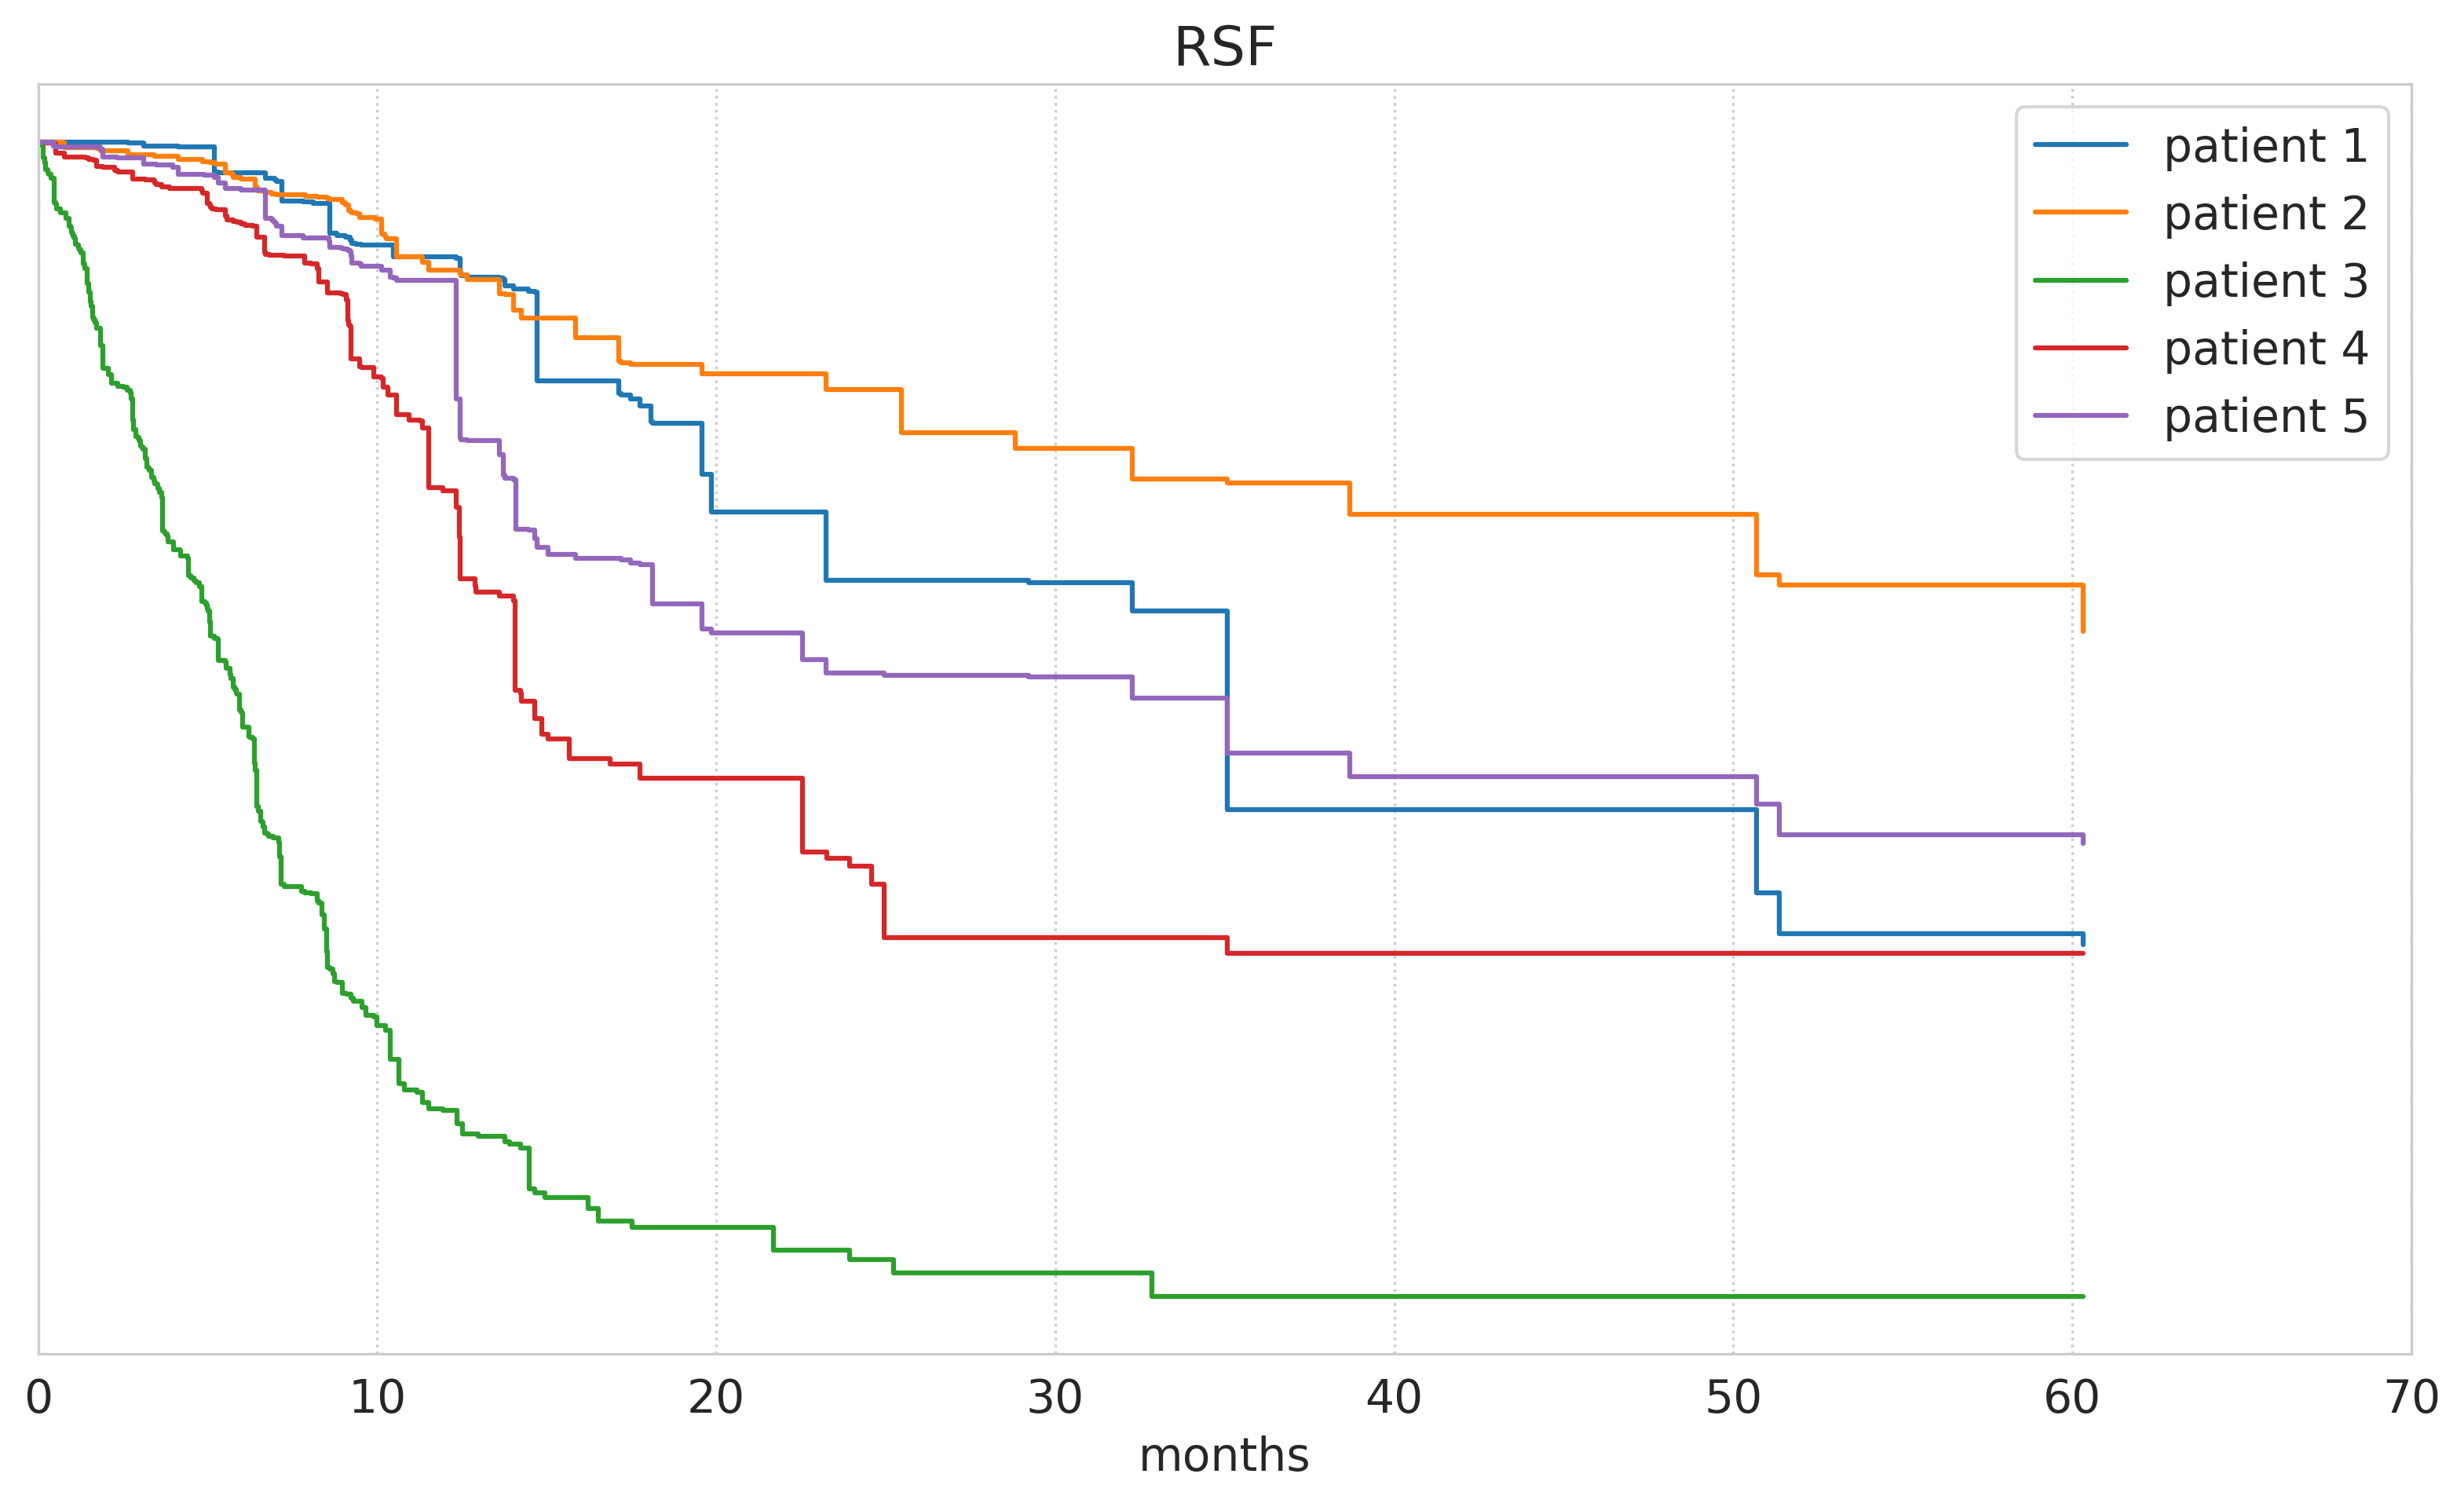

In [ ]:
result_rsf = rsf.predict_survival_function(indi_5_rsf[rsf_final_feature_list], return_array=True)
fig, ax = plt.subplots(figsize=(13,7))
for i, s in enumerate(result_rsf):
    plt.step(rsf.event_times_, s, where="post")

plt.legend(labels = list(indi_5_rsf[rsf_final_feature_list].index))
plt.xlabel("months")
plt.xlim([0,70])
plt.yticks([])
plt.title("RSF")
plt.show()

# 2. Check Multicolinearity

<Axes: title={'center': 'Pearson Correlation between Features'}>

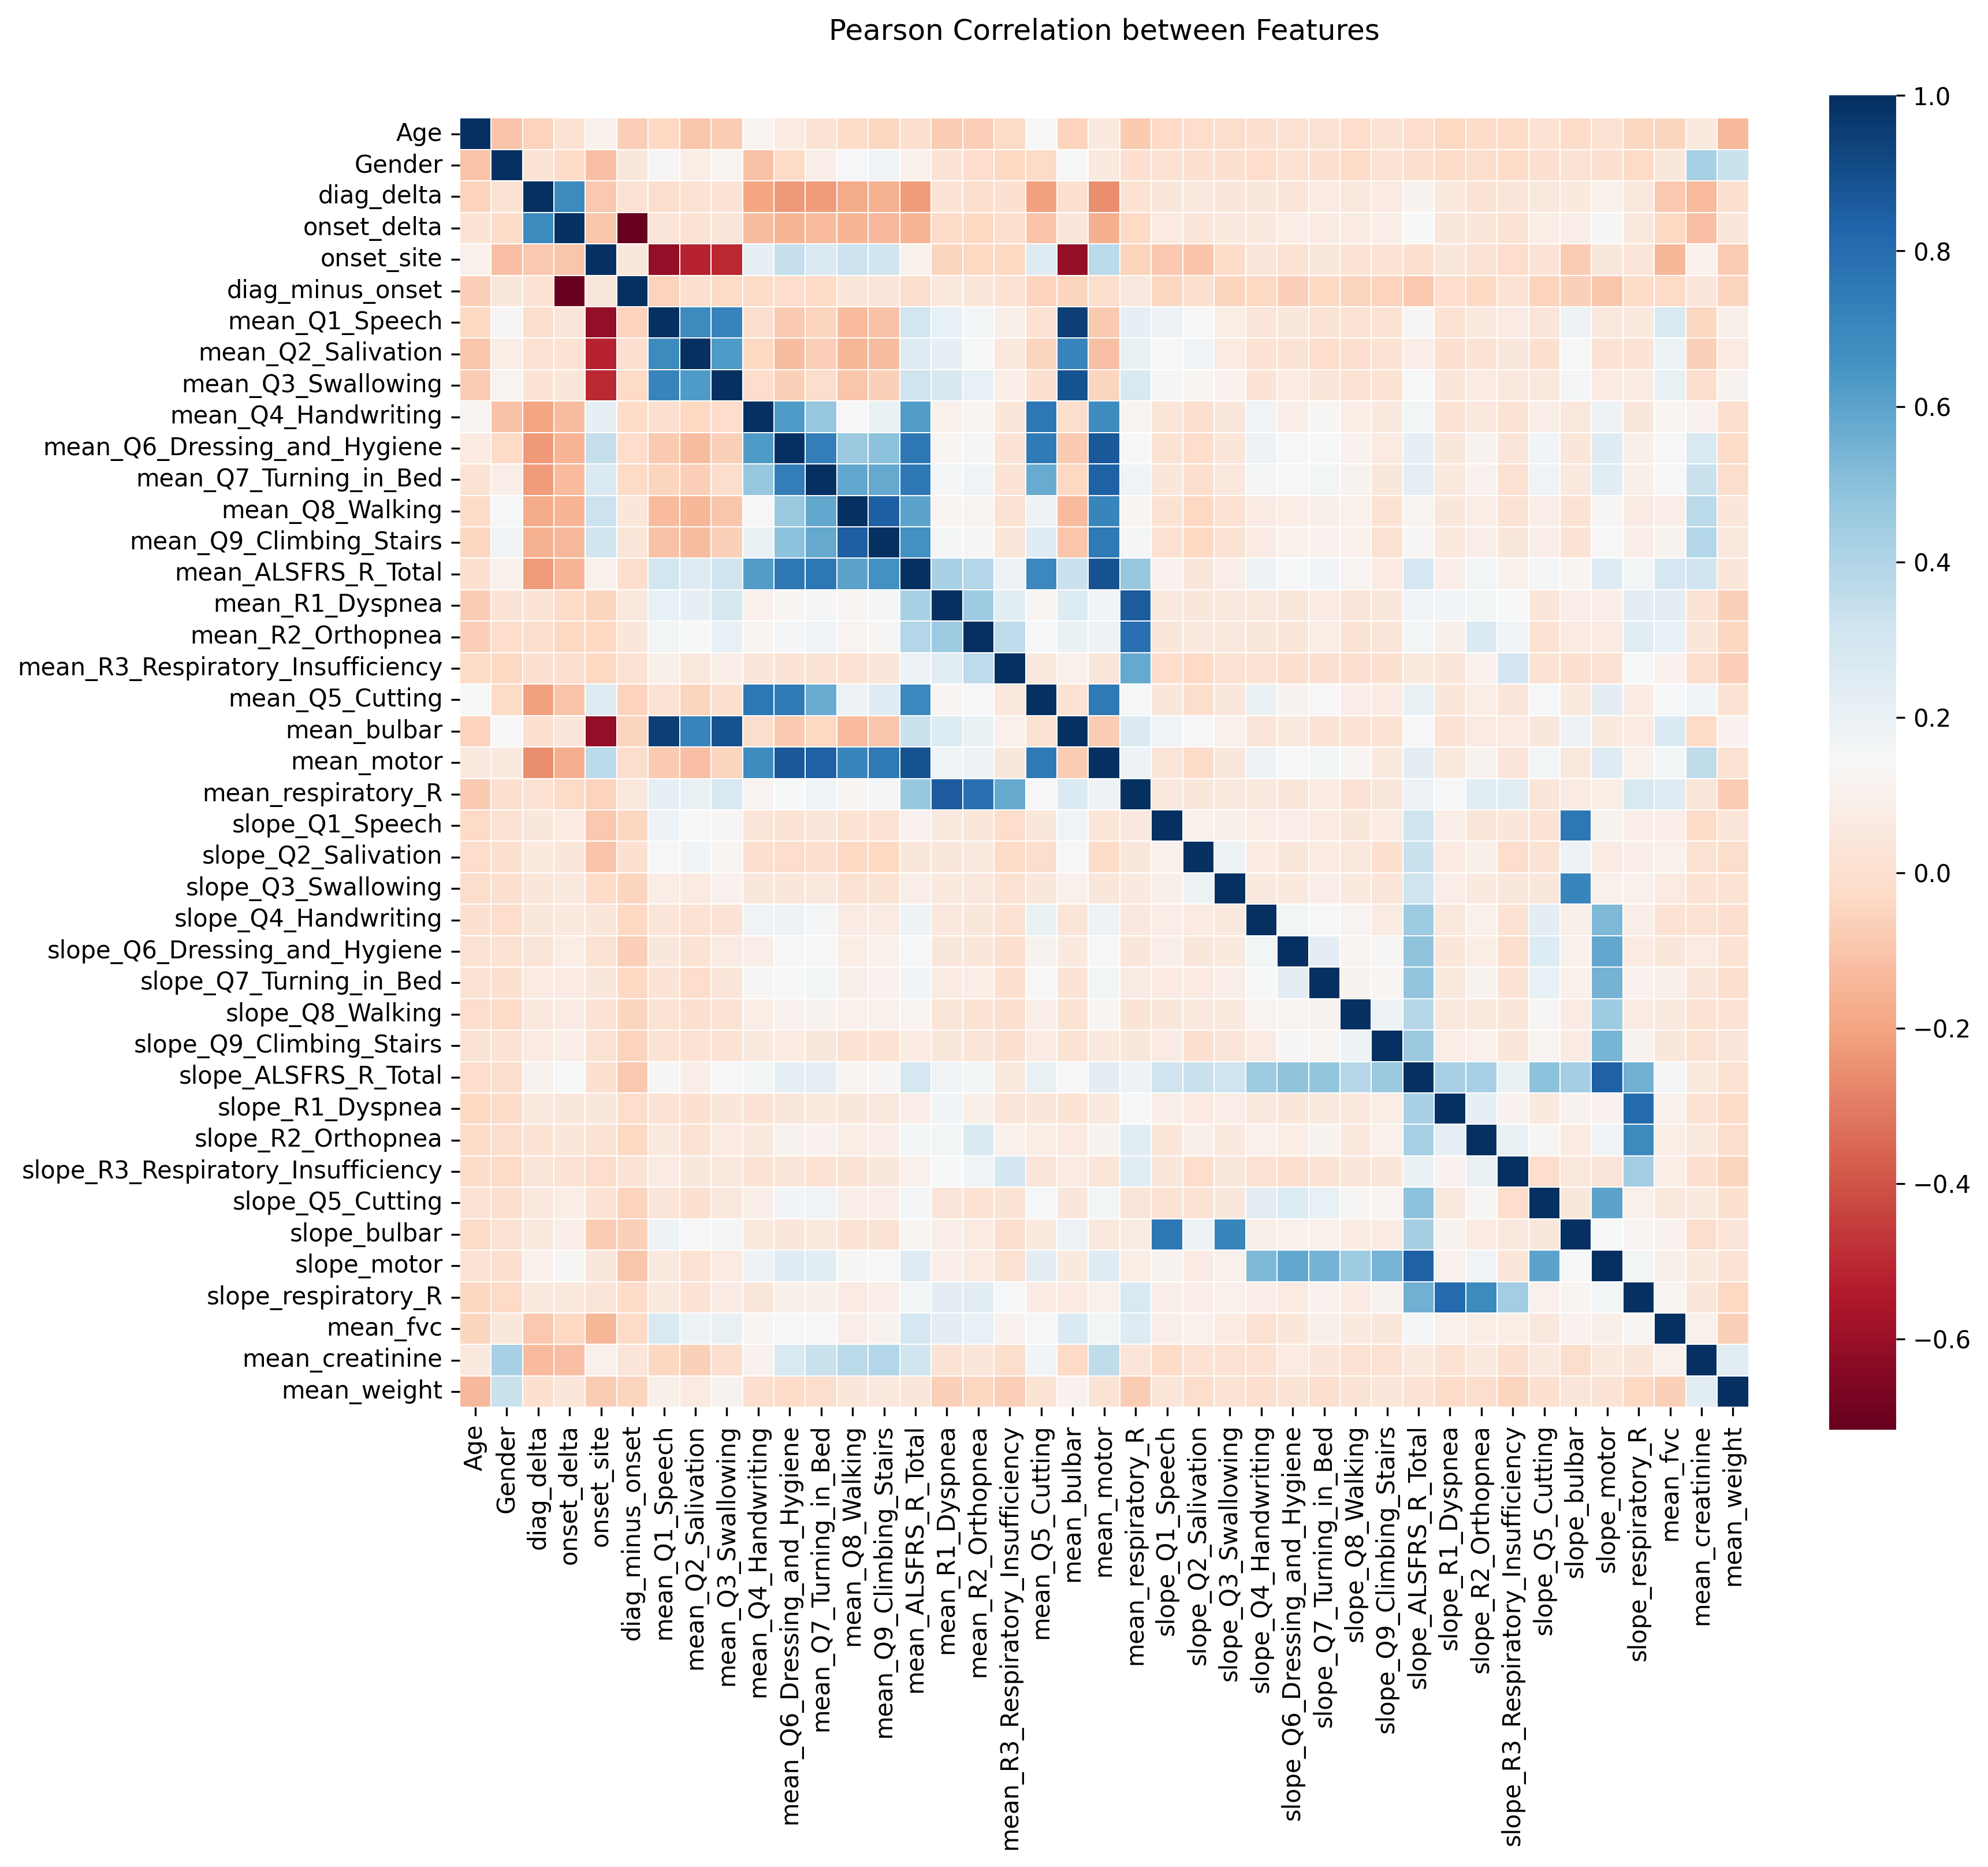

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(12,10))
plt.title('Pearson Correlation between Features', y=1.05, size=12)
sns.heatmap(df_train_imputed_rsf.drop(columns = ['SubjectID', 'time_LOA', 'status_LOA']).astype(float).corr(), linewidths=0.1, vmax=1.0,
   square=True, cmap=colormap, linecolor='white', annot=False)

# 3. Comparison of the time to event: Loss of autonomy vs. Gastrostomy placement

## (1) PRO-ACT data

### (i) Time to Gastrostomy = first time of 'ALSFRS Q5b is not NaN'

#### Extract Q5a, Q5b data

In [ ]:
def extract_time_resolved_feature(df, feature_list):
  df_final = df[df['feature_name'] == feature_list[0]][['SubjectID', 'feature_value', 'feature_delta']].rename(columns = {'feature_value': feature_list[0]})

  del feature_list[0]
  for x in feature_list:
    df_add = df[df['feature_name'] == x][['SubjectID', 'feature_value', 'feature_delta']].rename(columns = {'feature_value': x})
    df_final = pd.merge(df_final,df_add, on=['SubjectID','feature_delta'], how='outer')

  return df_final

In [ ]:
#Extract ALSFRS_R_Q5a & Q5b score
ALSFRS_R_raw = study_population.query("form_name == 'ALSFRS'").astype({'feature_delta':'float'})
ALSFRS_R_Q5 = extract_time_resolved_feature(ALSFRS_R_raw, ['Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy'])
ALSFRS_R_Q5 = ALSFRS_R_Q5[['SubjectID', 'feature_delta', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy']]
ALSFRS_R_Q5

SubjectID  feature_delta Q5a_Cutting_without_Gastrostomy  \
0          348.0            0.0                             2.0   
1          348.0            4.0                             2.0   
2          348.0           52.0                             2.0   
3          348.0           61.0                             2.0   
4          348.0           99.0                             2.0   
...          ...            ...                             ...   
33241   995893.0          410.0                             NaN   
33242   996711.0          379.0                             NaN   
33243   996711.0          401.0                             NaN   
33244   996711.0          436.0                             NaN   
33245   996711.0          471.0                             NaN   

      Q5b_Cutting_with_Gastrostomy  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
...                            ...  
33241                          0.0  
33242                          4.0  
33243                          4.0  
33244                          4.0  
33245                          4.0  

[33246 rows x 4 columns]

In [ ]:
# Check if both Q5a, q5b values are NaN
result = ALSFRS_R_Q5[(ALSFRS_R_Q5['Q5a_Cutting_without_Gastrostomy'] == np.NaN) & (ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'] == np.NaN)]

if not result.empty:
    print("Rows where both Q5a, Q5b values are NaN found:")
    print(result)
else:
    print("No rows where both Q5a, Q5b values are NaN.")

No rows where both Q5a, Q5b values are NaN.


In [ ]:
# Check if both Q5a, q5b values exist
result = ALSFRS_R_Q5[~(ALSFRS_R_Q5['Q5a_Cutting_without_Gastrostomy'].isna() | ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'].isna())]

if not result.empty:
    print("Rows where both Q5a, Q5b values exist found:")
    print(result)
else:
    print("No rows where both Q5a, Q5b values exist.")

Rows where both Q5a, Q5b values exist found:
       SubjectID  feature_delta Q5a_Cutting_without_Gastrostomy  \
26881   872882.0           77.0                             3.0   
26882   872882.0          142.0                             3.0   
26883   872882.0          323.0                             3.0   
26884   872882.0          379.0                             3.0   

      Q5b_Cutting_with_Gastrostomy  
26881                          3.0  
26882                          3.0  
26883                          3.0  
26884                          3.0  


In [ ]:
# Delete SubjectID 872882 because both Q5a, Q5b value exists
ALSFRS_R_Q5 = ALSFRS_R_Q5[ALSFRS_R_Q5['SubjectID']!= 872882.0]
ALSFRS_R_Q5

SubjectID  feature_delta Q5a_Cutting_without_Gastrostomy  \
0          348.0            0.0                             2.0   
1          348.0            4.0                             2.0   
2          348.0           52.0                             2.0   
3          348.0           61.0                             2.0   
4          348.0           99.0                             2.0   
...          ...            ...                             ...   
33241   995893.0          410.0                             NaN   
33242   996711.0          379.0                             NaN   
33243   996711.0          401.0                             NaN   
33244   996711.0          436.0                             NaN   
33245   996711.0          471.0                             NaN   

      Q5b_Cutting_with_Gastrostomy  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
...                            ...  
33241                          0.0  
33242                          4.0  
33243                          4.0  
33244                          4.0  
33245                          4.0  

[33239 rows x 4 columns]

In [ ]:
# Convert scale 'days' to 'month'
ALSFRS_R_Q5[['feature_delta']] = round((ALSFRS_R_Q5[['feature_delta']]/365)*12,2)

# Sort SubjectID and feature delta in ascending order
ALSFRS_R_Q5 = ALSFRS_R_Q5.query('feature_delta >= 0')
ALSFRS_R_Q5 = ALSFRS_R_Q5.sort_values(by=[ALSFRS_R_Q5.columns[0],ALSFRS_R_Q5.columns[1]],ascending=True)
ALSFRS_R_Q5

<ipython-input-252-e144eb608e21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ALSFRS_R_Q5[['feature_delta']] = round((ALSFRS_R_Q5[['feature_delta']]/365)*12,2)


SubjectID  feature_delta Q5a_Cutting_without_Gastrostomy  \
0          348.0           0.00                             2.0   
1          348.0           0.13                             2.0   
2          348.0           1.71                             2.0   
3          348.0           2.01                             2.0   
4          348.0           3.25                             2.0   
...          ...            ...                             ...   
30978   999990.0           0.39                             1.0   
30979   999990.0           1.32                             1.0   
30980   999990.0           2.24                             1.0   
30981   999990.0           3.19                             0.0   
30982   999990.0           4.14                             0.0   

      Q5b_Cutting_with_Gastrostomy  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
...                            ...  
30978                          NaN  
30979                          NaN  
30980                          NaN  
30981                          NaN  
30982                          NaN  

[33230 rows x 4 columns]

In [ ]:
print("ALSFRS_Q5 contains", len(ALSFRS_R_Q5['SubjectID'].unique().tolist()), " patients")

ALSFRS_Q5 contains 3395  patients


In [ ]:
ALSFRS_R_Q5 = ALSFRS_R_Q5.astype('float')
ALSFRS_R_Q5.dtypes

SubjectID                          float64
feature_delta                      float64
Q5a_Cutting_without_Gastrostomy    float64
Q5b_Cutting_with_Gastrostomy       float64
dtype: object

#### Extract 'Time_to_gastrostomy'

In [ ]:
# Find the first time of [ALSFRS_Q5b is not NaN]
Target_event = ALSFRS_R_Q5[ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'].notna()].groupby('SubjectID').agg(['first']).reset_index()
Target_event.head()

SubjectID feature_delta Q5a_Cutting_without_Gastrostomy  \
                    first                           first   
0     533.0          9.44                             NaN   
1    1736.0          8.02                             NaN   
2    4918.0         28.37                             NaN   
3    6483.0          3.22                             NaN   
4    7036.0          4.08                             NaN   

  Q5b_Cutting_with_Gastrostomy  
                         first  
0                          4.0  
1                          0.0  
2                          0.0  
3                          1.0  
4                          3.0

In [ ]:
# Coding [ALSFRS_Q5b is not NaN] event as '1'
Target_event_1 = Target_event[[('SubjectID',''), ('feature_delta', 'first')]]
Target_event_1.columns = ['SubjectID', 'time_GAS']

Target_event_1_subject_list = list(Target_event['SubjectID'])

Target_event_1['status_GAS'] = 1
print("There are",len(Target_event_1['SubjectID'].unique()), "subjects whose Gastrostomy = 1")

# Otherwise '0'
Target_event_0 = ALSFRS_R_Q5[~ALSFRS_R_Q5['SubjectID'].isin(Target_event_1_subject_list)]
Target_event_0 = Target_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=[('Q5a_Cutting_without_Gastrostomy', 'last'), ('Q5b_Cutting_with_Gastrostomy', 'last')])
Target_event_0.columns = ['SubjectID', 'time_GAS']
Target_event_0['status_GAS'] = 0
print("There are",len(Target_event_0['SubjectID'].unique()), "subjects whose Gastrostomy = 0")

# There are 636 subjects whose Gastrostomy = 1
# There are 2759 subjects whose Gastrostomy = 0

There are 636 subjects whose Gastrostomy = 1
There are 2759 subjects whose Gastrostomy = 0


<ipython-input-256-7dc4c2fd3d50>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Target_event_1['status_GAS'] = 1


In [ ]:
ALFRS_Q5_coded = pd.concat([Target_event_1, Target_event_0]).sort_values(by='SubjectID', axis=0)
ALFRS_Q5_coded = ALFRS_Q5_coded.reset_index()
ALFRS_Q5_coded.drop(columns='index', inplace=True)

Target_Data = ALFRS_Q5_coded.copy()
Target_Data_subject_list = list(Target_Data['SubjectID'])
Target_Data #3395 data

SubjectID  time_GAS  status_GAS
0         348.0     13.18           0
1         533.0      9.44           1
2         902.0      5.06           0
3        1736.0      8.02           1
4        3971.0     12.43           0
...         ...       ...         ...
3390   998491.0      4.41           0
3391   999166.0     12.82           0
3392   999522.0     13.78           0
3393   999823.0      6.05           0
3394   999990.0      4.14           0

[3395 rows x 3 columns]

#### Exclude; event or censoring occurred within 3 months after enrollment (to compare with time to LOA, we apply same exclusion criteria)

<Axes: xlabel='time_GAS', ylabel='Count'>

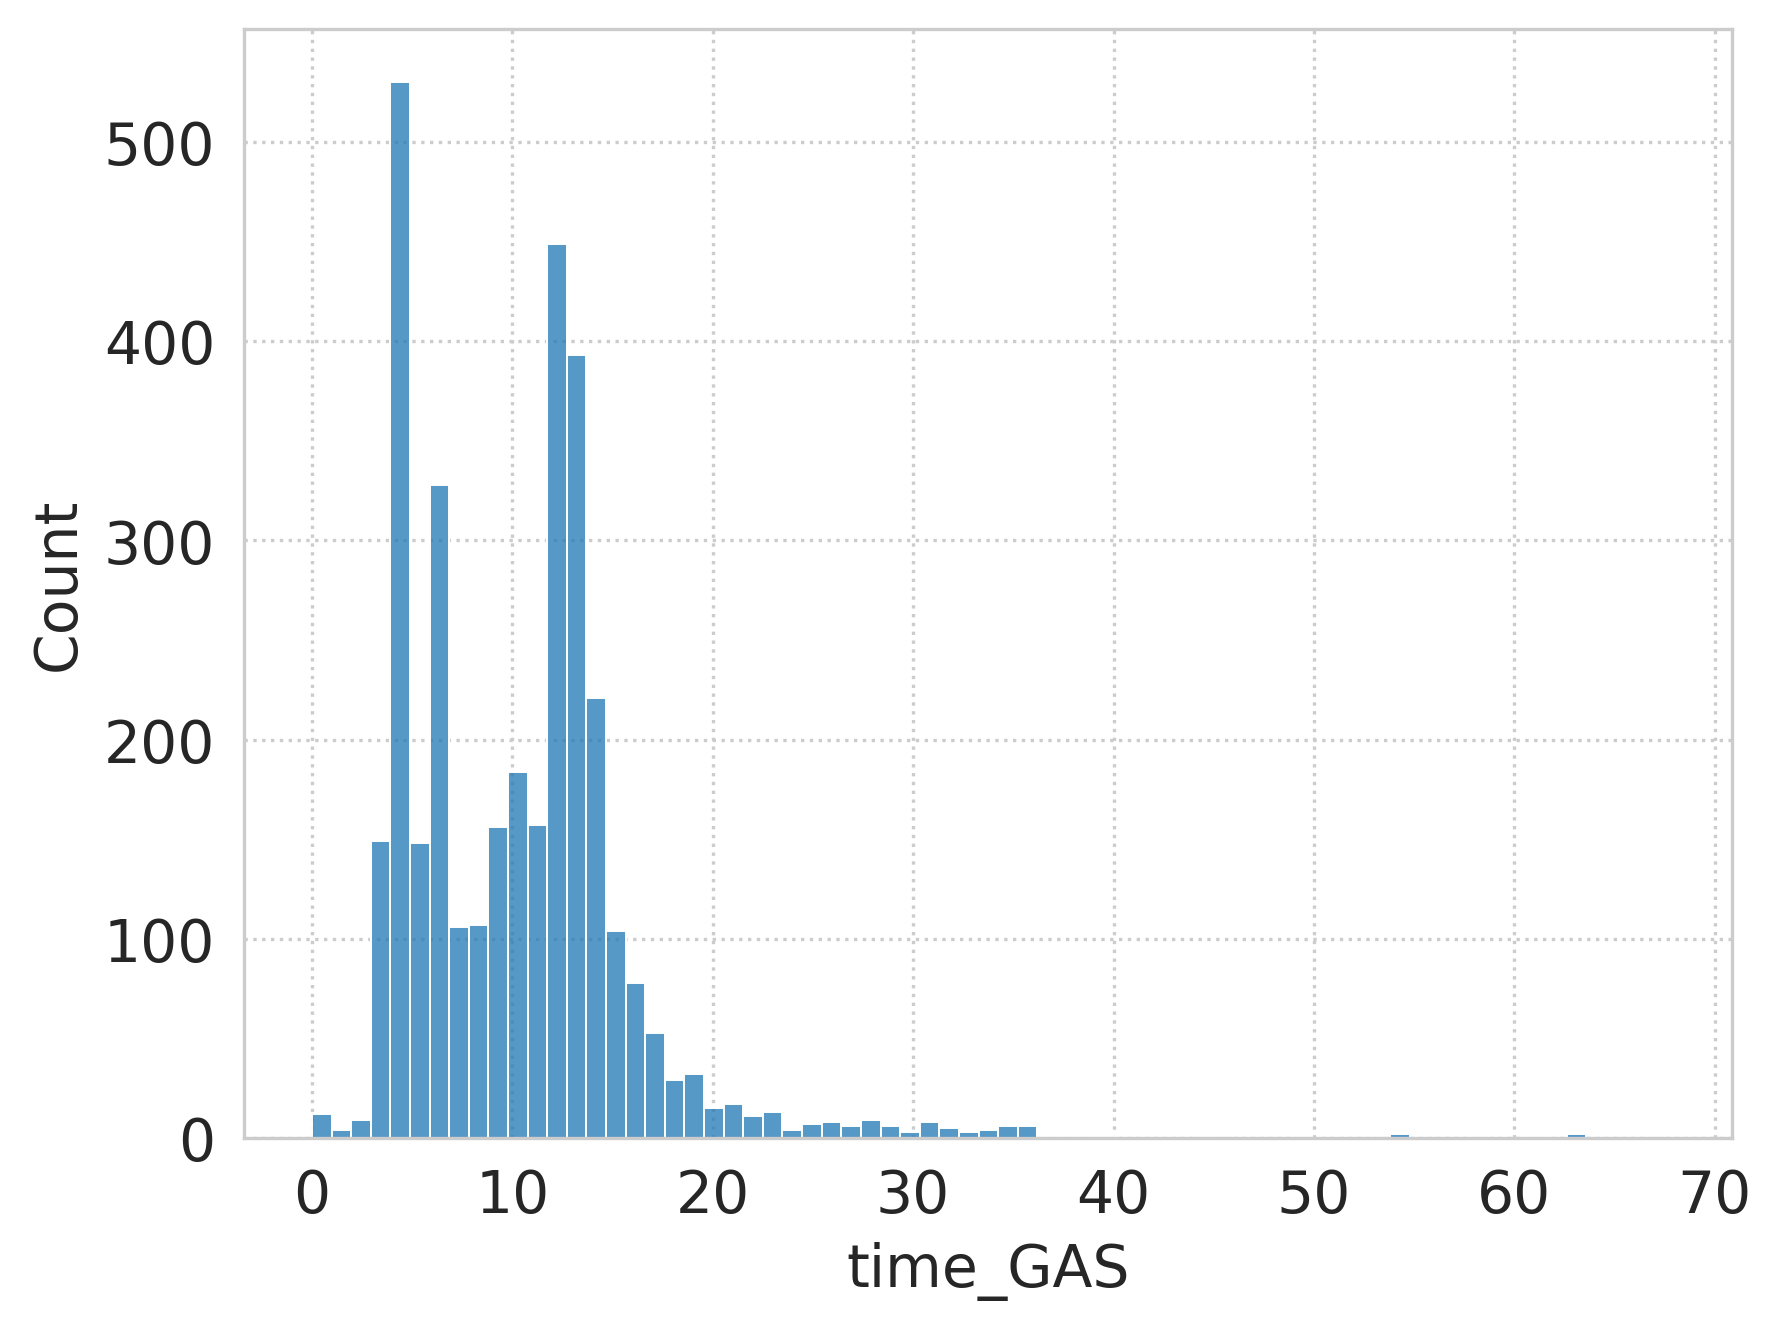

In [ ]:
sns.histplot(Target_Data['time_GAS'])

In [ ]:
Target_Data.query('time_GAS <= 3.0')

SubjectID  time_GAS  status_GAS
257     70641.0      0.00           1
391    111495.0      2.96           1
394    112584.0      0.23           1
397    112874.0      1.91           1
665    181721.0      0.00           1
845    246110.0      2.40           1
1185   350380.0      0.69           1
1239   364548.0      0.69           1
1308   383121.0      0.92           1
1522   450195.0      2.83           1
1584   473953.0      2.83           1
1634   491431.0      2.14           1
1640   492553.0      2.40           1
1737   518209.0      1.78           1
1834   544174.0      2.37           1
2032   600617.0      1.51           1
2096   618492.0      0.00           1
2116   625009.0      2.83           1
2197   649020.0      0.00           1
2511   747251.0      2.76           1
2747   814471.0      1.12           1
2837   838408.0      0.46           1
2926   865012.0      0.00           1
2933   867360.0      2.07           1
3180   941388.0      0.07           1
3250   959282.0      0.00           1

In [ ]:
print(len(Target_Data.query('time_GAS <= 3.0')['SubjectID'].tolist()), 'patients has time_GAS 3 month or less')

26 patients has time_GAS 3 month or less


In [ ]:
Target_Data_final = Target_Data.query('time_GAS > 3.0')

# minus 3months for target data value
Target_Data_final['time_GAS'] = Target_Data_final['time_GAS'] -3.0

GAS = Target_Data_final
GAS

<ipython-input-261-a4f830bcfff6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Target_Data_final['time_GAS'] = Target_Data_final['time_GAS'] -3.0


SubjectID  time_GAS  status_GAS
0         348.0     10.18           0
1         533.0      6.44           1
2         902.0      2.06           0
3        1736.0      5.02           1
4        3971.0      9.43           0
...         ...       ...         ...
3390   998491.0      1.41           0
3391   999166.0      9.82           0
3392   999522.0     10.78           0
3393   999823.0      3.05           0
3394   999990.0      1.14           0

[3369 rows x 3 columns]

In [ ]:
print(len(Target_Data['SubjectID'])-len(Target_Data_final['SubjectID']), 'patients were excluded because of early occurrence or censoring')
print(len(Target_Data.query('(time_GAS <= 3.0) and (status_GAS == 0)')), 'out of 26 are early censored (follow up being < 3mo)')
print(len(Target_Data.query('(time_GAS <= 3.0) and (status_GAS == 1)')), 'out of 26 are early occured (occurred before 3mo)')

26 patients were excluded because of early occurrence or censoring
0 out of 26 are early censored (follow up being < 3mo)
26 out of 26 are early occured (occurred before 3mo)


In [ ]:
# Note that 'time_GAS' is month scaled

In [ ]:
LOA = df_train_imputed[['SubjectID','time_LOA', 'status_LOA']]
LOA

SubjectID  time_LOA  status_LOA
0         348.0     10.18         0.0
1         533.0      6.44         1.0
2         902.0      2.06         0.0
3        1736.0      5.02         1.0
4        3971.0      9.43         0.0
...         ...       ...         ...
3391   998491.0      1.41         0.0
3392   999166.0      9.82         0.0
3393   999522.0     10.78         0.0
3394   999823.0      3.05         0.0
3395   999990.0      1.14         0.0

[3396 rows x 3 columns]

In [ ]:
# Check the proportion of censored data
print("There are ", len(LOA[LOA['status_LOA']==0]), "censored data in",len(LOA), " Loss of Autonomy")
print("There are ", len(GAS[GAS['status_GAS']==0]), "censored data in",len(GAS), " gastrostomy")

There are  2781 censored data in 3396  Loss of Autonomy
There are  2759 censored data in 3369  gastrostomy


### (ii) KM estimation on each target

In [ ]:
merged_target = pd.merge(LOA, GAS, on='SubjectID', how='inner')
merged_target

SubjectID  time_LOA  status_LOA  time_GAS  status_GAS
0         348.0     10.18         0.0     10.18           0
1         533.0      6.44         1.0      6.44           1
2         902.0      2.06         0.0      2.06           0
3        1736.0      5.02         1.0      5.02           1
4        3971.0      9.43         0.0      9.43           0
...         ...       ...         ...       ...         ...
3364   998491.0      1.41         0.0      1.41           0
3365   999166.0      9.82         0.0      9.82           0
3366   999522.0     10.78         0.0     10.78           0
3367   999823.0      3.05         0.0      3.05           0
3368   999990.0      1.14         0.0      1.14           0

[3369 rows x 5 columns]

In [ ]:
merged_target = merged_target.query("SubjectID=={0}".format(study_population['SubjectID'].unique().tolist()))
merged_target

SubjectID  time_LOA  status_LOA  time_GAS  status_GAS
0         348.0     10.18         0.0     10.18           0
1         533.0      6.44         1.0      6.44           1
2         902.0      2.06         0.0      2.06           0
3        1736.0      5.02         1.0      5.02           1
4        3971.0      9.43         0.0      9.43           0
...         ...       ...         ...       ...         ...
3364   998491.0      1.41         0.0      1.41           0
3365   999166.0      9.82         0.0      9.82           0
3366   999522.0     10.78         0.0     10.78           0
3367   999823.0      3.05         0.0      3.05           0
3368   999990.0      1.14         0.0      1.14           0

[3369 rows x 5 columns]

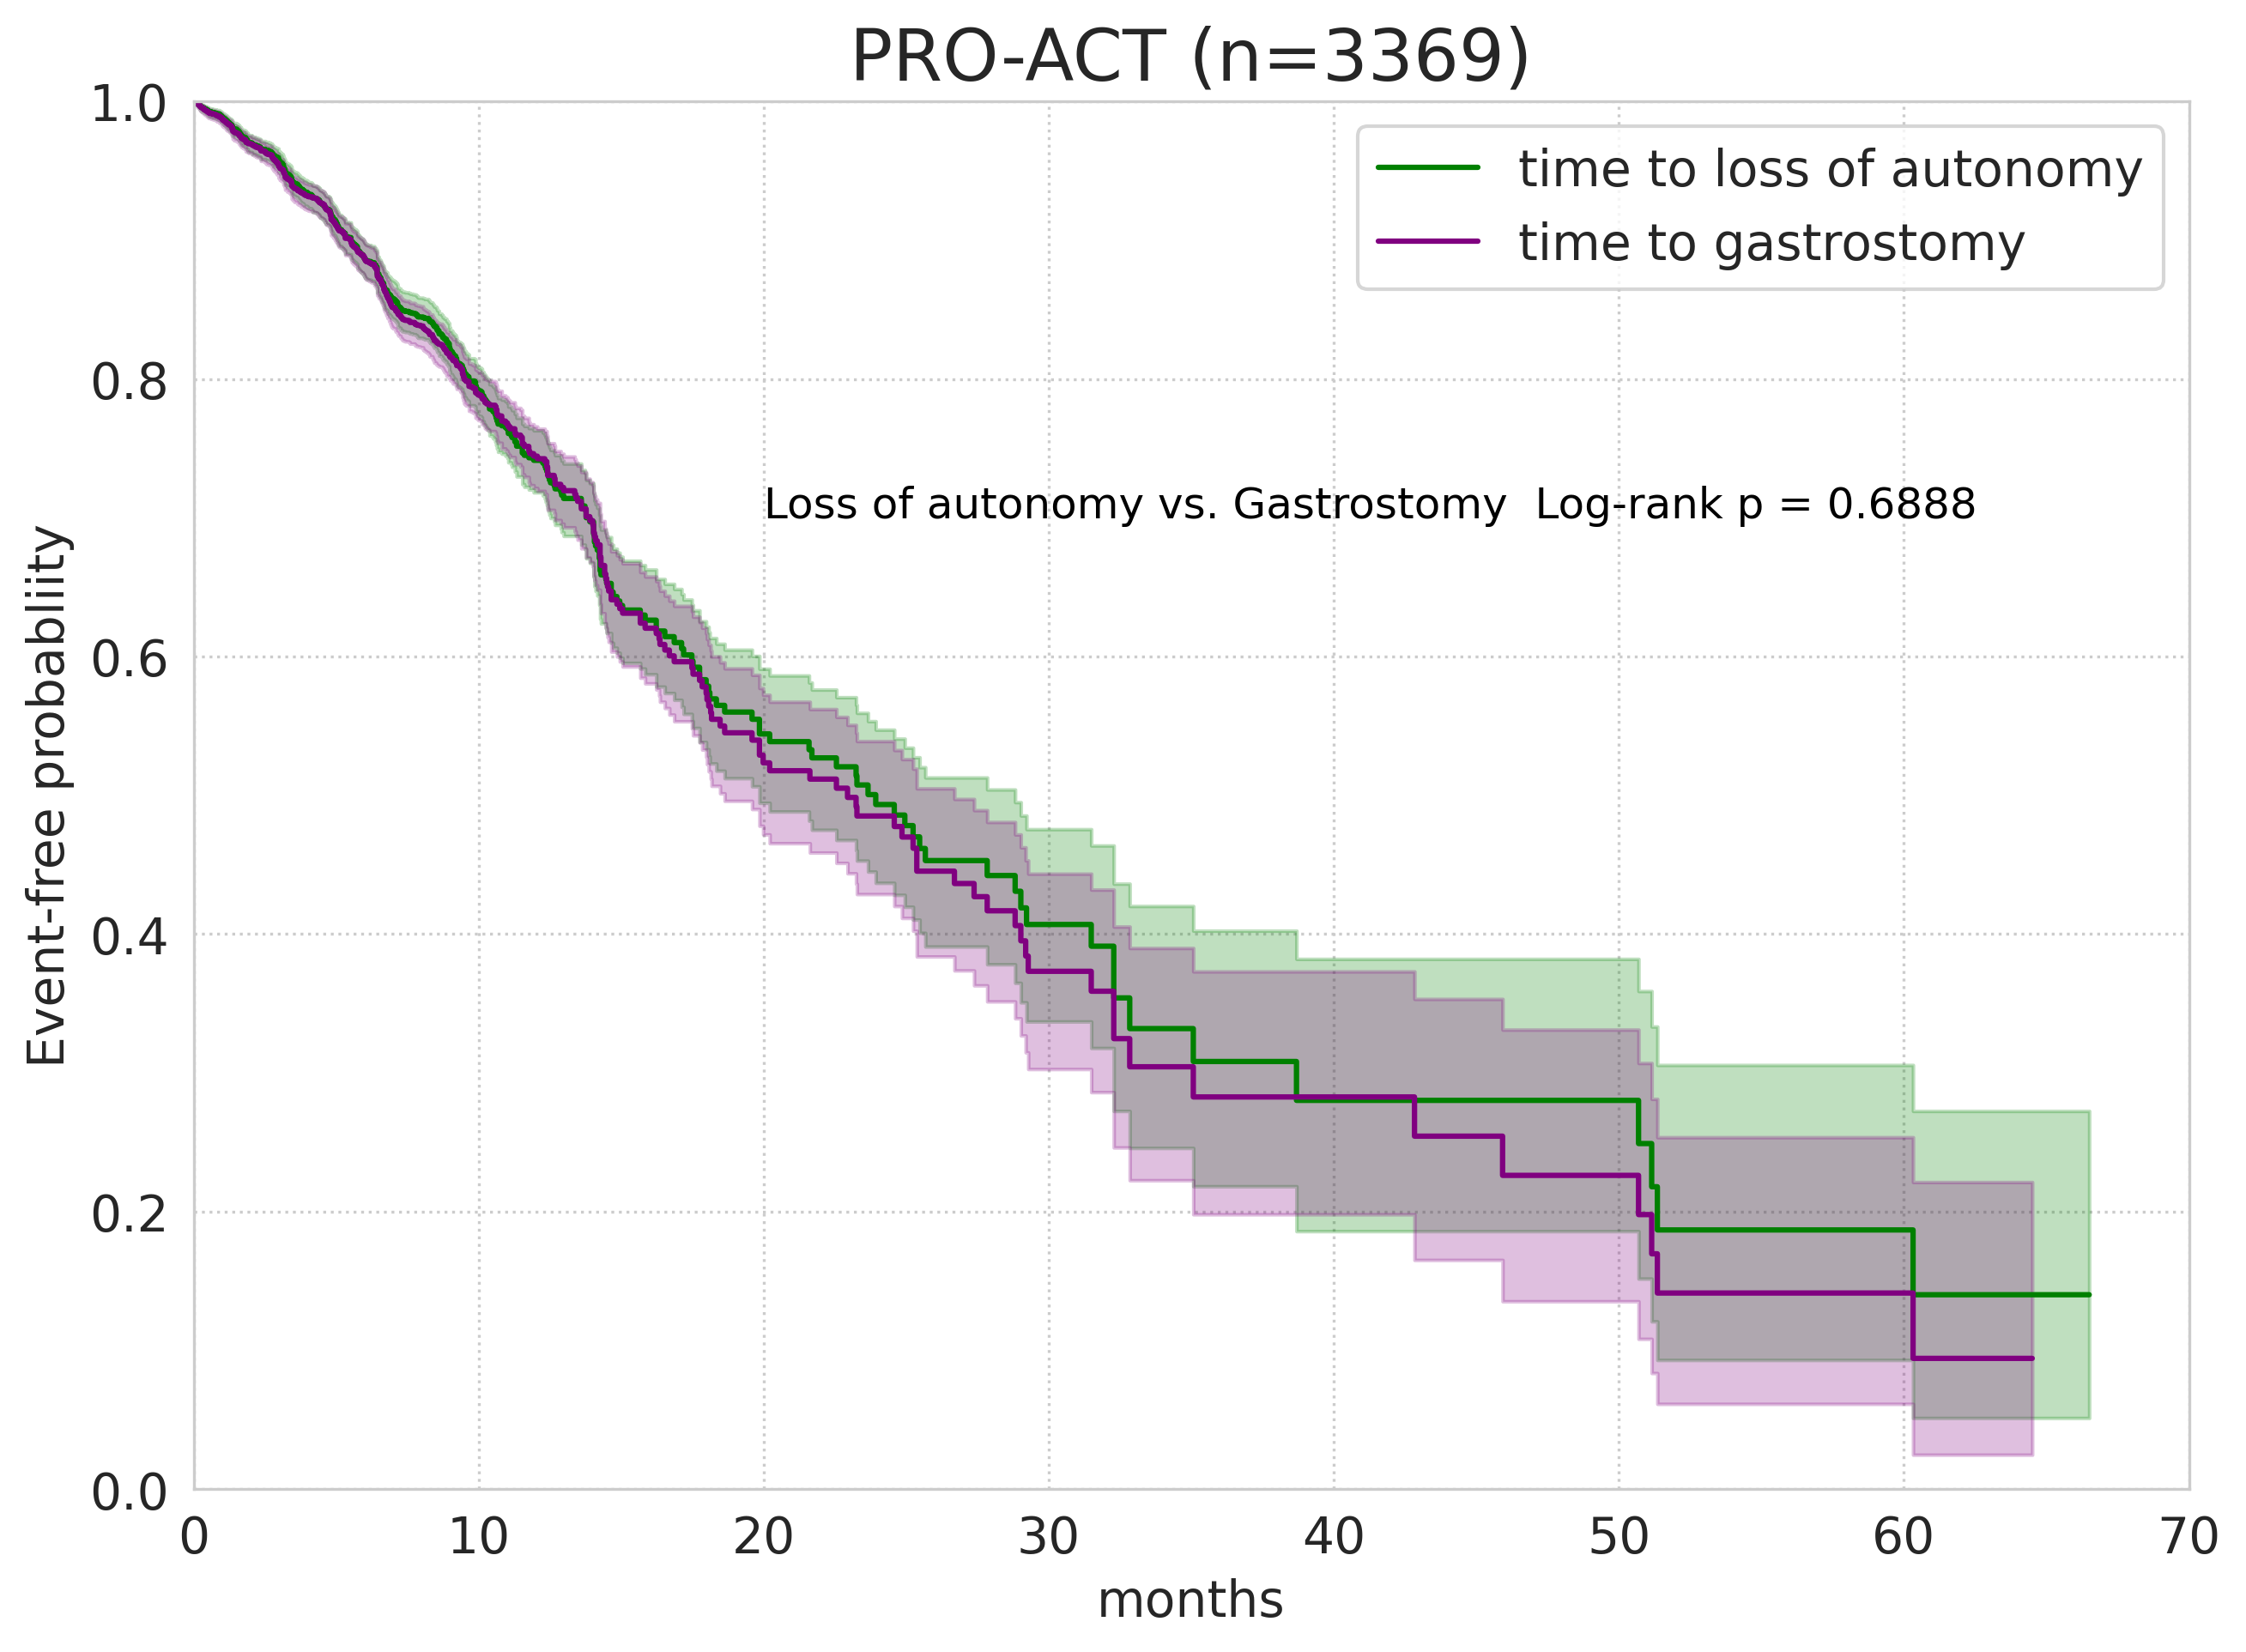

In [ ]:
from lifelines.statistics import logrank_test
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 7))

# Calculate log-rank test p-value
log_rank_result = logrank_test(merged_target["time_LOA"], merged_target["time_GAS"], merged_target["status_LOA"], merged_target["status_GAS"])

LOA_plot = kmf.fit(merged_target["time_LOA"], merged_target["status_LOA"], label='time to loss of autonomy')
ax_kmf = LOA_plot.plot(color='green')
plt.xlim([0,70])
plt.ylim([0,1])

GAS_plot = kmf.fit(merged_target['time_GAS'], merged_target['status_GAS'], label='time to gastrostomy')
ax_kmf2 = GAS_plot.plot(color='purple')
plt.xlim([0,70])
plt.ylim([0,1])

plt.annotate(f'Loss of autonomy vs. Gastrostomy  Log-rank p = {log_rank_result.p_value:.4f}', xy=(20, 0.7), color='k', fontsize=12)
plt.xlabel('months')
plt.ylabel('Event-free probabliity')
plt.title('PRO-ACT (n=3369)', fontsize=20)
plt.show()

### (iii) Scatterplot of time_LOA & time_GAS

In [ ]:
print("There are ", len(merged_target.query('status_LOA ==1 and status_GAS ==1')), "occurred data in",len(merged_target), " merged target")

There are  547 occurred data in 3369  merged target


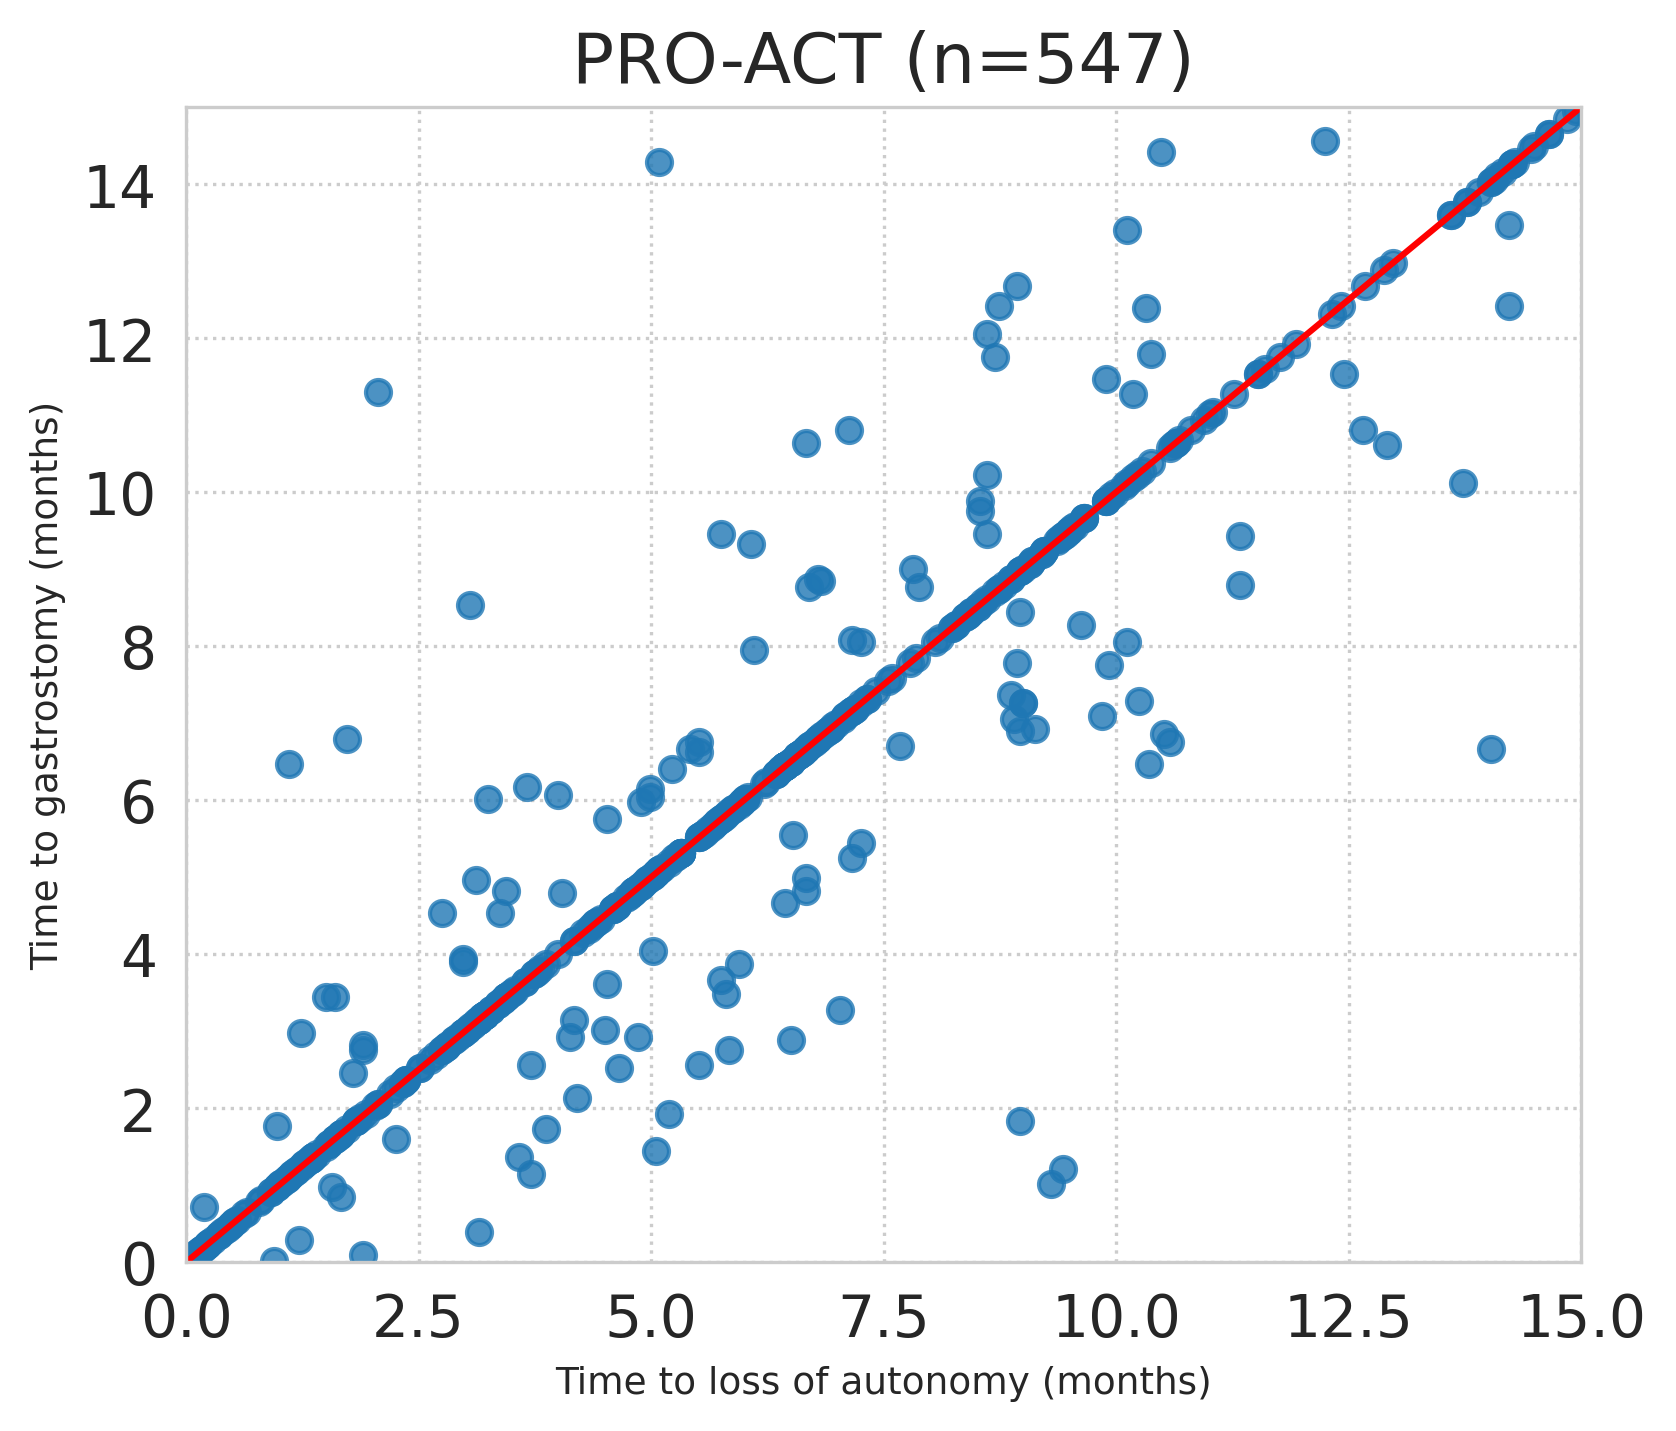

In [ ]:
scat_df = merged_target.query('status_LOA ==1 and status_GAS ==1')
fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(x=scat_df['time_LOA'], y=scat_df['time_GAS'], fit_reg=False)
plt.xlabel('Time to loss of autonomy (months)', fontsize=9)
plt.ylabel('Time to gastrostomy (months)', fontsize=9)
plt.title('PRO-ACT (n=547)')
ax.plot([0,1],[0,1], transform=ax.transAxes, color='red') # y=x line
plt.xlim([0,15])
plt.ylim([0,15])
plt.show() # shows enough match

## (2) SNUH data

### (i) Time to Gastrostomy = first time of 'ALSFRS Q5b is not NaN'

#### Extract Q5a, Q5b data

In [ ]:
snuh_frs['Q5 without gastrostomy'] = np.where(snuh_frs['gastrostomy'] == False, snuh_frs['Q5'], np.nan)
snuh_frs['Q5 with gastrostomy'] = np.where(snuh_frs['gastrostomy'] == True, snuh_frs['Q5'], np.nan)

snuh_frs = snuh_frs[['Study_ID', 'Date_visit', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5','Q5 without gastrostomy', 'Q5 with gastrostomy',
       'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'gastrostomy', 'ALSFRS_Total']]

In [ ]:
#Change column name and drop unnecessary columns
snuh_frs = snuh_frs.drop(columns=['gastrostomy'])
snuh_frs.columns = ['Study_ID', 'Date_visit', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5_Cutting','Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking', 'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea', 'R3_Respiratory_Insufficiency','ALSFRS_R_Total']

In [ ]:
# Define function returning df with calculated feature delta for time-resolved feautures
def cal_feature_delta(df, date_enroll):
  df1 = pd.merge(df, date_enroll)
  df1['feature_delta'] = (pd.to_datetime(df1['Date_visit'])- pd.to_datetime(df1['Date_enrollment'])) / np.timedelta64(1,'D') * 12/365
  df1 = df1.sort_values(by=['SubjectID', 'feature_delta'], axis=0).reset_index().drop(columns='index')
  df1.drop(columns = ['Date_visit','Date_enrollment'], inplace = True)
  return df1

In [ ]:
snuh_frs.rename(columns = {'Study_ID':'SubjectID'},inplace=True)

date_enroll = dx[['Study_ID', 'Date_enrollment']]
date_enroll.columns=['SubjectID', 'Date_enrollment']
alsfrs_R_raw = cal_feature_delta(snuh_frs, date_enroll)


alsfrs_R_raw = alsfrs_R_raw[['SubjectID','feature_delta', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing', 'Q4_Handwriting', 'Q5_Cutting',
       'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking',
       'Q9_Climbing_Stairs', 'R1_Dyspnea', 'R2_Orthopnea',
       'R3_Respiratory_Insufficiency', 'ALSFRS_R_Total' ]]
alsfrs_R_raw

SubjectID  feature_delta  Q1_Speech  Q2_Salivation  Q3_Swallowing  \
0          1003       0.000000          4              4              4   
1          1003       3.912329          4              4              4   
2          1003      10.356164          4              4              4   
3          1003      13.117808          4              4              4   
4          1003      16.339726          4              4              4   
...         ...            ...        ...            ...            ...   
1400      11872       0.000000          4              4              4   
1401      11872       4.109589          4              4              4   
1402      11872       5.950685          4              4              4   
1403      11872      10.323288          4              4              4   
1404      11872      16.076712          3              4              3   

      Q4_Handwriting  Q5_Cutting  Q5a_Cutting_without_Gastrostomy  \
0                  3           1                              1.0   
1                  1           2                              2.0   
2                  0           1                              1.0   
3                  0           0                              0.0   
4                  0           0                              0.0   
...              ...         ...                              ...   
1400               4           4                              4.0   
1401               4           3                              3.0   
1402               4           3                              3.0   
1403               3           2                              2.0   
1404               0           0                              0.0   

      Q5b_Cutting_with_Gastrostomy  Q6_Dressing_and_Hygiene  \
0                              NaN                        1   
1                              NaN                        1   
2                              NaN                        0   
3                              NaN                        0   
4                              NaN                        0   
...                            ...                      ...   
1400                           NaN                        4   
1401                           NaN                        3   
1402                           NaN                        3   
1403                           NaN                        3   
1404                           NaN                        0   

      Q7_Turning_in_Bed  Q8_Walking  Q9_Climbing_Stairs  R1_Dyspnea  \
0                     1           2                   0           4   
1                     1           1                   0           4   
2                     0           1                   0           4   
3                     0           1                   0           4   
4                     0           0                   0           4   
...                 ...         ...                 ...         ...   
1400                  4           2                   2           4   
1401                  3           2                   1           4   
1402                  3           1                   0           4   
1403                  2           1                   0           4   
1404                  0           0                   0           3   

      R2_Orthopnea  R3_Respiratory_Insufficiency  ALSFRS_R_Total  
0                4                             4              32  
1                4                             4              30  
2                4                             4              26  
3                4                             4              25  
4                4                             4              24  
...            ...                           ...             ...  
1400             4                             4              44  
1401             4                             4              40  
1402             4                             4              3

In [ ]:
ALSFRS_R_Q5 = alsfrs_R_raw[['SubjectID', 'feature_delta', 'Q5a_Cutting_without_Gastrostomy', 'Q5b_Cutting_with_Gastrostomy']]
ALSFRS_R_Q5

SubjectID  feature_delta  Q5a_Cutting_without_Gastrostomy  \
0          1003       0.000000                              1.0   
1          1003       3.912329                              2.0   
2          1003      10.356164                              1.0   
3          1003      13.117808                              0.0   
4          1003      16.339726                              0.0   
...         ...            ...                              ...   
1400      11872       0.000000                              4.0   
1401      11872       4.109589                              3.0   
1402      11872       5.950685                              3.0   
1403      11872      10.323288                              2.0   
1404      11872      16.076712                              0.0   

      Q5b_Cutting_with_Gastrostomy  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
...                            ...  
1400                           NaN  
1401                           NaN  
1402                           NaN  
1403                           NaN  
1404                           NaN  

[1405 rows x 4 columns]

In [ ]:
# Check if both Q5a, Q5b values are NaN
result = ALSFRS_R_Q5[(ALSFRS_R_Q5['Q5a_Cutting_without_Gastrostomy'] == np.NaN) & (ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'] == np.NaN)]

if not result.empty:
    print("Rows where both Q5a, Q5b values are NaN found:")
    print(result)
else:
    print("No rows where both Q5a, Q5b values are NaN.")

No rows where both Q5a, Q5b values are NaN.


In [ ]:
# Check if both Q5a, Q5b values exist
result = ALSFRS_R_Q5[~(ALSFRS_R_Q5['Q5a_Cutting_without_Gastrostomy'].isna() | ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'].isna())]

if not result.empty:
    print("Rows where both Q5a, Q5b values exist found:")
    print(result)
else:
    print("No rows where both Q5a, Q5b values exist.")

No rows where both Q5a, Q5b values exist.


In [ ]:
# Sort SubjectID and feature delta in ascending order
ALSFRS_R_Q5 = ALSFRS_R_Q5.query('feature_delta >= 0')
ALSFRS_R_Q5 = ALSFRS_R_Q5.sort_values(by=[ALSFRS_R_Q5.columns[0],ALSFRS_R_Q5.columns[1]],ascending=True)
ALSFRS_R_Q5

SubjectID  feature_delta  Q5a_Cutting_without_Gastrostomy  \
0          1003       0.000000                              1.0   
1          1003       3.912329                              2.0   
2          1003      10.356164                              1.0   
3          1003      13.117808                              0.0   
4          1003      16.339726                              0.0   
...         ...            ...                              ...   
1400      11872       0.000000                              4.0   
1401      11872       4.109589                              3.0   
1402      11872       5.950685                              3.0   
1403      11872      10.323288                              2.0   
1404      11872      16.076712                              0.0   

      Q5b_Cutting_with_Gastrostomy  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
...                            ...  
1400                           NaN  
1401                           NaN  
1402                           NaN  
1403                           NaN  
1404                           NaN  

[1405 rows x 4 columns]

In [ ]:
print("ALSFRS_Q5 contains", len(ALSFRS_R_Q5['SubjectID'].unique().tolist()), " patients")

ALSFRS_Q5 contains 207  patients


In [ ]:
ALSFRS_R_Q5 = ALSFRS_R_Q5.astype('float')
ALSFRS_R_Q5.dtypes

SubjectID                          float64
feature_delta                      float64
Q5a_Cutting_without_Gastrostomy    float64
Q5b_Cutting_with_Gastrostomy       float64
dtype: object

#### Extract 'Time_to_gastrostomy'

In [ ]:
# Find the first time of [ALSFRS_Q5b is not NaN]
Target_event = ALSFRS_R_Q5[ALSFRS_R_Q5['Q5b_Cutting_with_Gastrostomy'].notna()].groupby('SubjectID').agg(['first']).reset_index()
Target_event.head()

SubjectID feature_delta Q5a_Cutting_without_Gastrostomy  \
                    first                           first   
0    1003.0     30.641096                             NaN   
1    1021.0     47.769863                             NaN   
2    1037.0     26.860274                             NaN   
3    1054.0     25.775342                             NaN   
4    1058.0     10.389041                             NaN   

  Q5b_Cutting_with_Gastrostomy  
                         first  
0                          0.0  
1                          0.0  
2                          0.0  
3                          4.0  
4                          3.0

In [ ]:
# Coding [ALSFRS_Q5b is not NaN] event as '1'
Target_event_1 = Target_event[[('SubjectID',''), ('feature_delta', 'first')]]
Target_event_1.columns = ['SubjectID', 'time_GAS']

Target_event_1_subject_list = list(Target_event['SubjectID'])

Target_event_1['status_GAS'] = 1
print("There are",len(Target_event_1['SubjectID'].unique()), "subjects whose Gastrostomy = 1")

# Otherwise '0'
Target_event_0 = ALSFRS_R_Q5[~ALSFRS_R_Q5['SubjectID'].isin(Target_event_1_subject_list)]
Target_event_0 = Target_event_0.groupby('SubjectID').agg(['last']).reset_index().drop(columns=[('Q5a_Cutting_without_Gastrostomy', 'last'), ('Q5b_Cutting_with_Gastrostomy', 'last')])
Target_event_0.columns = ['SubjectID', 'time_GAS']
Target_event_0['status_GAS'] = 0
print("There are",len(Target_event_0['SubjectID'].unique()), "subjects whose Gastrostomy = 0")

# There are 32 subjects whose Gastrostomy = 1
# There are 175 subjects whose Gastrostomy = 0

There are 32 subjects whose Gastrostomy = 1
There are 175 subjects whose Gastrostomy = 0


<ipython-input-298-3fbfda4ea06a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Target_event_1['status_GAS'] = 1


In [ ]:
ALFRS_Q5_coded = pd.concat([Target_event_1, Target_event_0]).sort_values(by='SubjectID', axis=0)
ALFRS_Q5_coded = ALFRS_Q5_coded.reset_index()
ALFRS_Q5_coded.drop(columns='index', inplace=True)

Target_Data = ALFRS_Q5_coded.copy()
Target_Data_subject_list = list(Target_Data['SubjectID'])
Target_Data #207 data

SubjectID   time_GAS  status_GAS
0       1003.0  30.641096           1
1       1005.0  29.457534           0
2       1010.0   3.912329           0
3       1017.0   4.635616           0
4       1019.0  42.476712           0
..         ...        ...         ...
202     1901.0   4.668493           0
203     1915.0   4.109589           0
204     1921.0   3.057534           0
205    11871.0  12.361644           0
206    11872.0  16.076712           0

[207 rows x 3 columns]

#### Exclude; event or censoring occurred within 3 months after enrollment (to compare with time to LOA, we apply same exclusion criteria)

<Axes: xlabel='time_GAS', ylabel='Count'>

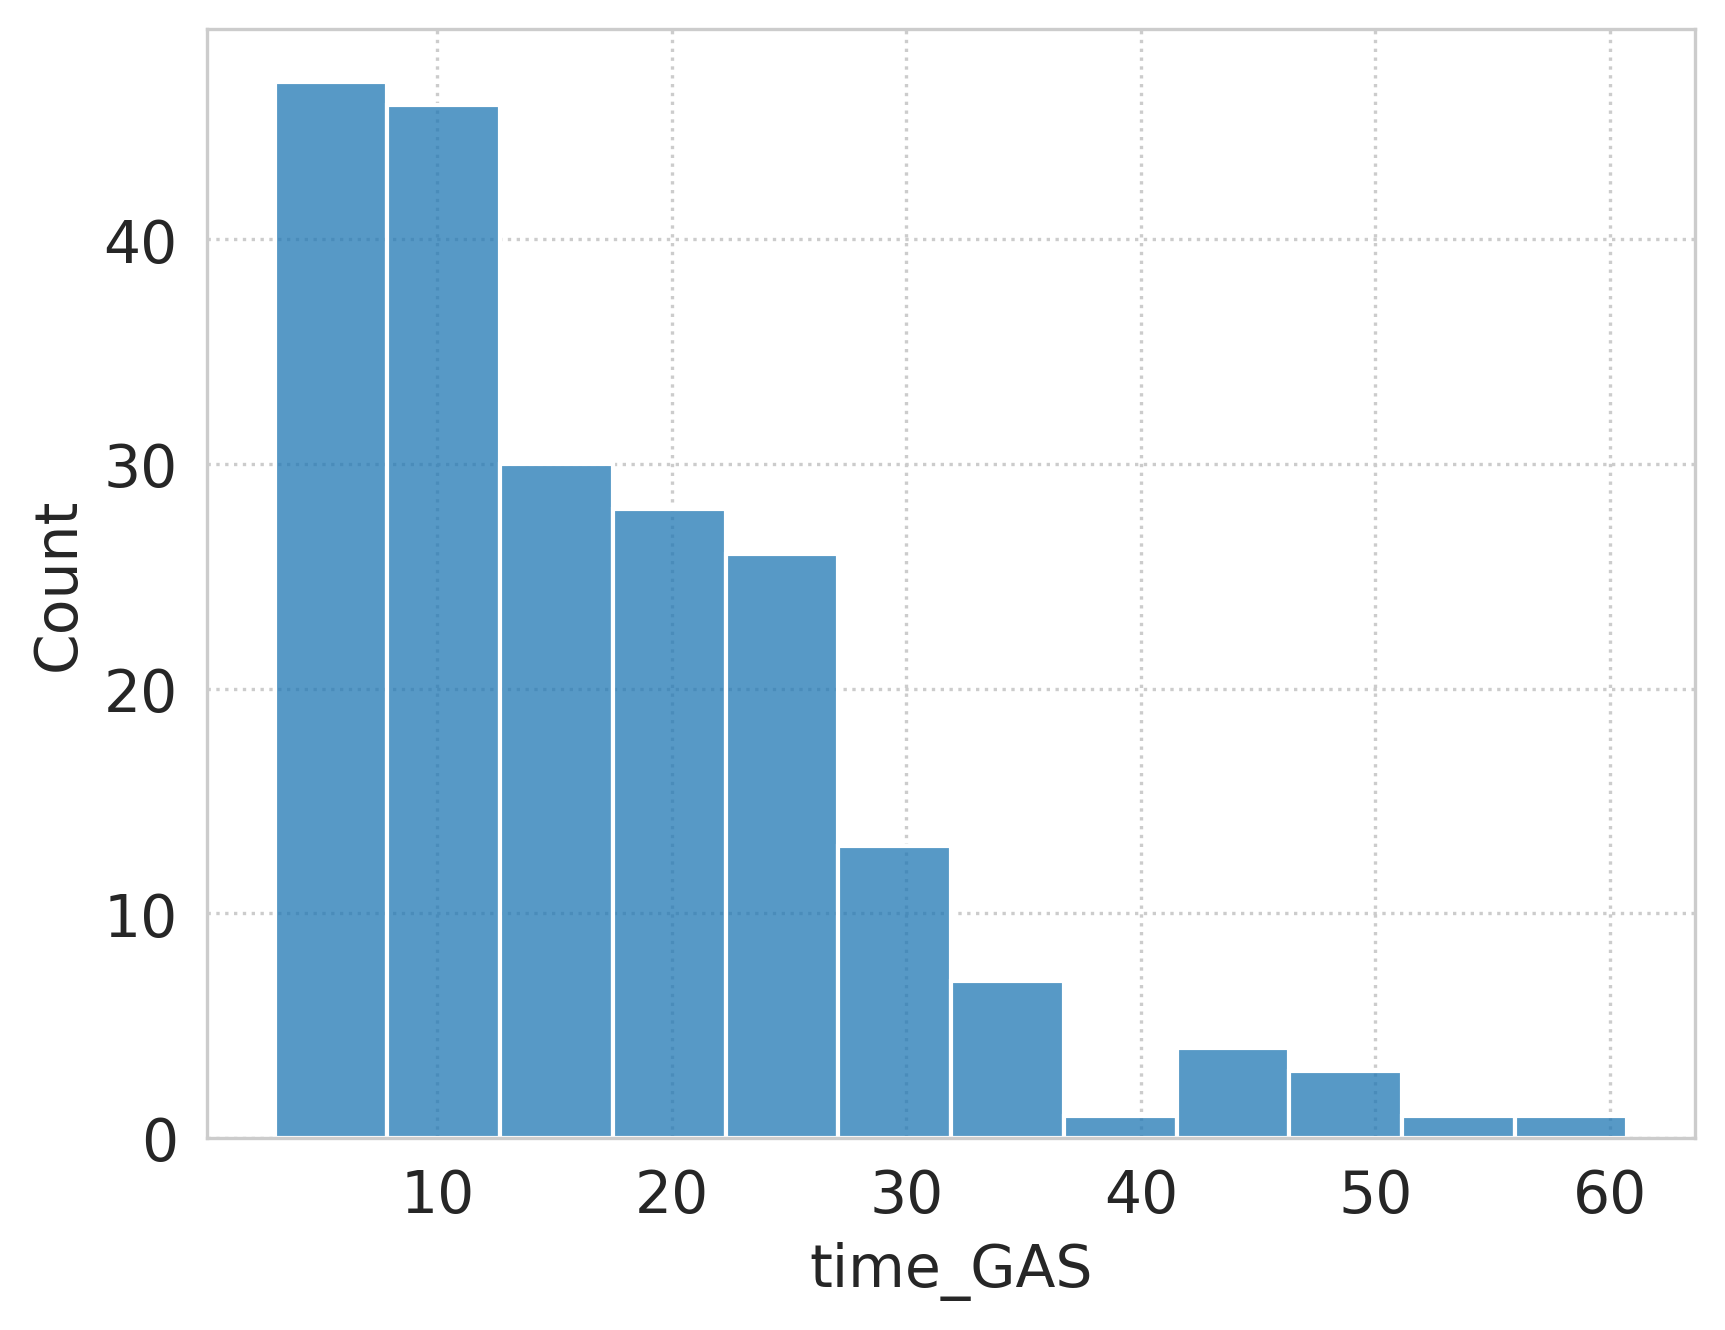

In [ ]:
sns.histplot(Target_Data['time_GAS'])

In [ ]:
Target_Data.query('time_GAS <= 3.0')

Empty DataFrame
Columns: [SubjectID, time_GAS, status_GAS]
Index: []

In [ ]:
print(len(Target_Data.query('time_GAS <= 3.0')['SubjectID'].tolist()), 'patients has time_GAS 3 month or less')

0 patients has time_GAS 3 month or less


In [ ]:
Target_Data_final = Target_Data.query('time_GAS > 3.0')

# minus 3months for target data value
Target_Data_final['time_GAS'] = Target_Data_final['time_GAS'] -3.0

GAS = Target_Data_final
GAS

SubjectID   time_GAS  status_GAS
0       1003.0  27.641096           1
1       1005.0  26.457534           0
2       1010.0   0.912329           0
3       1017.0   1.635616           0
4       1019.0  39.476712           0
..         ...        ...         ...
202     1901.0   1.668493           0
203     1915.0   1.109589           0
204     1921.0   0.057534           0
205    11871.0   9.361644           0
206    11872.0  13.076712           0

[207 rows x 3 columns]

In [ ]:
# Note that 'time_GAS' is month scaled

In [ ]:
LOA = snuh_imputed[['SubjectID','time_LOA', 'status_LOA']]
LOA

SubjectID   time_LOA  status_LOA
0         1003  27.641096           0
1         1005  26.457534           1
2         1010   0.912329           0
3         1017   1.635616           0
4         1019  39.476712           0
..         ...        ...         ...
202       1901   1.668493           0
203       1915   1.109589           0
204       1921   0.057534           0
205      11871   9.361644           0
206      11872  13.076712           0

[207 rows x 3 columns]

In [ ]:
# Check the proportion of censored data
print("There are ", len(LOA[LOA['status_LOA']==0]), "censored data in",len(LOA), " Loss of Autonomy")
print("There are ", len(GAS[GAS['status_GAS']==0]), "censored data in",len(GAS), " gastrostomy")

There are  166 censored data in 207  Loss of Autonomy
There are  175 censored data in 207  gastrostomy


### (ii) KM estimation on each target





In [ ]:
merged_target = pd.merge(LOA, GAS, on='SubjectID', how='inner')
merged_target

SubjectID   time_LOA  status_LOA   time_GAS  status_GAS
0         1003  27.641096           0  27.641096           1
1         1005  26.457534           1  26.457534           0
2         1010   0.912329           0   0.912329           0
3         1017   1.635616           0   1.635616           0
4         1019  39.476712           0  39.476712           0
..         ...        ...         ...        ...         ...
202       1901   1.668493           0   1.668493           0
203       1915   1.109589           0   1.109589           0
204       1921   0.057534           0   0.057534           0
205      11871   9.361644           0   9.361644           0
206      11872  13.076712           0  13.076712           0

[207 rows x 5 columns]

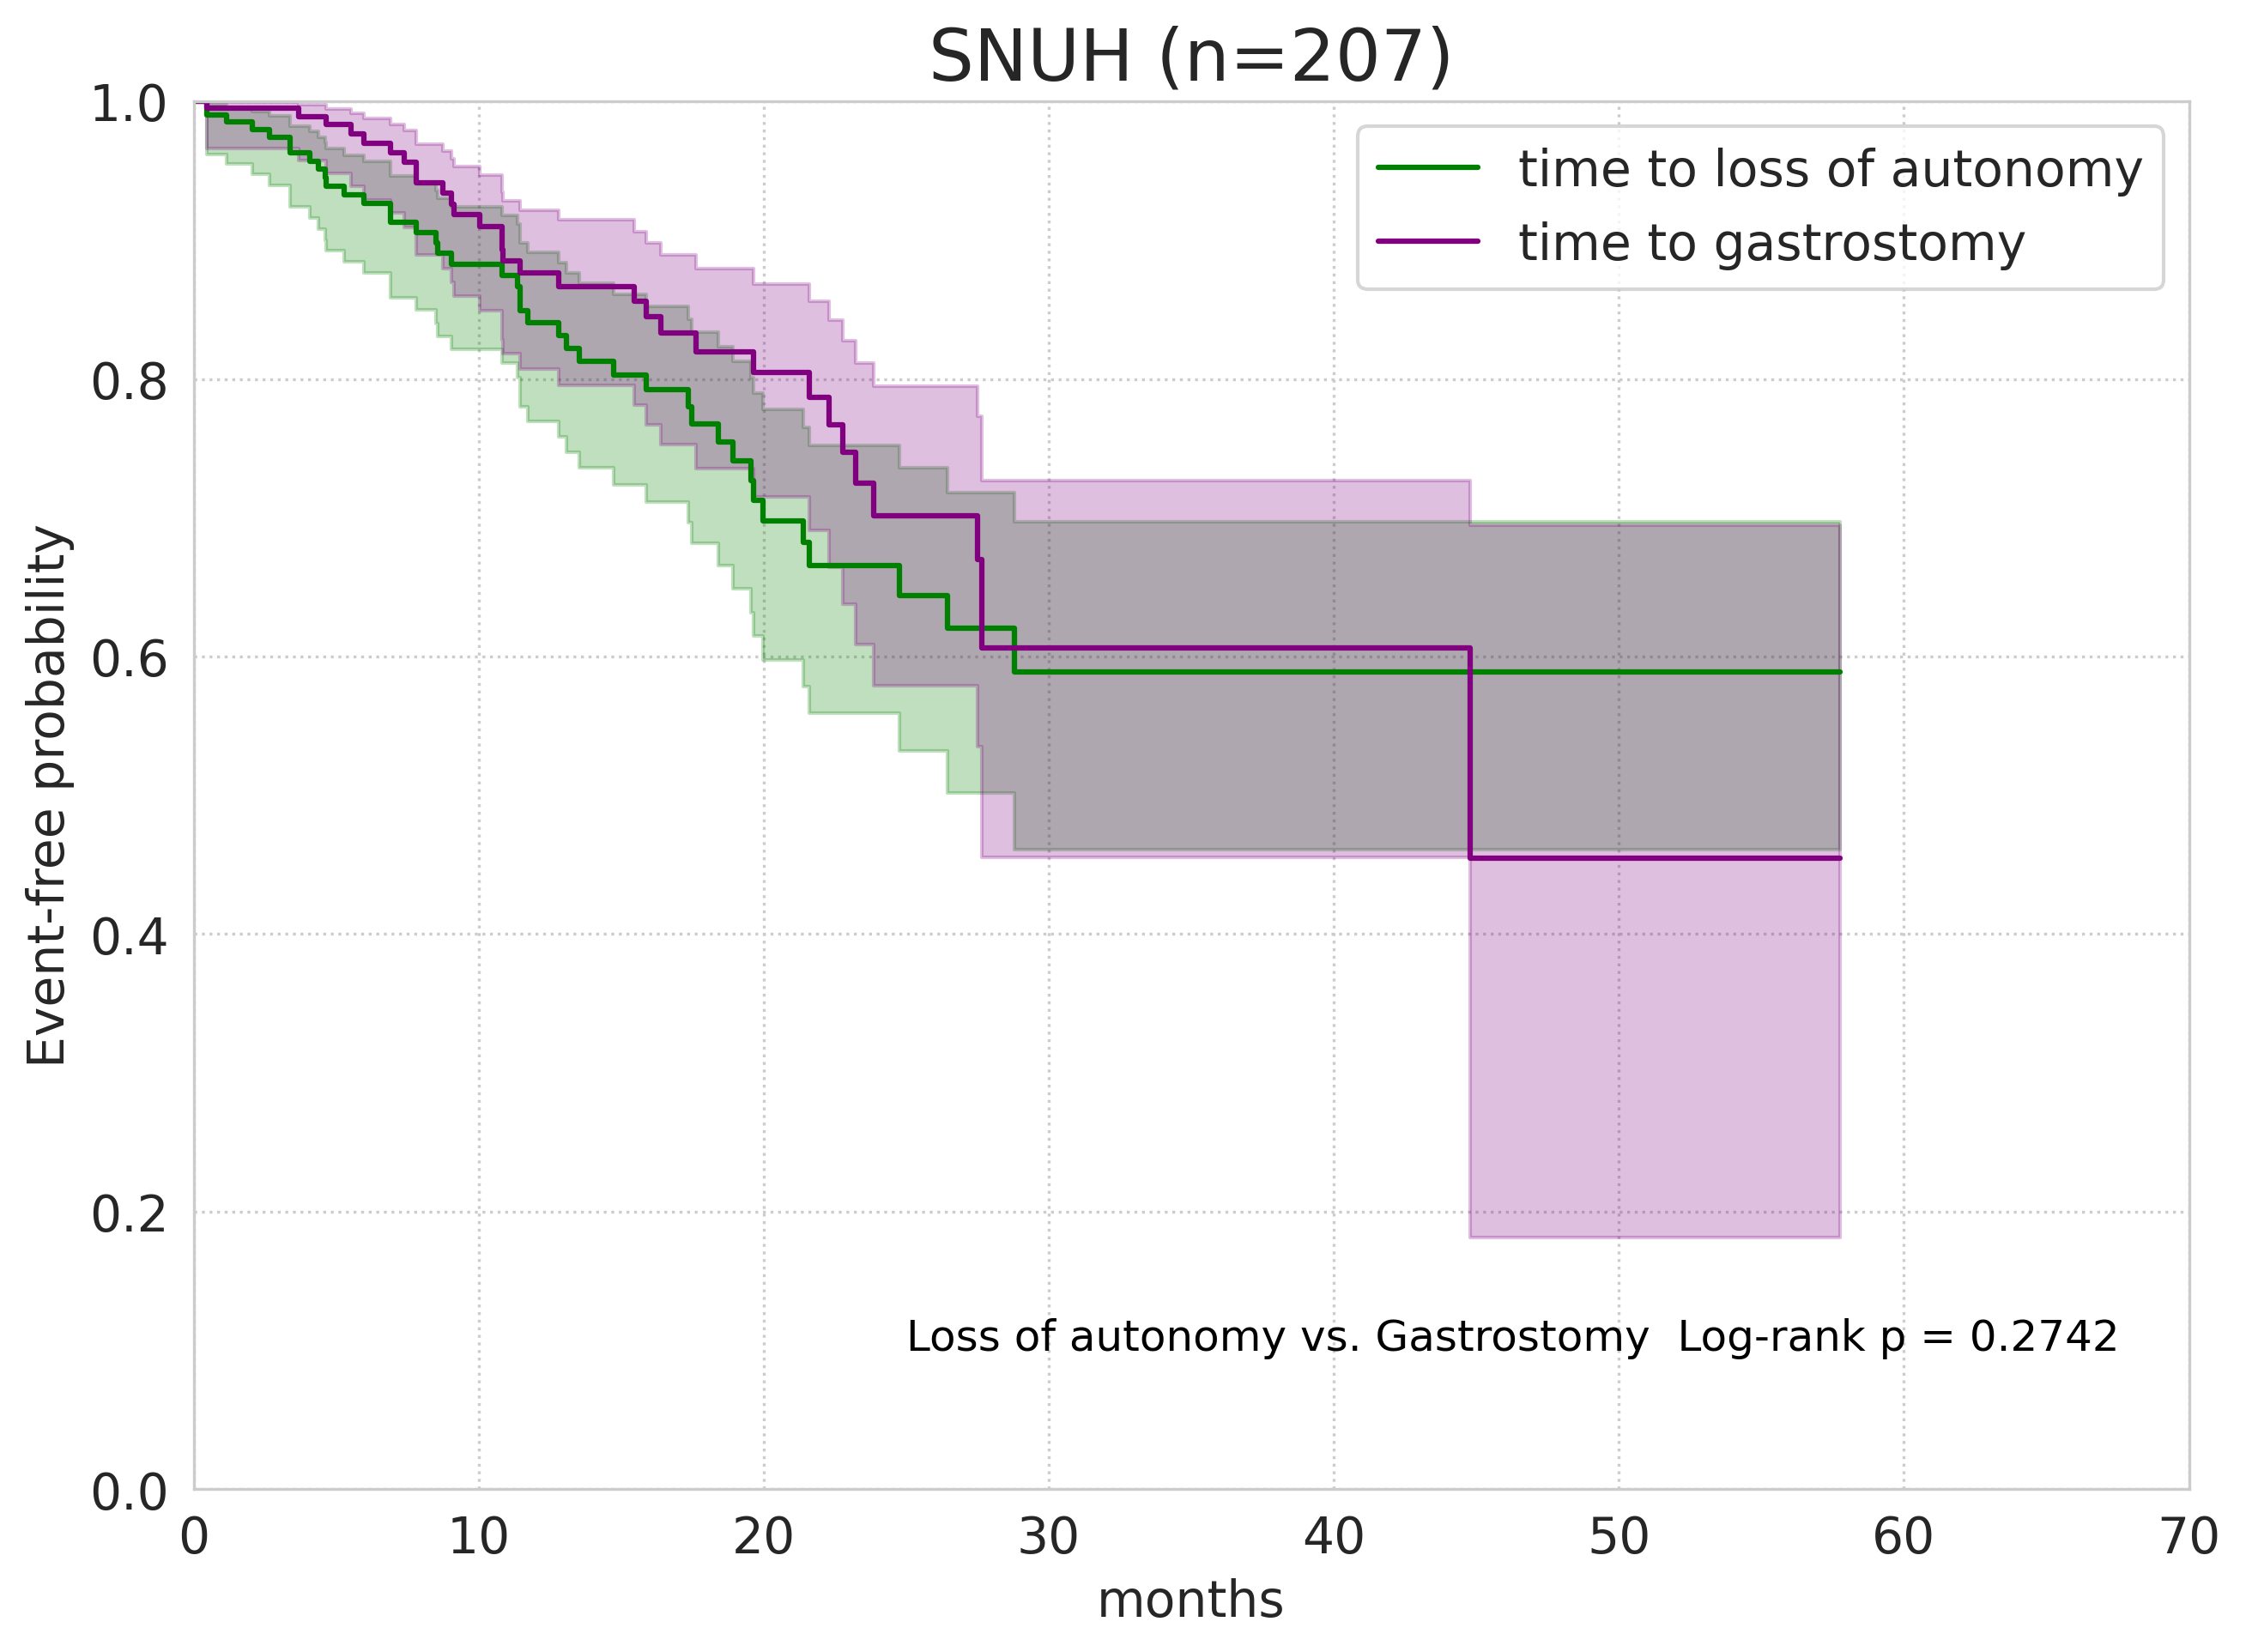

In [ ]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 7))

# Calculate log-rank test p-value
log_rank_result = logrank_test(merged_target["time_LOA"], merged_target["time_GAS"], merged_target["status_LOA"], merged_target["status_GAS"])

LOA_plot = kmf.fit(merged_target["time_LOA"], merged_target["status_LOA"], label='time to loss of autonomy')
ax_kmf = LOA_plot.plot(color='green')
plt.xlim([0,70])
plt.ylim([0,1])

GAS_plot = kmf.fit(merged_target['time_GAS'], merged_target['status_GAS'], label='time to gastrostomy')
ax_kmf2 = GAS_plot.plot(color='purple')
plt.xlim([0,70])
plt.ylim([0,1])

plt.annotate(f'Loss of autonomy vs. Gastrostomy  Log-rank p = {log_rank_result.p_value:.4f}', xy=(25, 0.1), color='k', fontsize=12)
plt.xlabel('months')
plt.ylabel('Event-free probability')
plt.title('SNUH (n=207)', fontsize=20)
plt.show()

### (iii) Scatterplot of time_LOA & time_GAS

In [ ]:
print("There are ", len(merged_target.query('status_LOA ==1 and status_GAS ==1')), "occurred data in",len(merged_target), " merged target")

There are  24 occurred data in 207  merged target


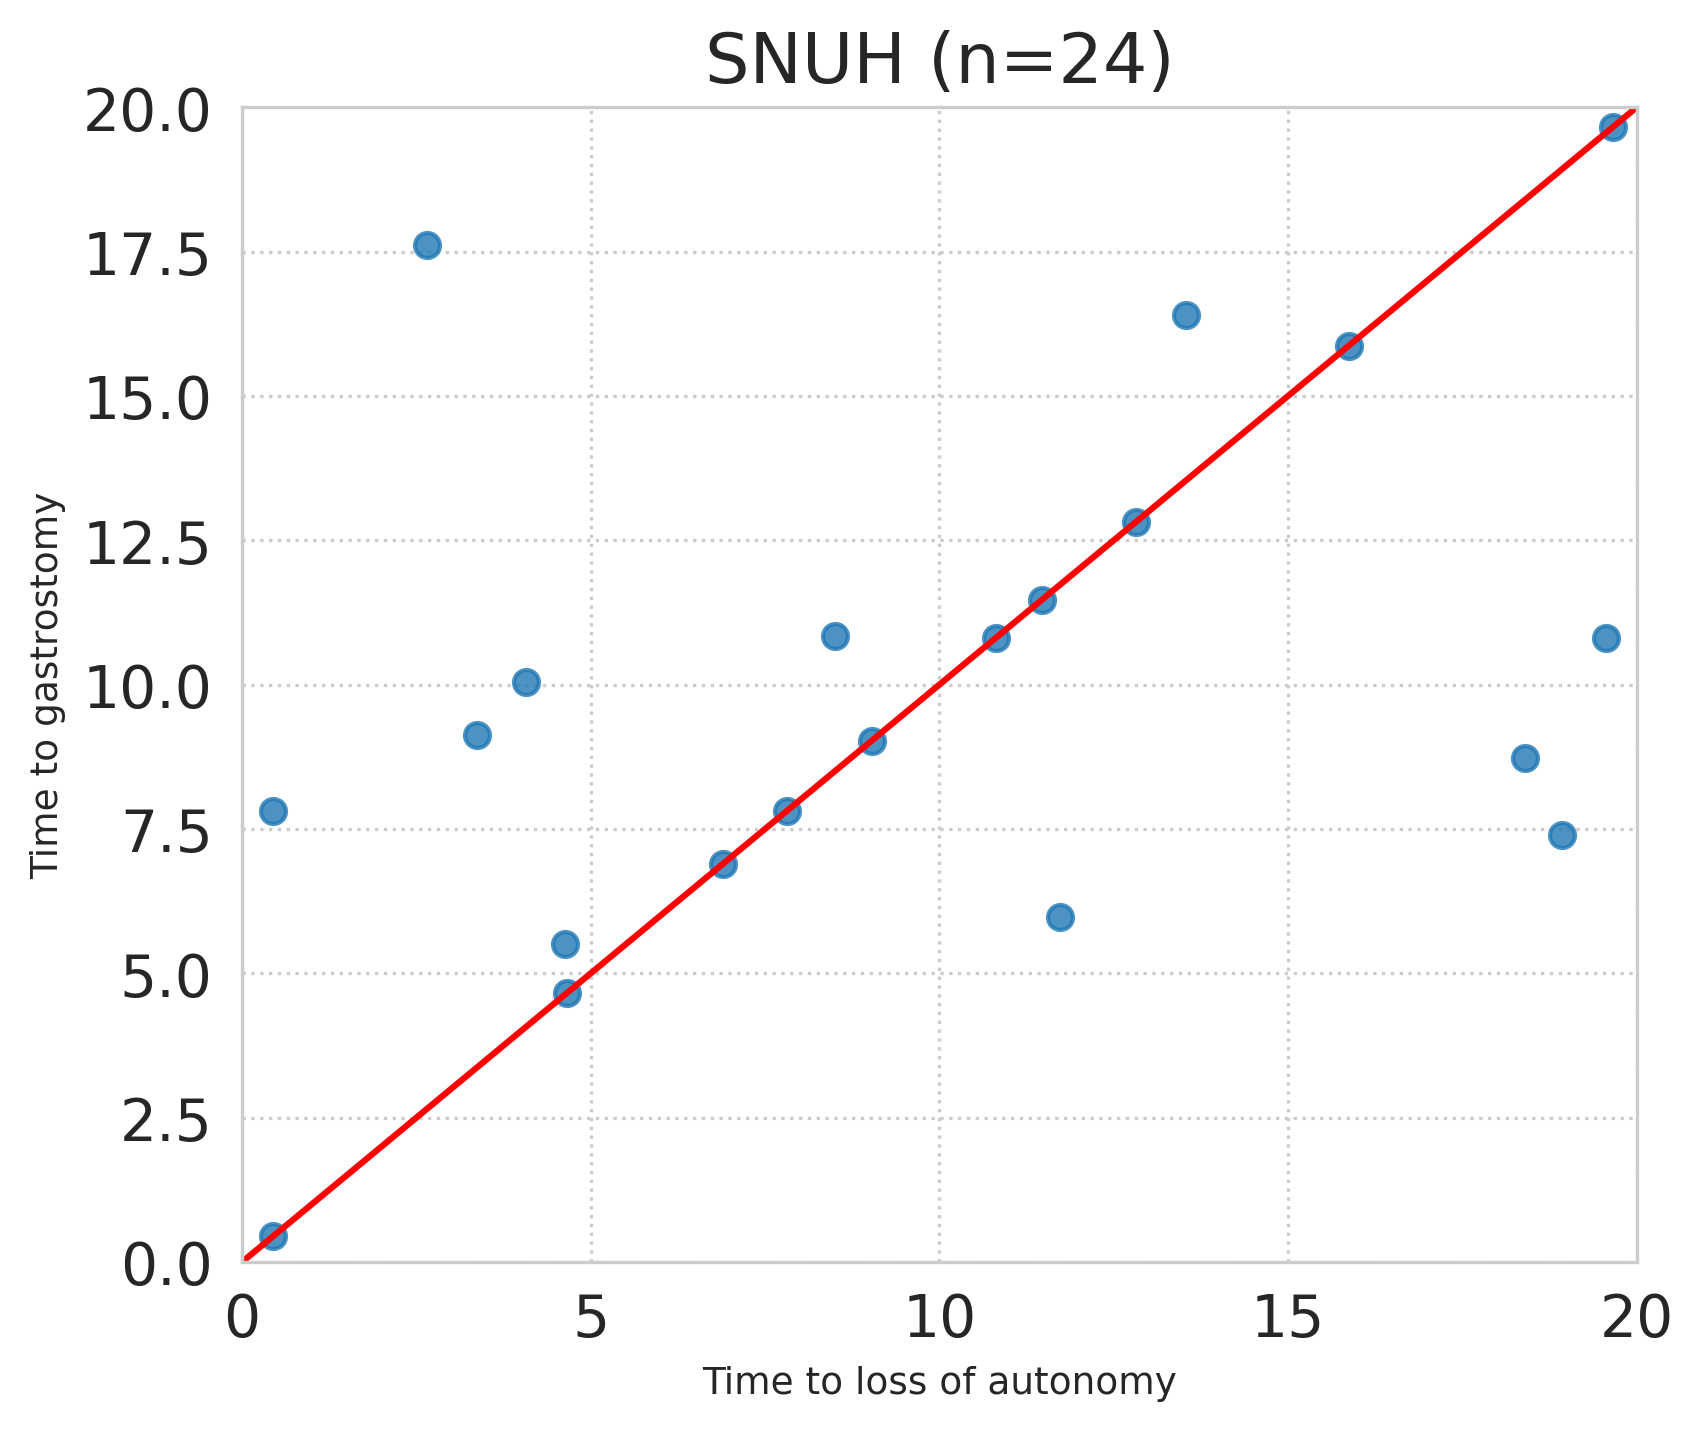

In [ ]:
scat_df = merged_target.query('status_LOA ==1 and status_GAS ==1')
fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(x=scat_df['time_LOA'], y=scat_df['time_GAS'], fit_reg=False)
plt.xlabel('Time to loss of autonomy', fontsize=9)
plt.ylabel('Time to gastrostomy', fontsize=9)
plt.title('SNUH (n=24)')
ax.plot([0,1],[0,1], transform=ax.transAxes, color='red') # y=x line
plt.xlim([0,20])
plt.ylim([0,20])
plt.show() # shows enough match